In [63]:
import pandas as pd 
import numpy as np 
from scipy.stats import spearmanr
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [64]:
data_train = pd.read_csv('train.csv')

#### Spot that "test" data here is actually "production" data which we should not see (the dependend variable is not even available in "test" data). So only splitting "data_train" into train test will give us proper test / train data. 

#### EDA will be done firstly. I was a little confused whether to split data before or after EDA. The opinions about it are very different on the internet. 
#### If, at first, we do EDA: "*we would run the risk of overfitting the model to the peculiarities of the data we have, for example by engineering features that work well for the testing data*" ~ [Stackoverflow answer](https://stackoverflow.com/questions/54282411/machine-learning-project-split-training-test-sets-before-or-after-exploratory-d)
#### On the other hand, EDA is performed to understand data, so by doing EDA only on training dataset, we can lose, for example, about 30% of information about data.
#### At this moment, I think that EDA should be done before and after split but not in the same ways: **before** to understand data and **after** to make decisions how to change data before model building. But maybe the analysis done before train test split would give us all of the answers?

In [65]:
# function with the help of chatGPT to display tables in a more convenient way

def scrollable_dataframe(df):
    
    table_html = df.to_html(classes='table',
                            table_id='scrollable_table', 
                            escape=False)

    html = f'''
    <div style="width: 100%; height:400px; overflow:scroll;">
            <style>
             td, th {{
                white-space: nowrap;
                width: 100px;
                padding: 10px;
            }}
        </style>
        {table_html}
    </div>
    '''

    return display(HTML(html))

In [66]:
data_train.shape

(1460, 82)

In [67]:
data_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Brief look at missing values

In [68]:

scrollable_dataframe(data_train.isna().sum().to_frame())

### I will remove some of there freatures where at least 80% od data is missing because such feature would not tell anything interesting

In [69]:
numerical_features = data_train.select_dtypes(include=np.number).drop(columns=['Id', 'is_train'])
numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [70]:
scrollable_dataframe(numerical_features.describe().T)

# Numerical features analysis
--- 
#### (I will not take outliers into consideration at this moment)

### output variable: SalePrice

In [71]:
numerical_features['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

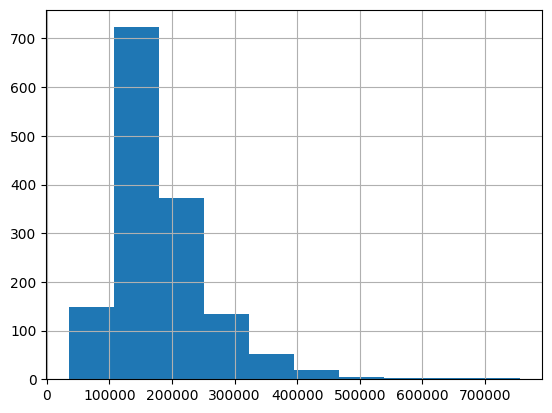

In [72]:
numerical_features['SalePrice'].hist()

### It is right skewed and probably does not follow normal distribution, but it does not matter as typical models I know does not require target variable to be normally distributed.

--- 

### MSSubClass: By looking at description of **MSSubClass**: it is or categorical either ordinal variable. 
### Let's see if *higher* MSSubClass value impacts salePrice.

<AxesSubplot:xlabel='MSSubClass'>

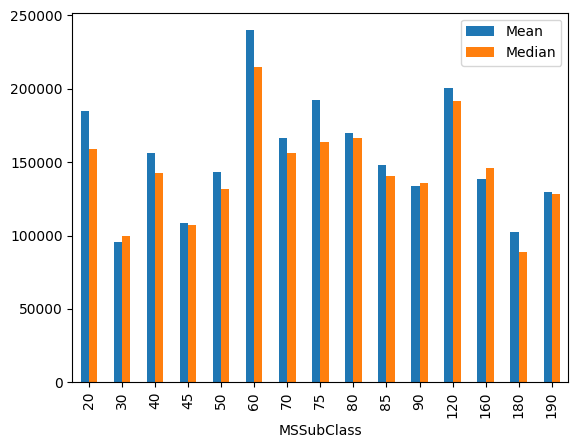

In [73]:
grpd = data_train.groupby('MSSubClass').agg(Mean=('SalePrice', 'mean'), Median=('SalePrice', 'median'))

grpd.plot.bar()

### As we can see MSSubClass is categorical, not ordinal because higher MSSubClass does not mean higher SalePrice.
### So later on it will be converted into string as categorical

--- 

### OverallQual and OverallCond 
#### They seem to be exemplary ordinal features. Let's see if higher quality implies higher SalePrice

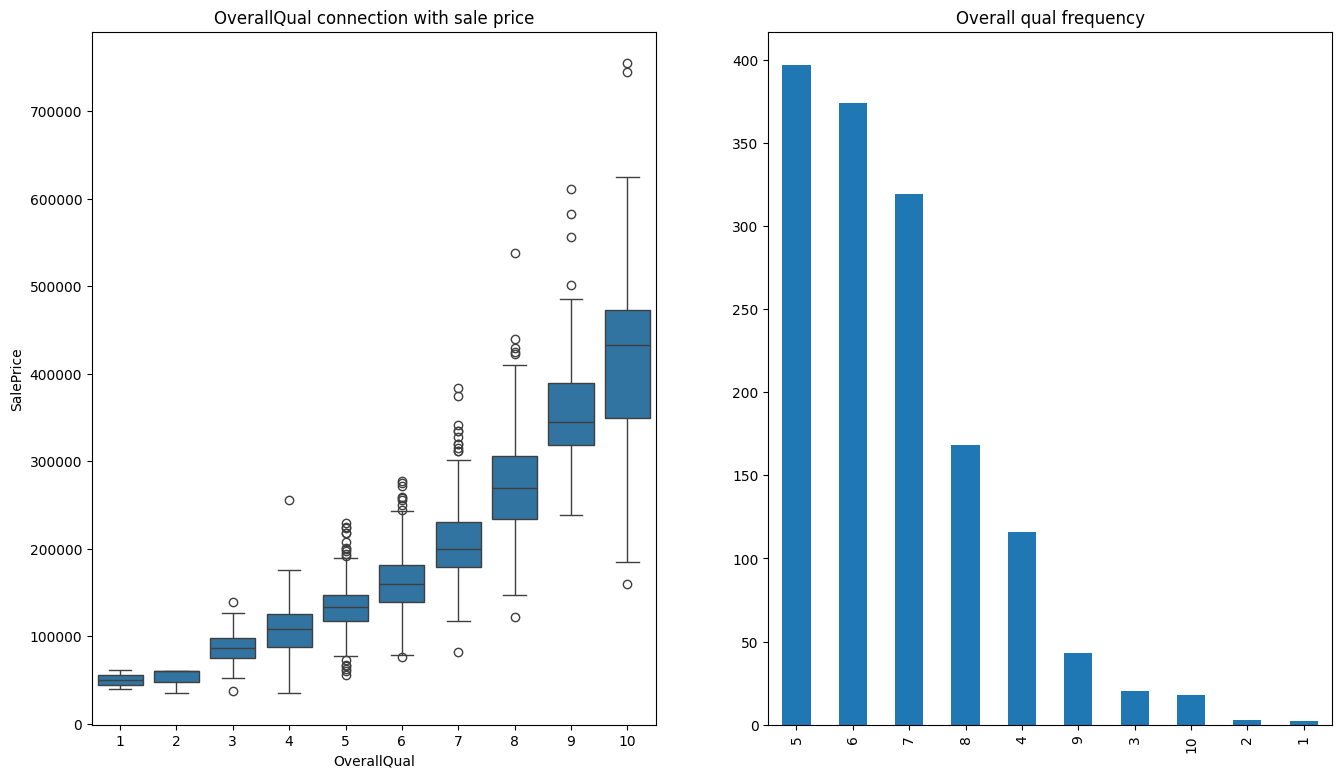

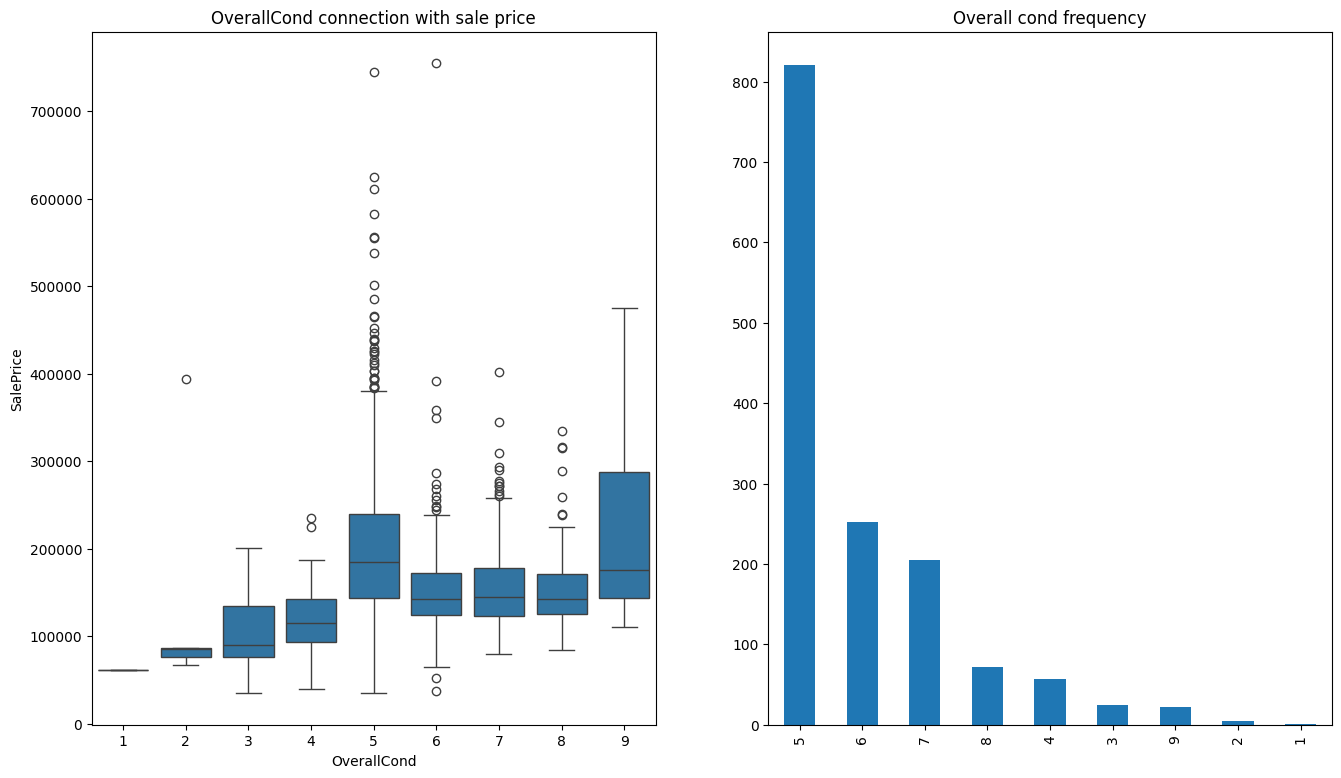

In [74]:
grpdQual = data_train.groupby('OverallQual').agg(Mean=('SalePrice', 'mean'), Median=('SalePrice', 'median'))
grpdCond = data_train.groupby('OverallCond').agg(Mean=('SalePrice', 'mean'), Median=('SalePrice', 'median'))
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
#grpdQual.plot.bar()
sns.boxplot(data = data_train, x='OverallQual', y='SalePrice')
plt.title('OverallQual connection with sale price')
plt.subplot(1, 2, 2)
data_train['OverallQual'].value_counts().plot(kind='bar', title='Overall qual frequency')
plt.show()

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
sns.boxplot(data = data_train, x='OverallCond', y='SalePrice')
plt.title('OverallCond connection with sale price')

plt.subplot(1, 2, 2)
data_train['OverallCond'].value_counts().plot(kind='bar', title='Overall cond frequency')
plt.show()


### OveralQual is fine - the higher *OveralCond* the better SalePrice we achieve on average.
### It is weird that 5 is "better" than 6, 7 and 8 in OveralCond. I am sure it is caused by "outliers" displayed on overallCond=5 boxplot.
### Let statistical test decide for me:

In [75]:
print(f"Overall Qual: {spearmanr(data_train['OverallQual'], data_train['SalePrice'], alternative='greater')}")
print(f"Overall Cond: {spearmanr(data_train['OverallCond'], data_train['SalePrice'], alternative='greater')}")

Overall Qual: SignificanceResult(statistic=0.8098285862017292, pvalue=0.0)
Overall Cond: SignificanceResult(statistic=-0.12932494660061317, pvalue=0.999999644072387)


### As one can interpret by looking at p-value:  
- I reject the null hypothesis saying that there is no correlation between *Overal Qual* and *SalePrice* in favour of the alternative hypothesis saying that *SalePrice* grows as *Overal Qual*
- there are no evidence to reject the null hypothesis saying that ( ... ) and because of that I approve it. So there is no correlation between OveralQual and SalePrice 

In [76]:
numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [77]:
count_features = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']
measured_features = ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotFrontage',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'MasVnrArea']

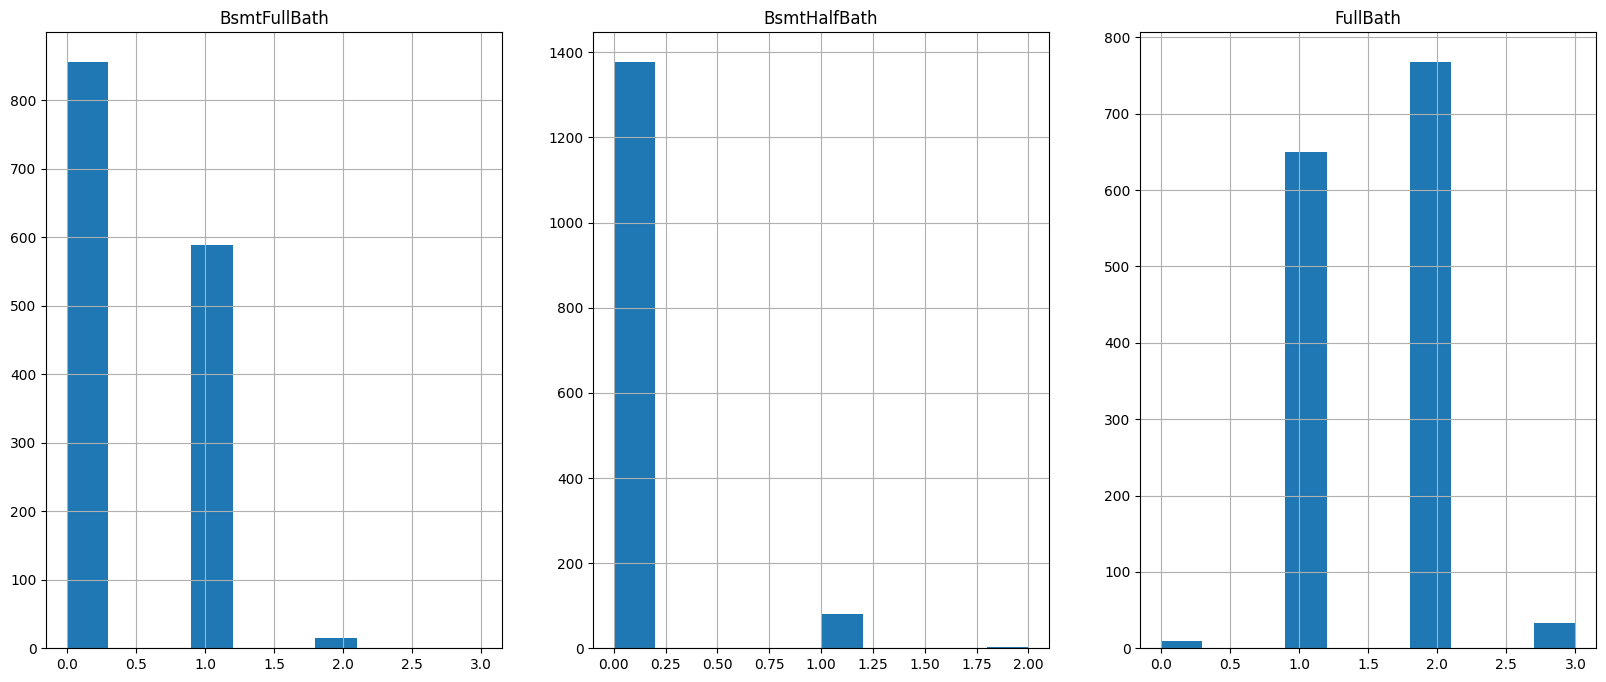

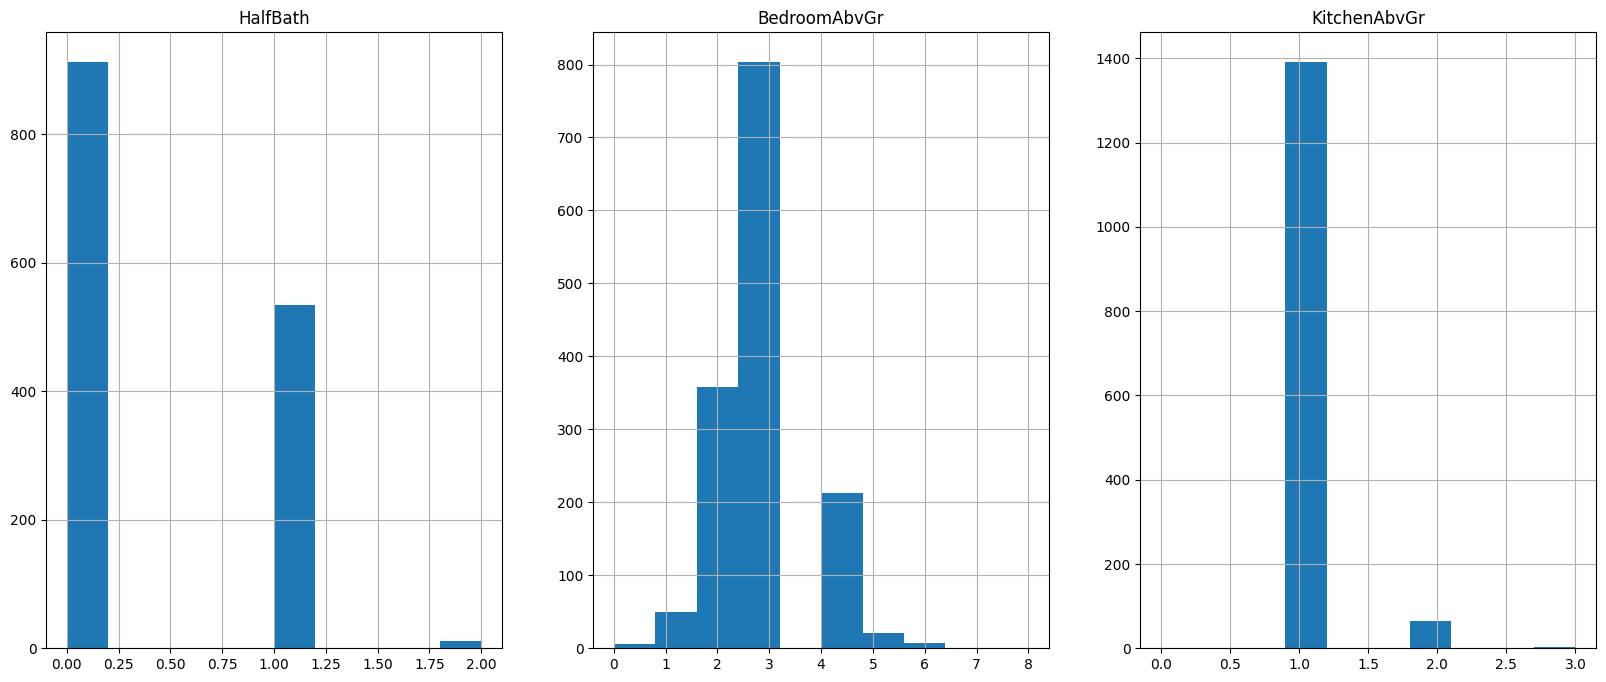

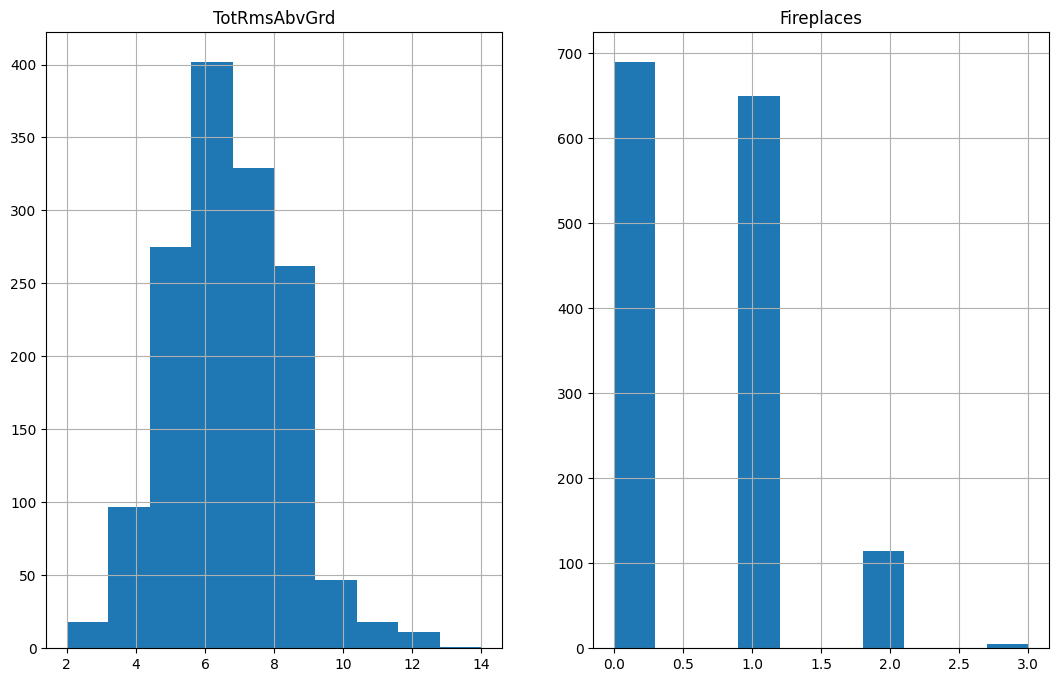

In [78]:
for i in range(len(count_features)):
    # draw 3 plots in one row
    if i % 3 == 0:
        plt.figure(figsize=(20, 8))

    plt.subplot(1, 3, (i % 3) + 1)
    data_train[count_features[i]].hist()
    plt.title(count_features[i])

    if (i % 3) == 2 | i == len(count_features) - 1:
        print("SHOW", i)
        plt.show()

### As I can understand from data description: TotRmsAbvGrd includes bedrooms, so *Bedroom* should depend on *TotRmsAbvGrd*

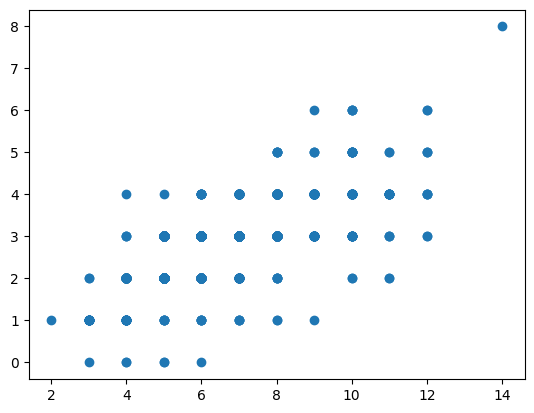

In [79]:
plt.plot(data_train['TotRmsAbvGrd'], data_train['BedroomAbvGr'], 'o')

### Maybe it will be sensible to remove *Bedroom* as it depends on *TotRmsAbvGrd*, I will see during building models

### Maybe *TotRmsAbvGrd*, apart from *bedroom*, also includes rooms like *Kitchen* or *Baths*?

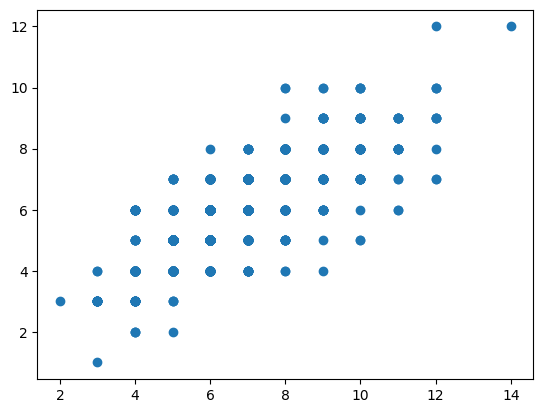

In [80]:
plt.plot(data_train['TotRmsAbvGrd'], data_train['BedroomAbvGr'] + data_train['KitchenAbvGr'] + data_train['FullBath'] + data_train['HalfBath'], 'o')

### It looks really correlated, I will think of it when I will build models

### As for *FullBath* and *BsmtFullBath* I will consider processing them into two different columns: *TotalBath* and maybe *IsBsmtBath* (the same for HalfBath). 

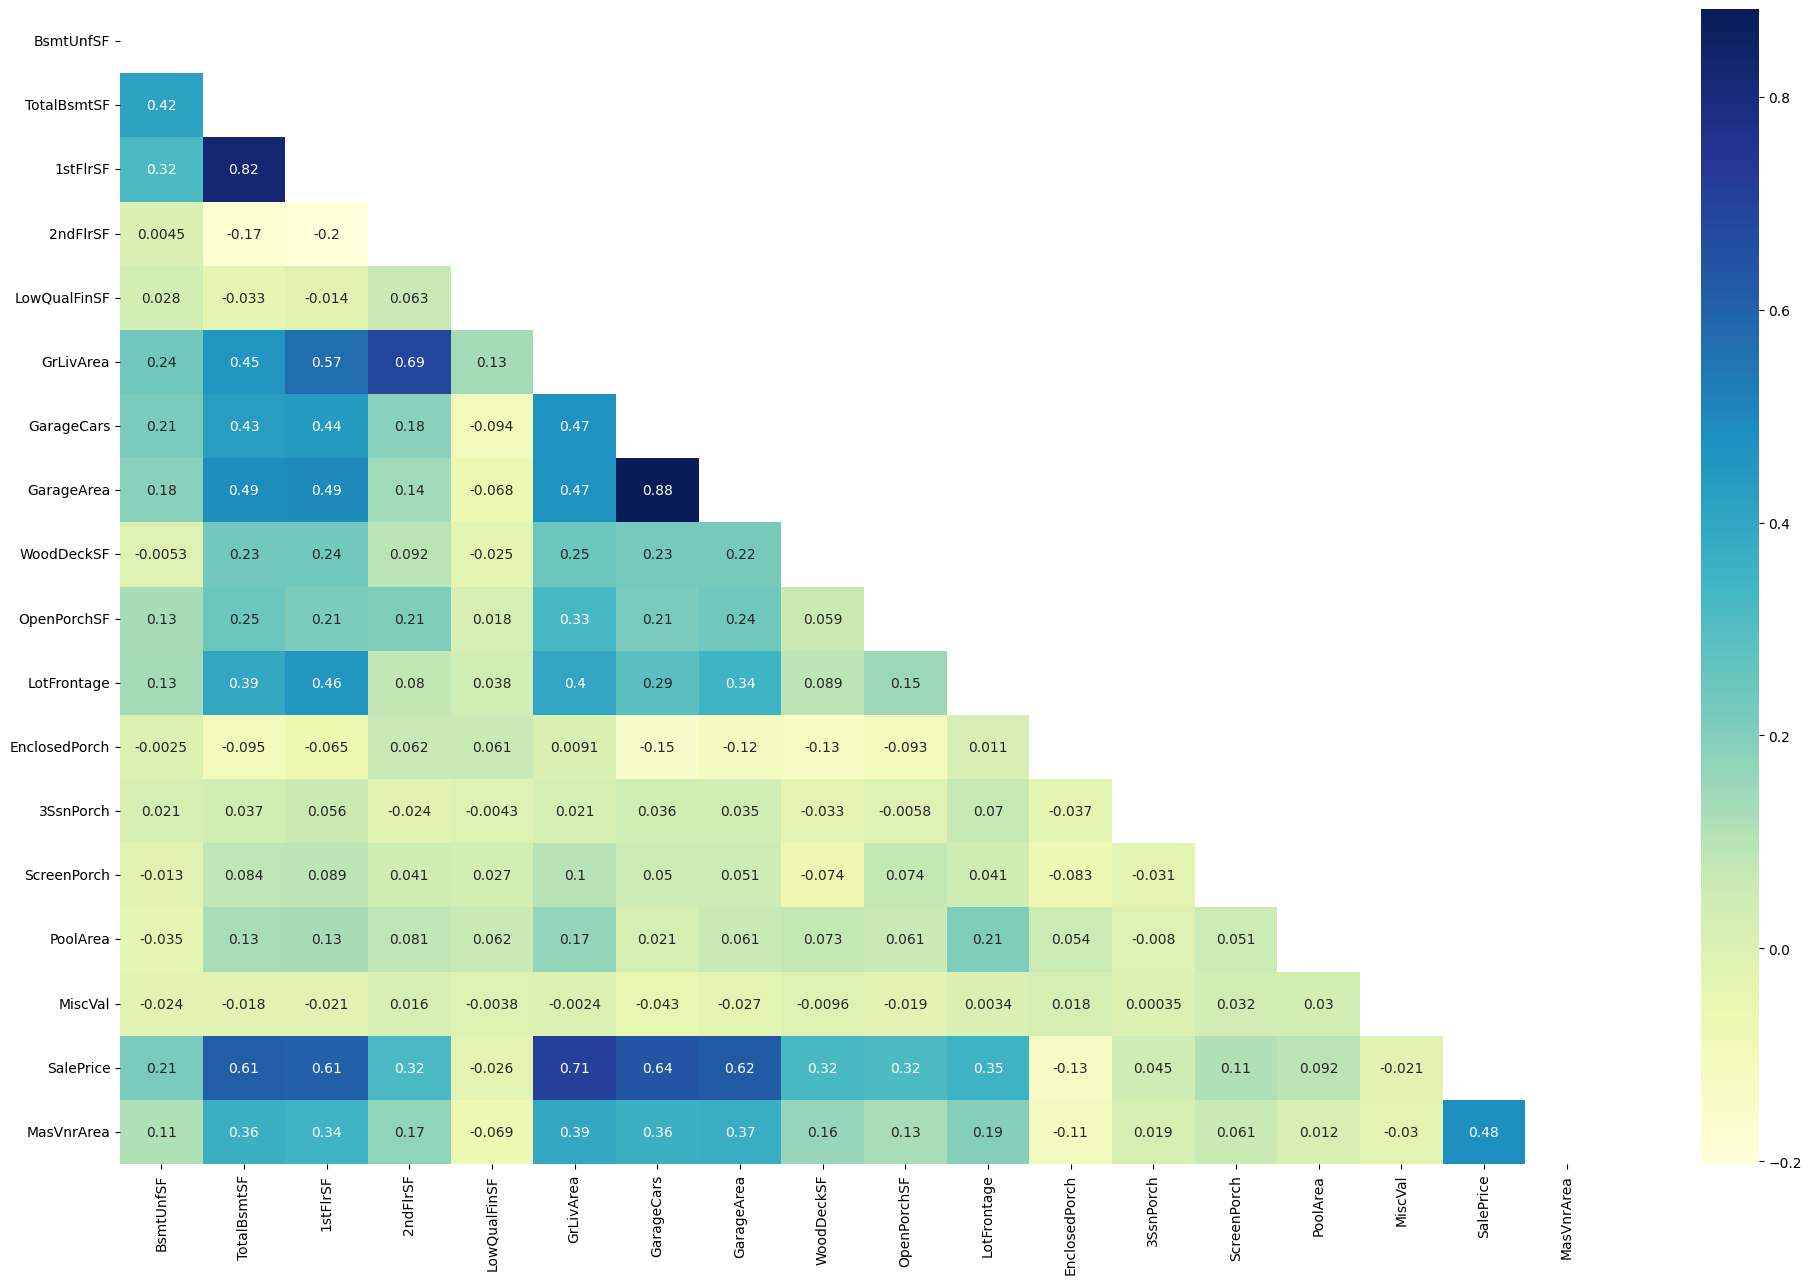

In [81]:
corr = data_train[measured_features].corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(24, 15))

dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True, mask=mask)
plt.show()

In [82]:
comparison = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
filtered_comp = comparison[comparison != 1]
filtered_comp[0:20]

GarageArea   GarageCars     0.882475
TotalBsmtSF  1stFlrSF       0.819530
GrLivArea    SalePrice      0.708624
2ndFlrSF     GrLivArea      0.687501
GarageCars   SalePrice      0.640409
GarageArea   SalePrice      0.623431
SalePrice    TotalBsmtSF    0.613581
             1stFlrSF       0.605852
GrLivArea    1stFlrSF       0.566024
1stFlrSF     GarageArea     0.489782
GarageArea   TotalBsmtSF    0.486665
MasVnrArea   SalePrice      0.477493
GarageArea   GrLivArea      0.468997
GrLivArea    GarageCars     0.467247
LotFrontage  1stFlrSF       0.457181
TotalBsmtSF  GrLivArea      0.454868
1stFlrSF     GarageCars     0.439317
TotalBsmtSF  GarageCars     0.434585
             BsmtUnfSF      0.415360
LotFrontage  GrLivArea      0.402797
dtype: float64

### Some of the features has to be either removed or merged as some correlations are really high

In [83]:
# Dont use the code below, not readable and time some time to render
# sns.pairplot(numerical_features, corner=True)

### Maybe *GrLivArea* is the sum of *1stFlrSf* and *2ndFlrSF*?

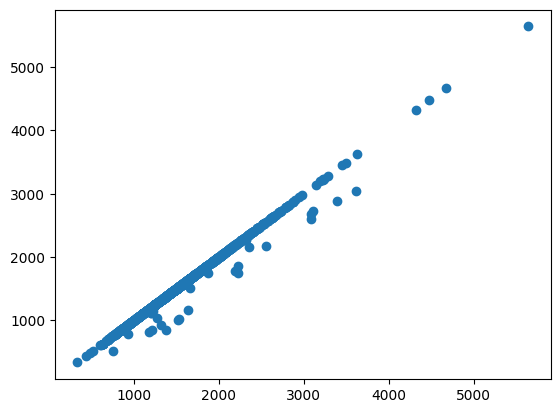

In [84]:
plt.plot(data_train['GrLivArea'], data_train['1stFlrSF'] + data_train['2ndFlrSF'], 'o')

### I will remove GrLivArea in favour of 1stFlorSF and 2ndFlrSF

### I will also remove TotalBsmtSF as it looks as if it was equal to 1stFlrFT  

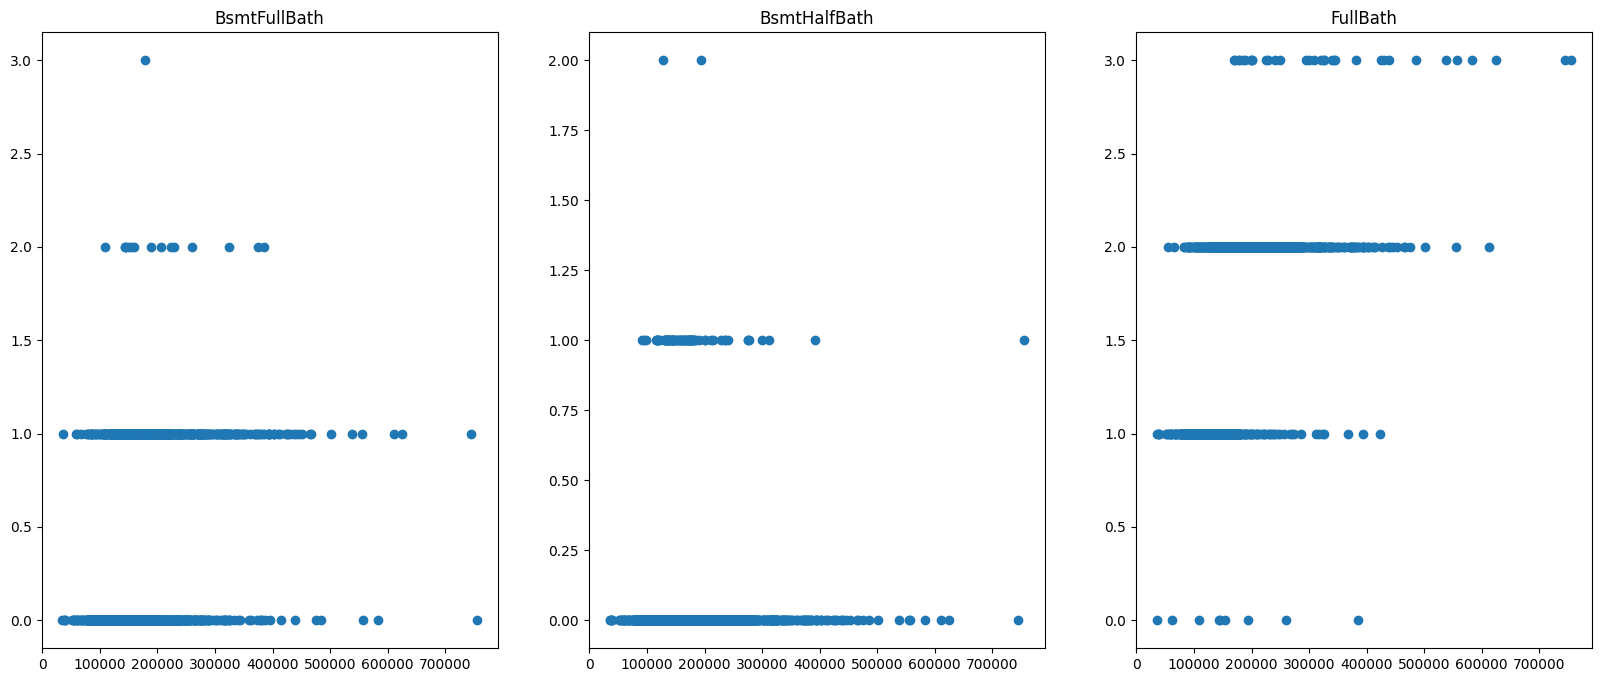

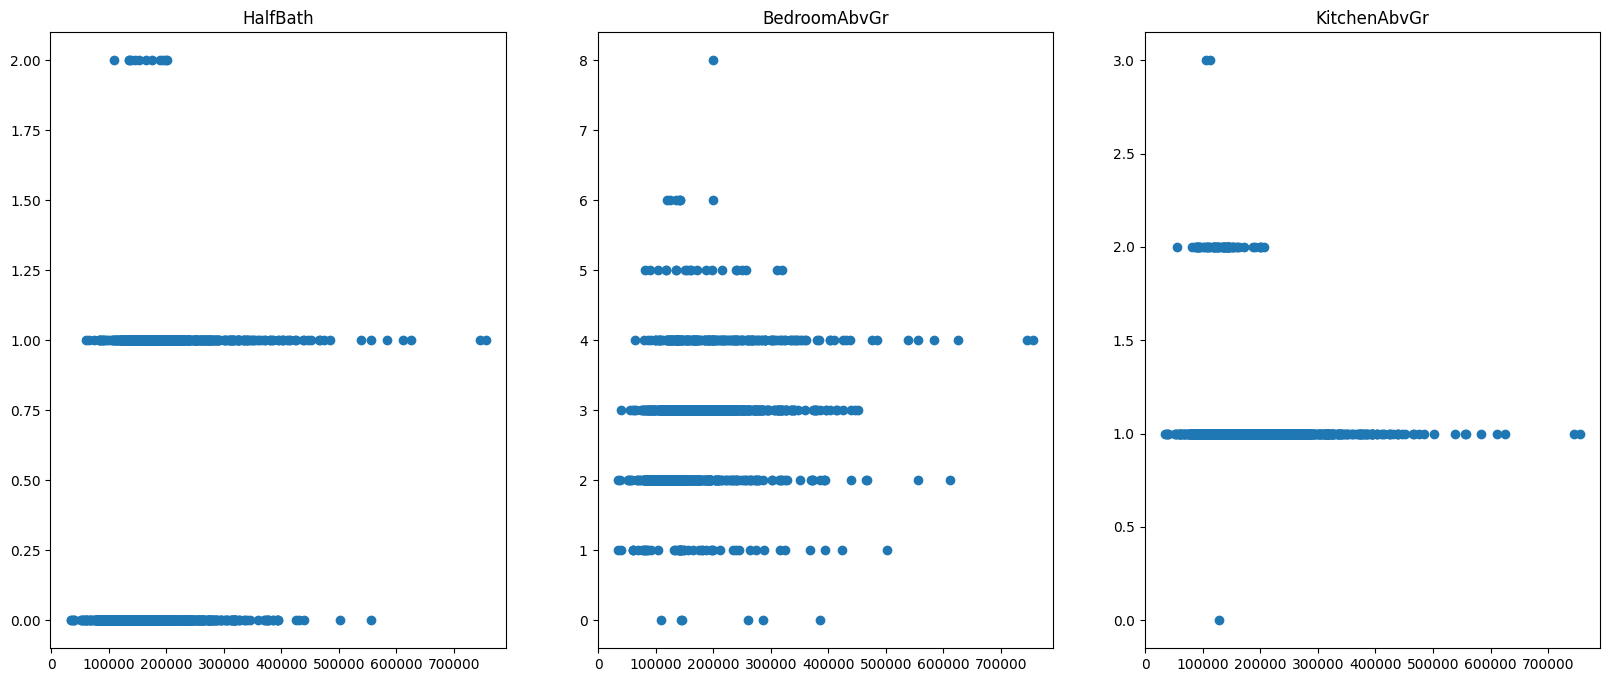

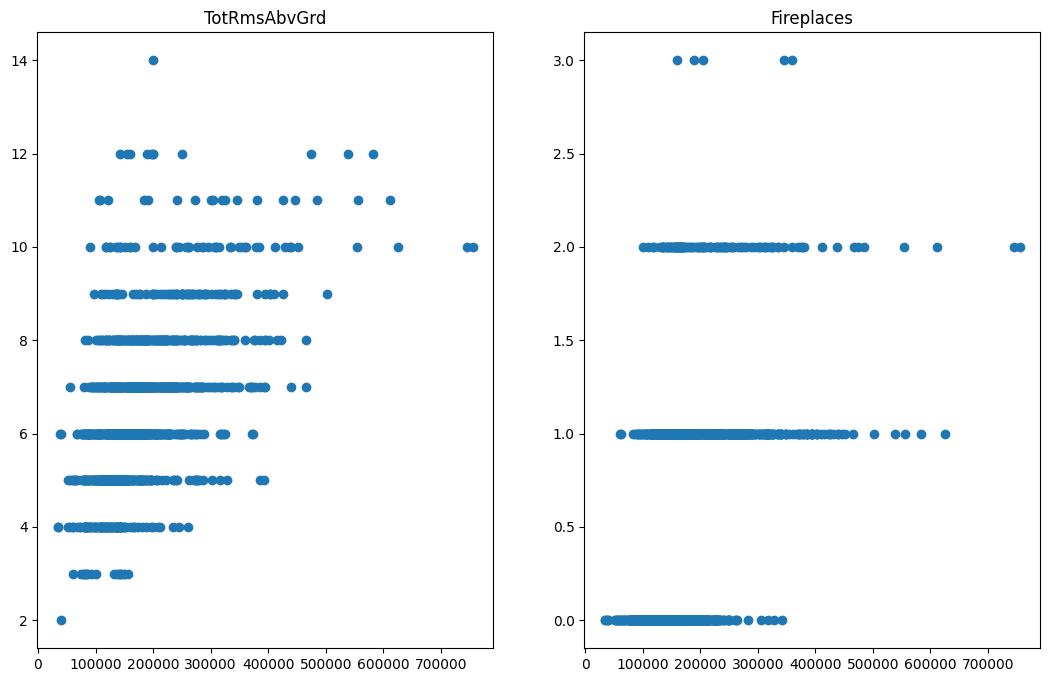

In [85]:
for i in range(len(count_features)):
    # draw 3 plots in one row
    if i % 3 == 0:
        plt.figure(figsize=(20, 8))

    plt.subplot(1, 3, (i % 3) + 1)
    plt.plot(data_train['SalePrice'], data_train[count_features[i]], 'o')
    plt.title(count_features[i])

    if (i % 3) == 2 | i == len(count_features) - 1:
        print("SHOW", i)
        plt.show()

### Plots above show nothing... apart from the fact that 'more' does not mean 'better' (when it comes to SalePrice)

In [86]:
measured_features_copy = list(measured_features)
measured_features_copy.remove('GrLivArea')
measured_features_copy.remove('TotalBsmtSF')

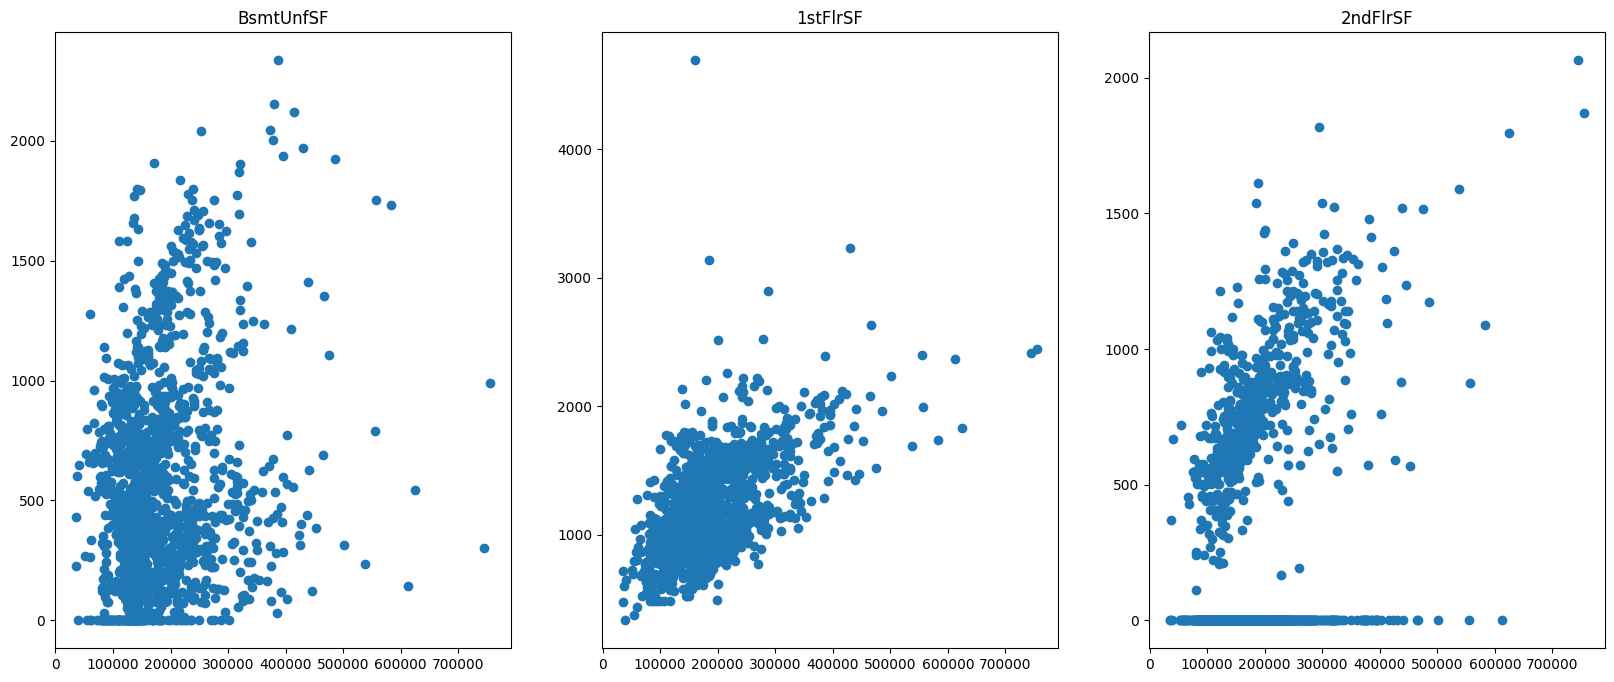

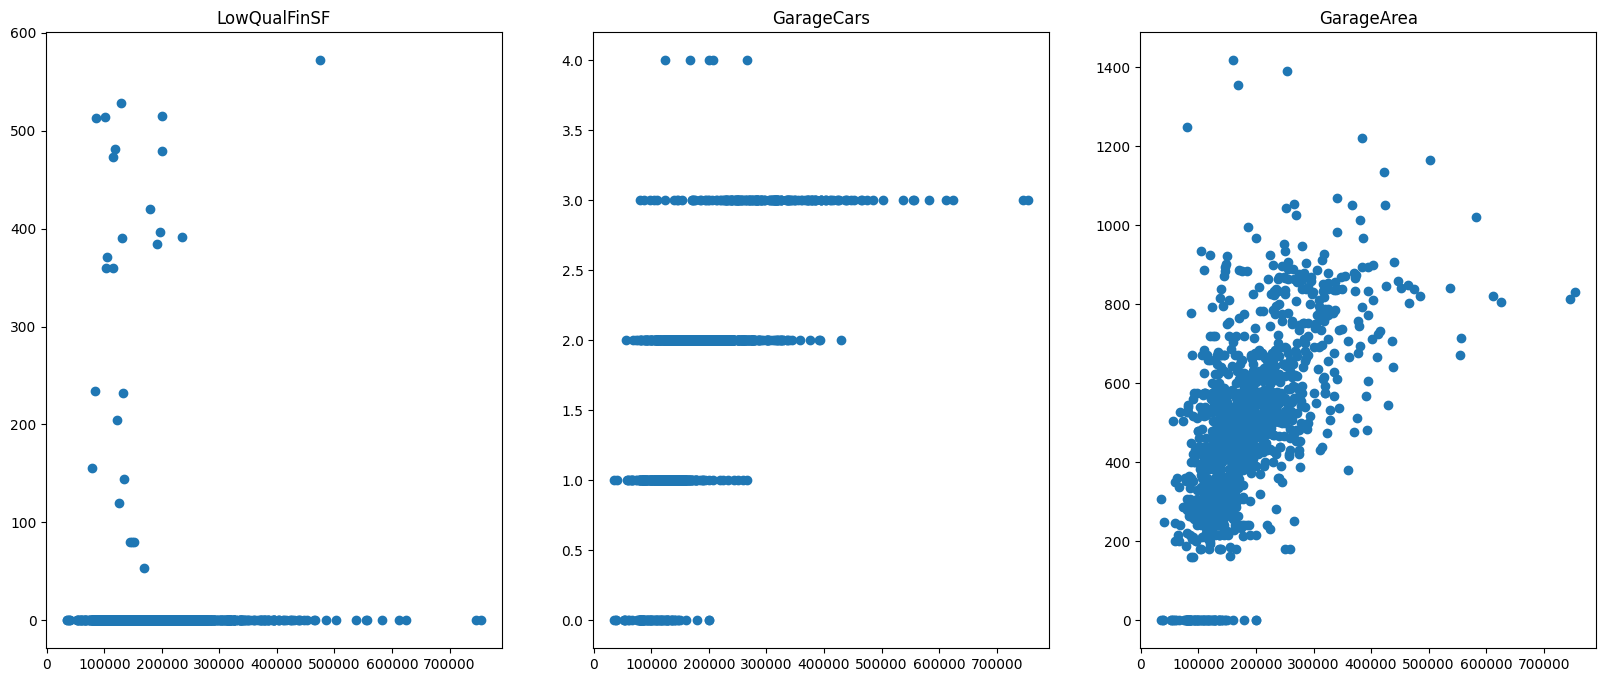

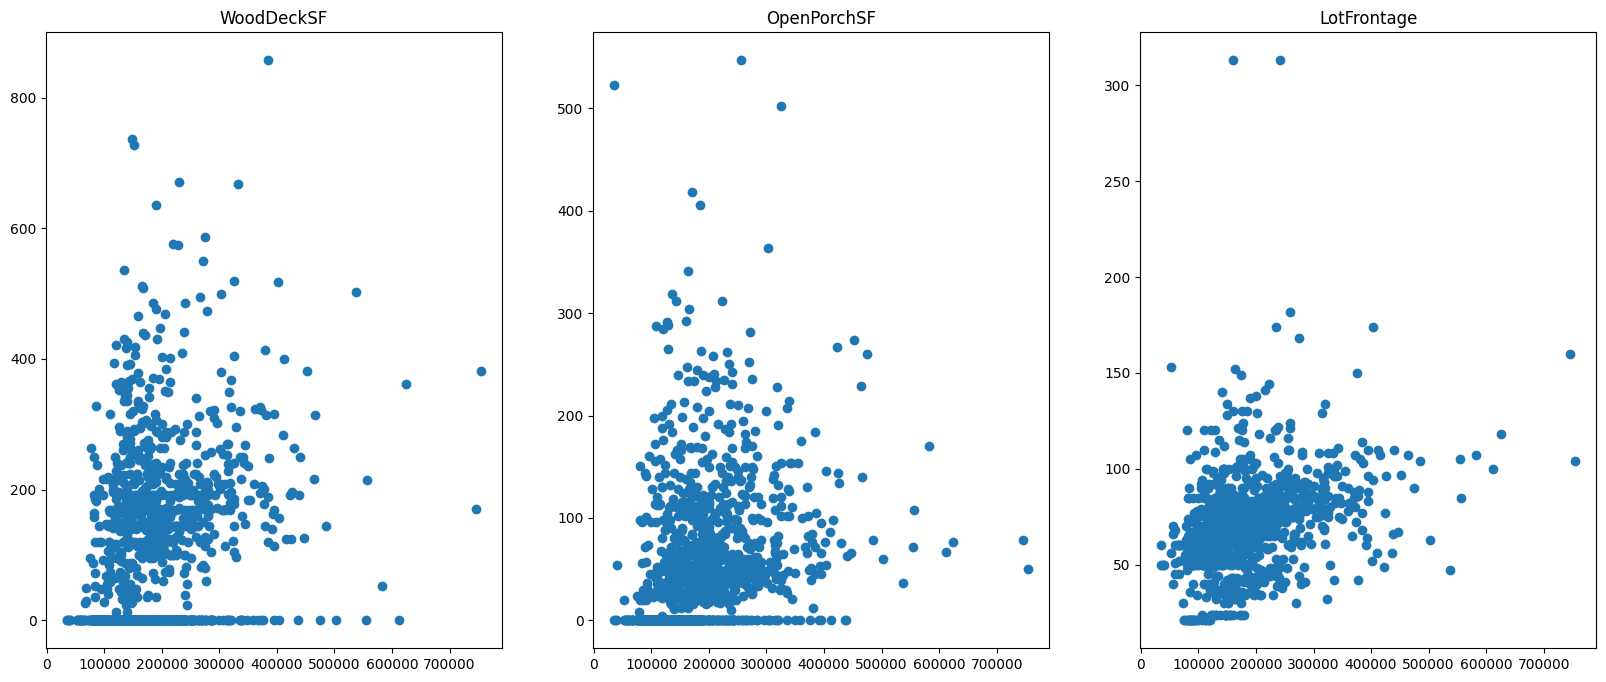

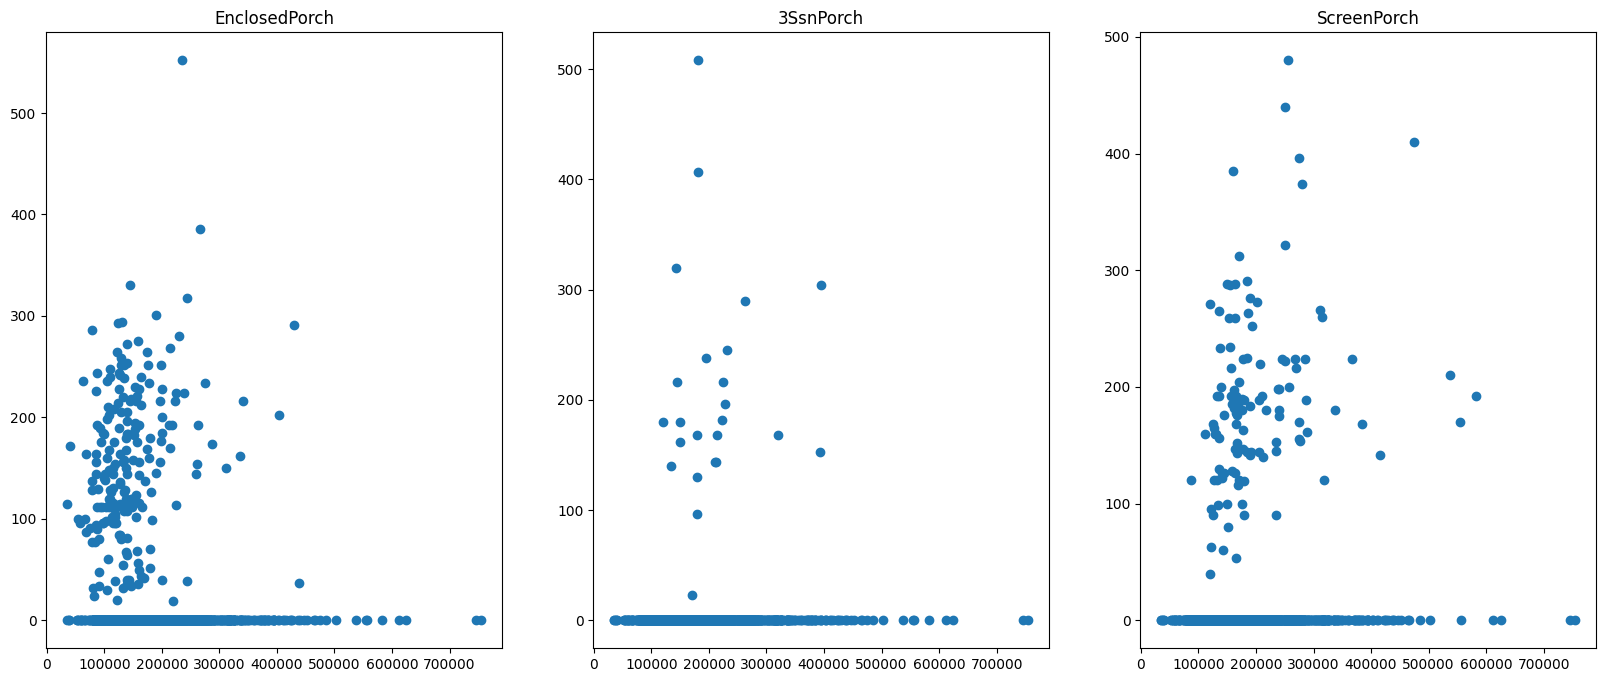

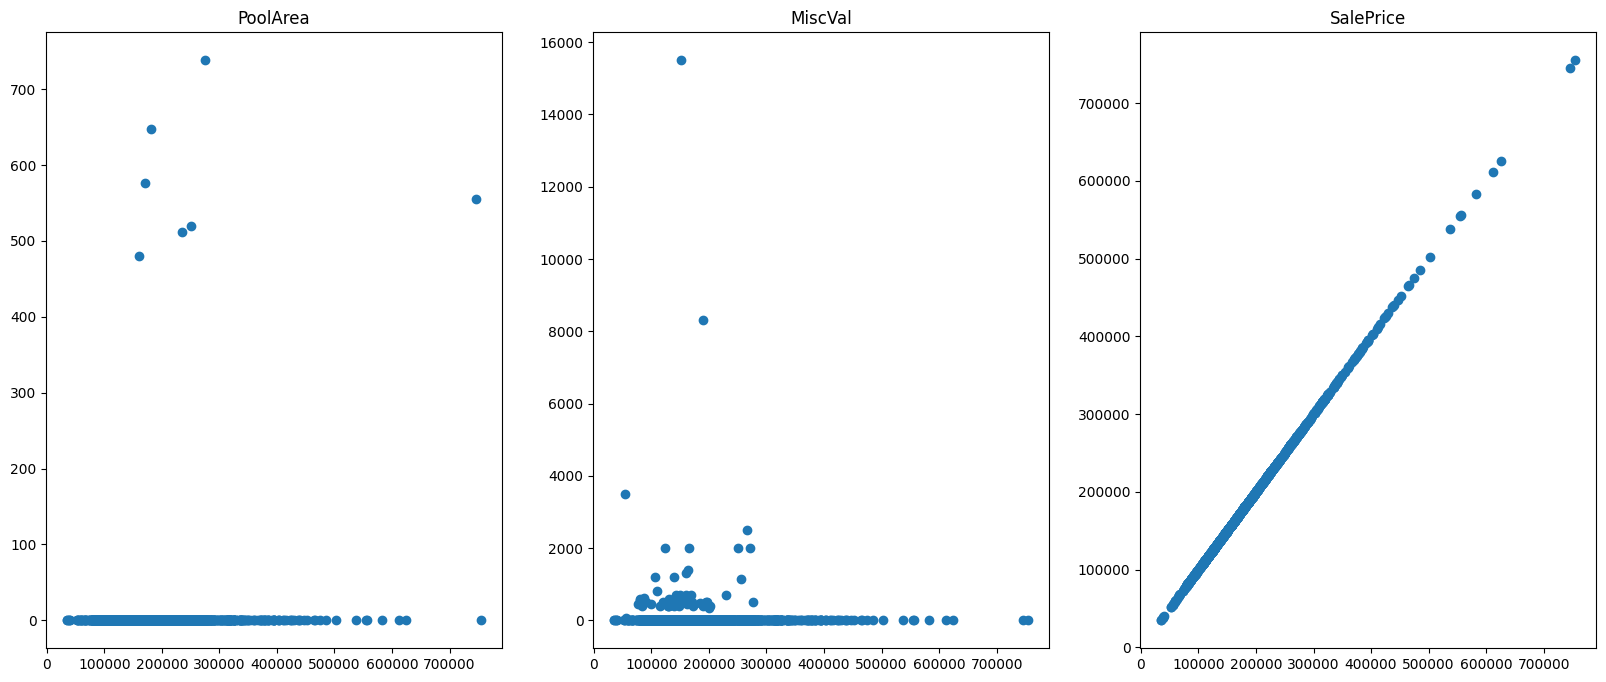

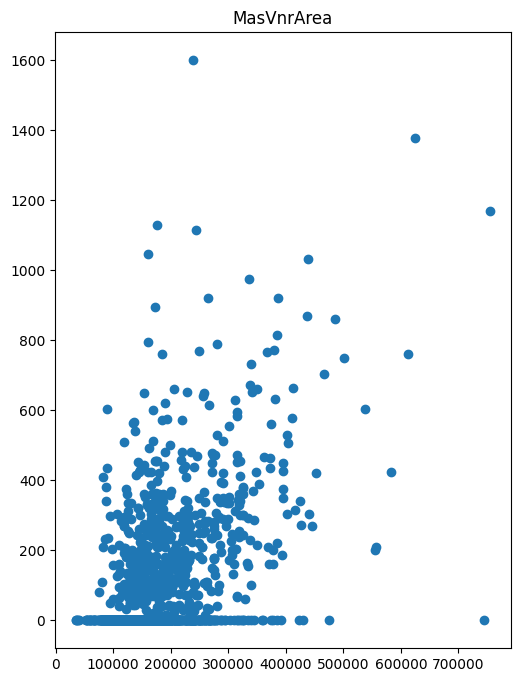

In [87]:
for i in range(len(measured_features_copy)):
    # draw 3 plots in one row
    if i % 3 == 0:
        plt.figure(figsize=(20, 8))

    plt.subplot(1, 3, (i % 3) + 1)
    plt.plot(data_train['SalePrice'], data_train[measured_features_copy[i]], 'o')
    plt.title(measured_features_copy[i])

    if (i % 3) == 2 | i == len(count_features) - 1:
        print("SHOW", i)
        plt.show()

#### In some houses lack of 2nd floor disrupt the linearity. Because of that I will create variable *is2ndFlr*, remove *1stFlrFT*, *2ndFlrFT* and keep *GrdLivArea*.
#### Lack of garage also may disrupt linearity. Maybe I will sum it with GrdLivArea and create variable *isGarage*?

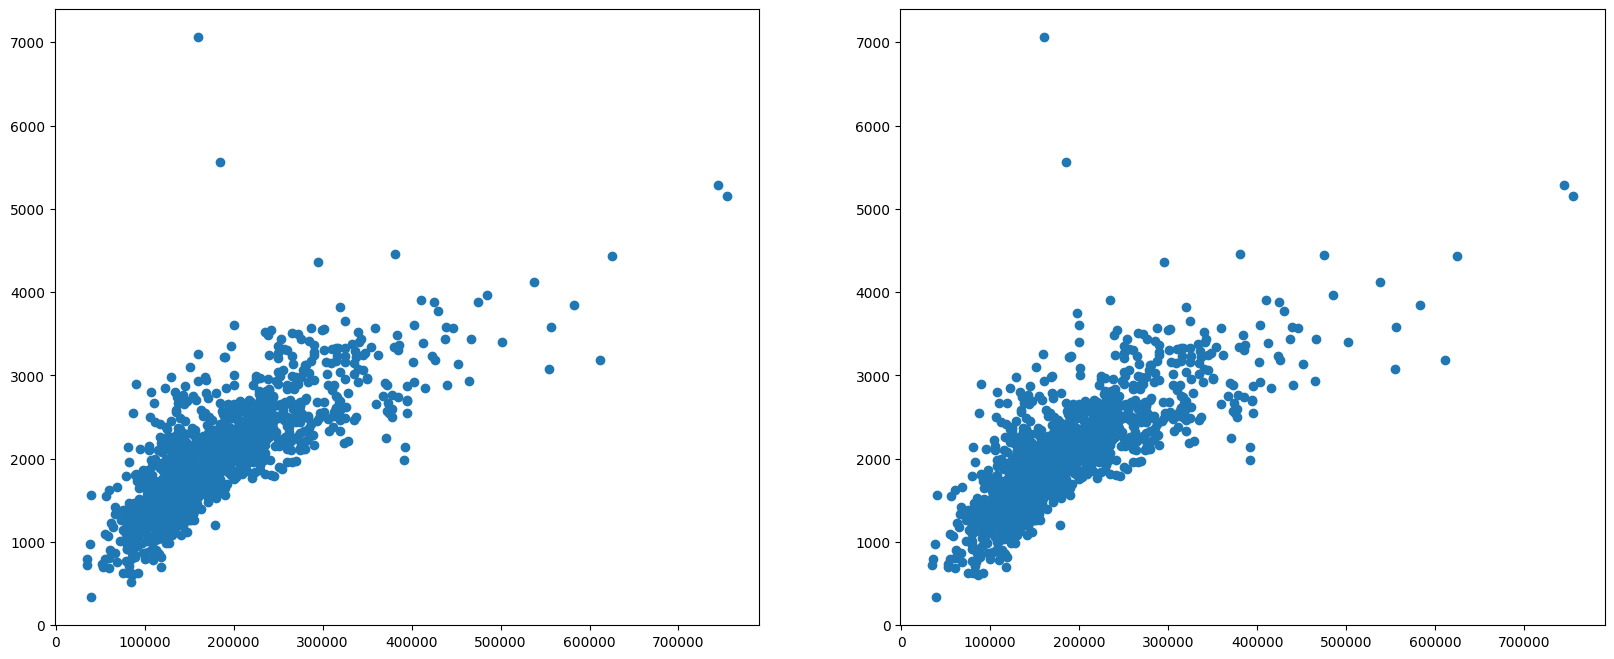

In [88]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(data_train['SalePrice'], data_train['1stFlrSF'] + data_train['2ndFlrSF'] + data_train['GarageArea'], 'o')
plt.subplot(1, 2, 2)
plt.plot(data_train['SalePrice'], data_train['GrLivArea'] + data_train['GarageArea'], 'o')

### Other "measured" features that I do not consider: I think they say too little to include them.

#### To sum up, below is the function how I will process numerical variables

In [89]:
numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [90]:
other_num = ['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

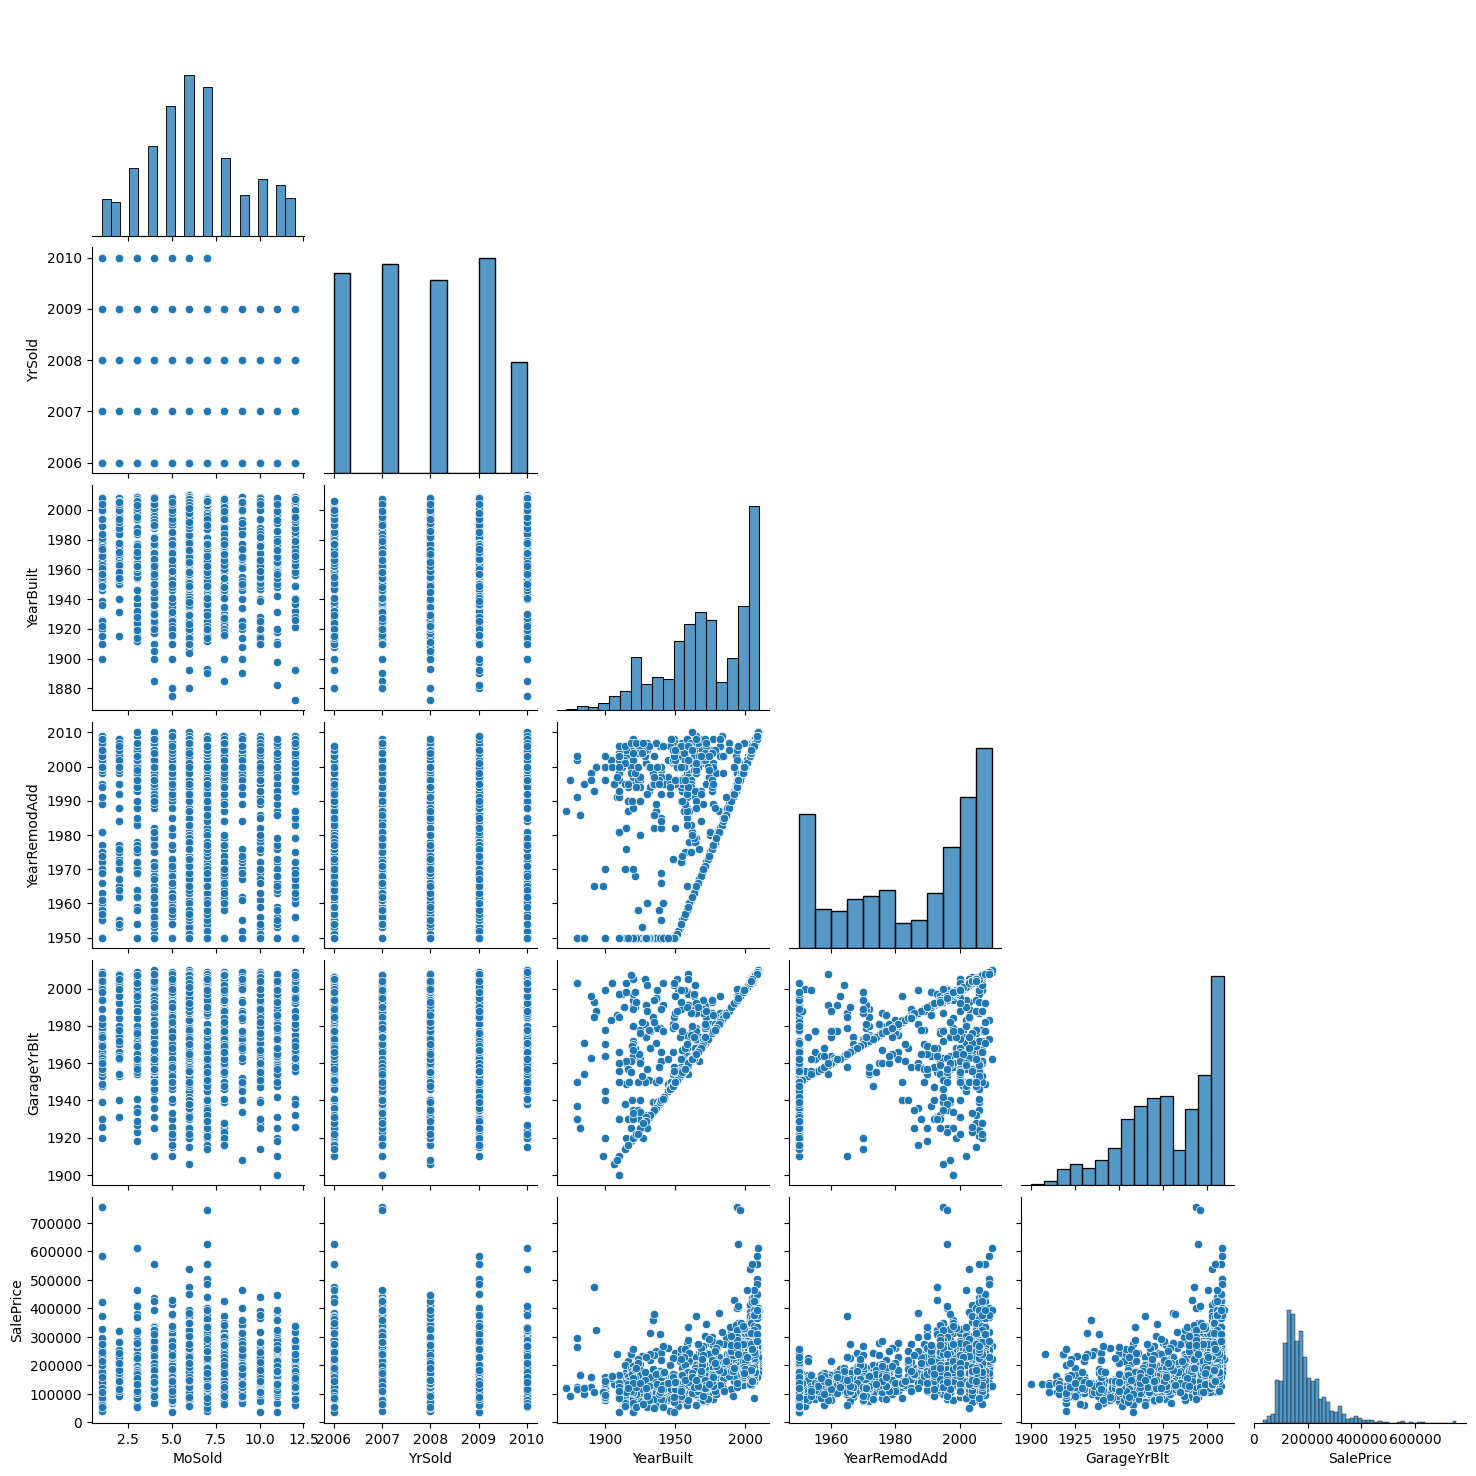

In [91]:
sns.pairplot(data_train[other_num + ['SalePrice']], corner=True)

In [92]:
data_train[other_num + ['SalePrice']].corr()

MoSold    YrSold  YearBuilt  YearRemodAdd  GarageYrBlt  \
MoSold        1.000000 -0.145721   0.012398      0.021490     0.005337   
YrSold       -0.145721  1.000000  -0.013618      0.035743    -0.001014   
YearBuilt     0.012398 -0.013618   1.000000      0.592855     0.825667   
YearRemodAdd  0.021490  0.035743   0.592855      1.000000     0.642277   
GarageYrBlt   0.005337 -0.001014   0.825667      0.642277     1.000000   
SalePrice     0.046432 -0.028923   0.522897      0.507101     0.486362   

              SalePrice  
MoSold         0.046432  
YrSold        -0.028923  
YearBuilt      0.522897  
YearRemodAdd   0.507101  
GarageYrBlt    0.486362  
SalePrice      1.000000

### MoSold, YrSold - useless
### GarageYrBlt - Similarly connected with YearBuild like YearRemodAdd

###  What about max(YearBuild, YearRemodAdd)?

In [93]:
from scipy.stats import pearsonr
pearsonr(data_train['SalePrice'], data_train[['YearBuilt', 'YearRemodAdd']].max(axis=1))

PearsonRResult(statistic=0.5071009671113863, pvalue=3.1649482419200737e-96)

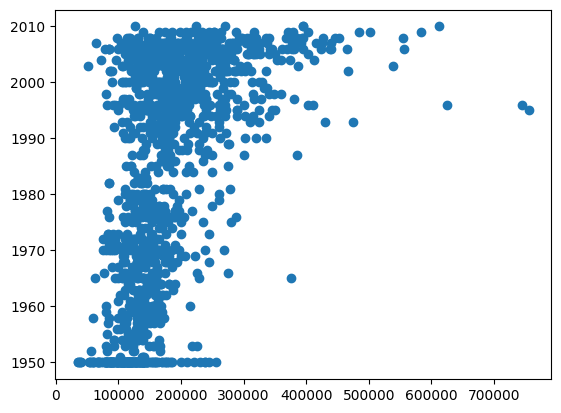

In [94]:
import math

plt.plot(data_train['SalePrice'], data_train[['YearBuilt', 'YearRemodAdd']].max(axis=1), 'o')

### The correlation did not improve. Maybe I will only check whether Building was remodeled and then drop *YearRemodAdd*

### To sum up examining numerical features, I wuold, at this moment, preprocess them like in the function below:

In [95]:
import math

def adjustNumerical(data):
    copy = data.copy()
    # convert MSSubClass to categorical as it is probably not ordinal
    copy['MSSubClass'] = copy['MSSubClass'].apply(lambda x: x if math.isnan(x) else f'c_{x}')
    # convert OveralCond to categorical as it is probably not ordinal (it should be ordinal but but SalePrice does not increase as OveralQual increase)
    copy['OverallCond'] = copy['OverallCond'].apply(lambda x: x if math.isnan(x) else f'c_{x}')

    copy.drop(columns='BedroomAbvGr', inplace=True)
    
    copy['TotalSqrFt'] = copy['GrLivArea'] + copy['GarageArea']
    copy['isGarage'] = copy['GarageArea'].apply(lambda x: x if math.isnan(x) else (1 if x > 0 else 0))
    copy['is2ndFlr'] = copy['2ndFlrSF'].apply(lambda x: x if math.isnan(x) else (1 if x > 0 else 0))

    copy.drop(columns=['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'])

    copy['WasRemod'] = copy['YearRemodAdd'].apply(lambda x: x if math.isnan(x) else (1 if x > 0 else 0))
    copy.drop(columns=['YearRemodAdd', 'MoSold'], inplace=True)

    return copy
    
    

### Examining categorical features

In [96]:
data_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [97]:
categorical_features = data_train.select_dtypes(include=[object, bool])
categorical_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### As I said earlier some features has to be removed right now as over 90% of the values are missing

In [98]:
missings = data_train.isna().sum().to_frame()
missings[missings[0]/len(data_train) >= 0.90]

0
Alley        1369
PoolQC       1453
MiscFeature  1406

In [99]:
categorical_features.drop(columns=['Alley', 'PoolQC', 'MiscFeature'], inplace=True)

In [100]:
scrollable_dataframe(categorical_features.describe().T)

Similarly (like with missing values) I will remove features which top's value is more frequent than in 90% of observations

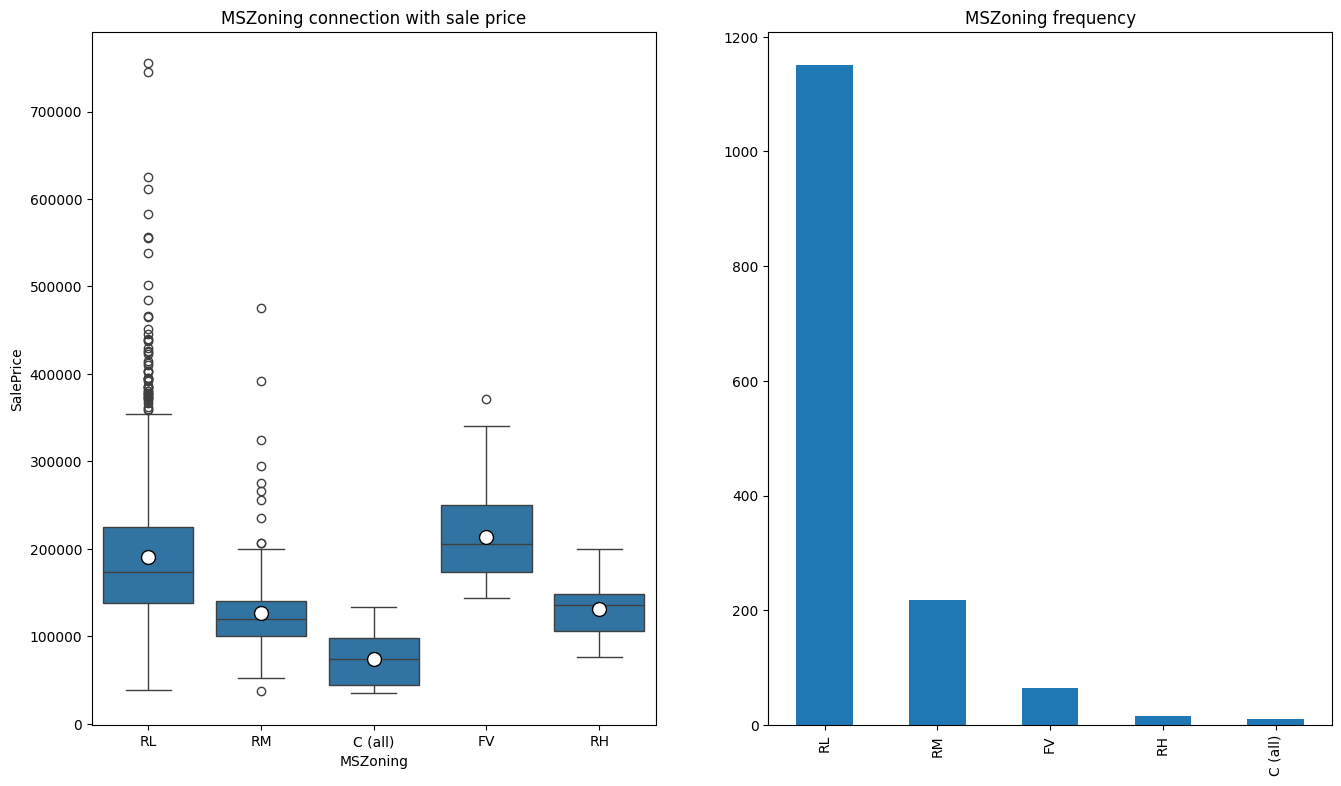

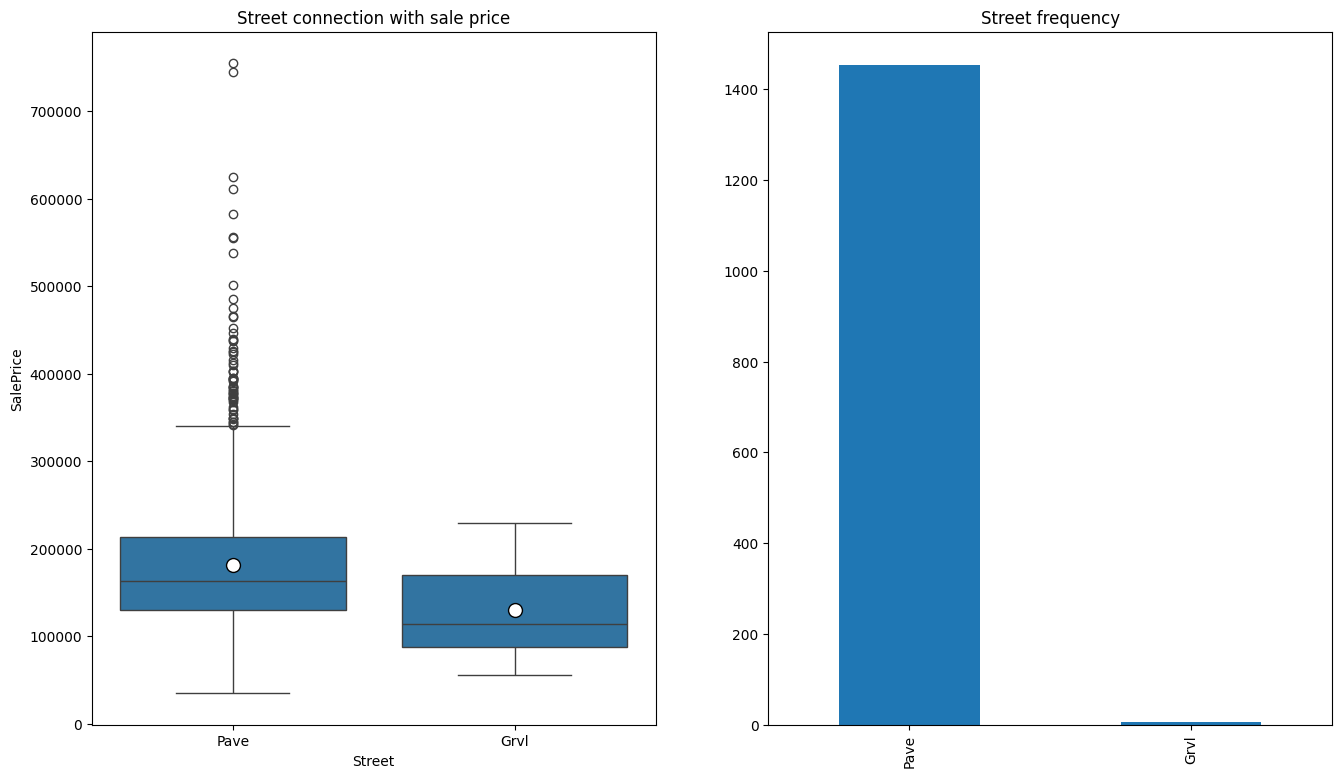

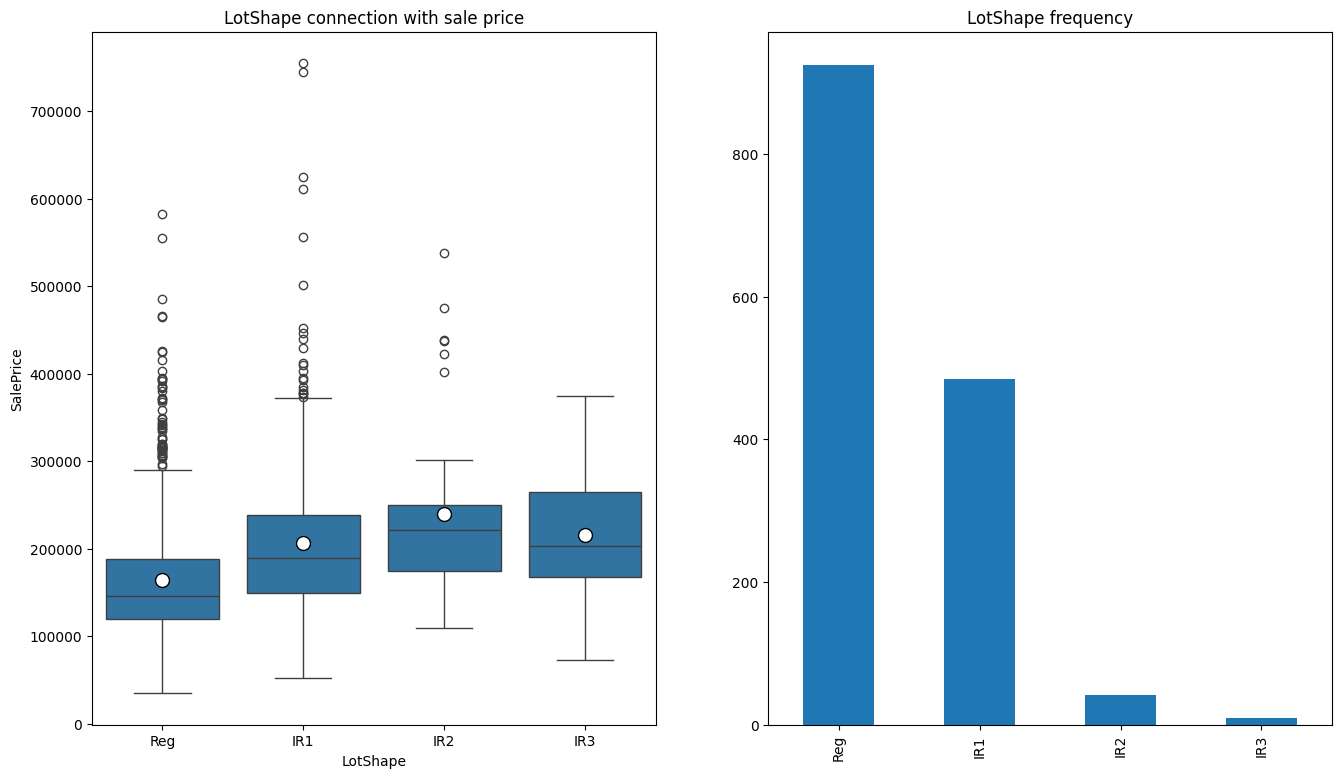

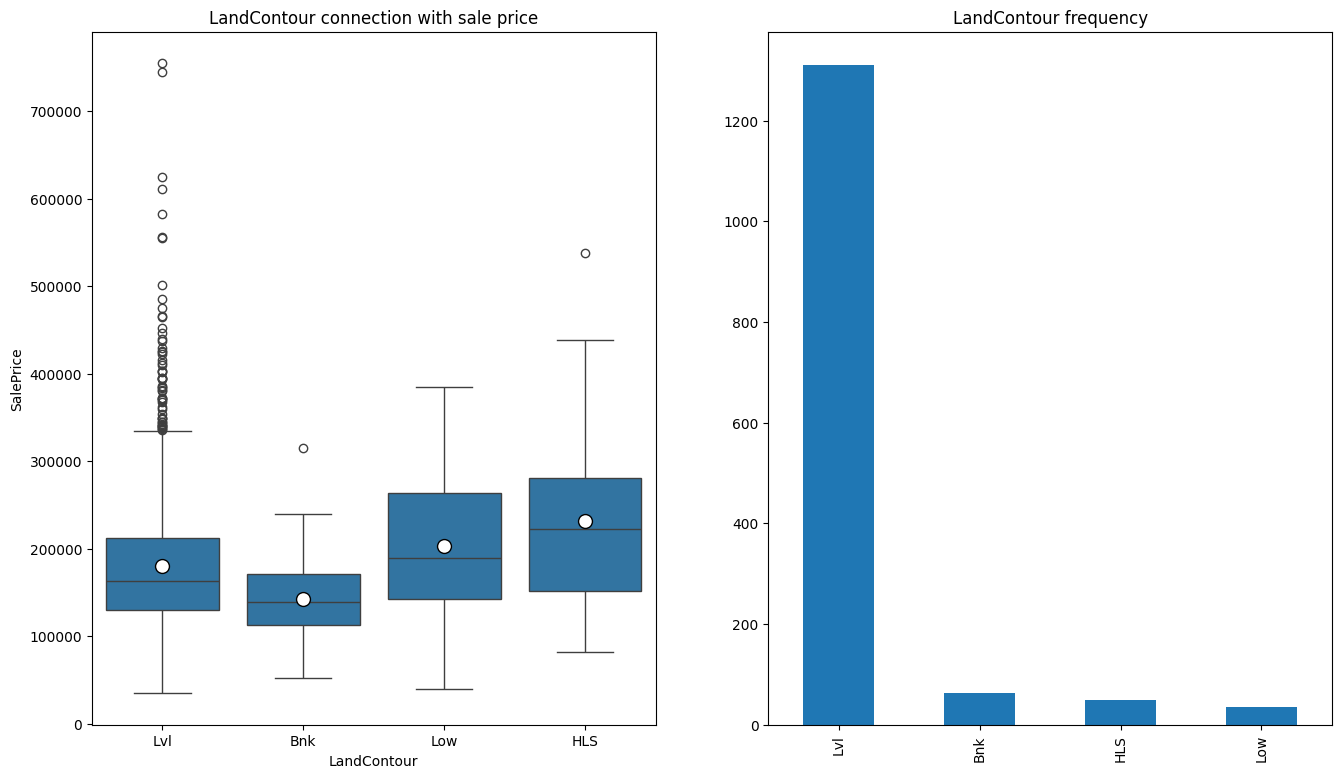

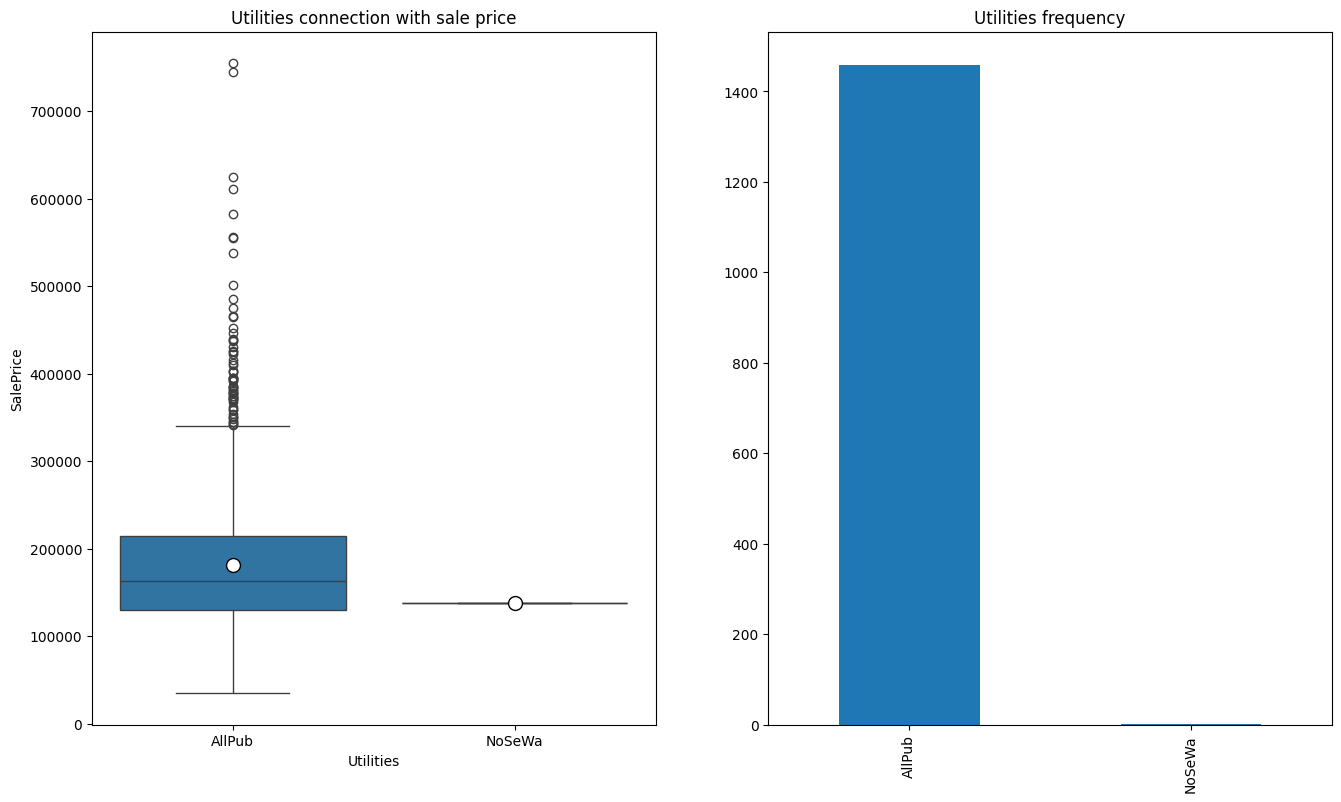

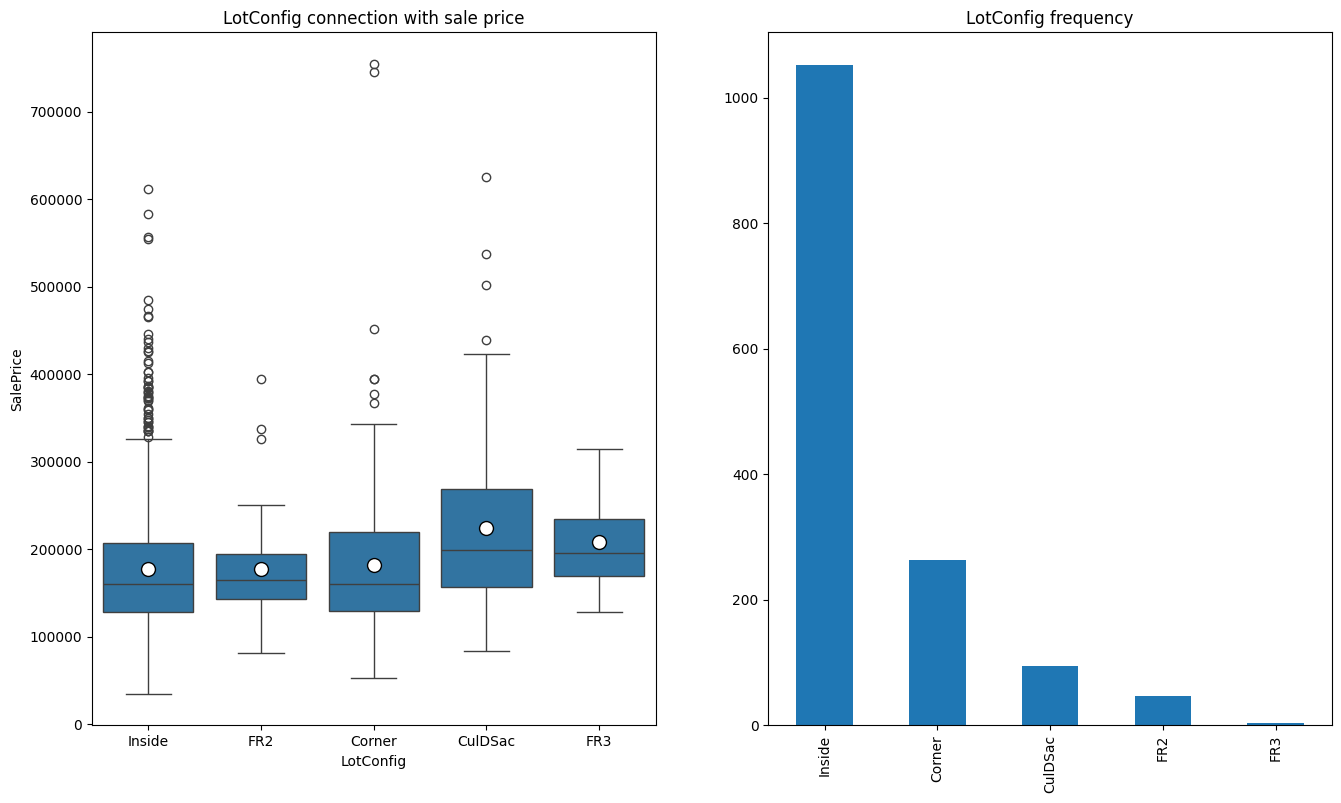

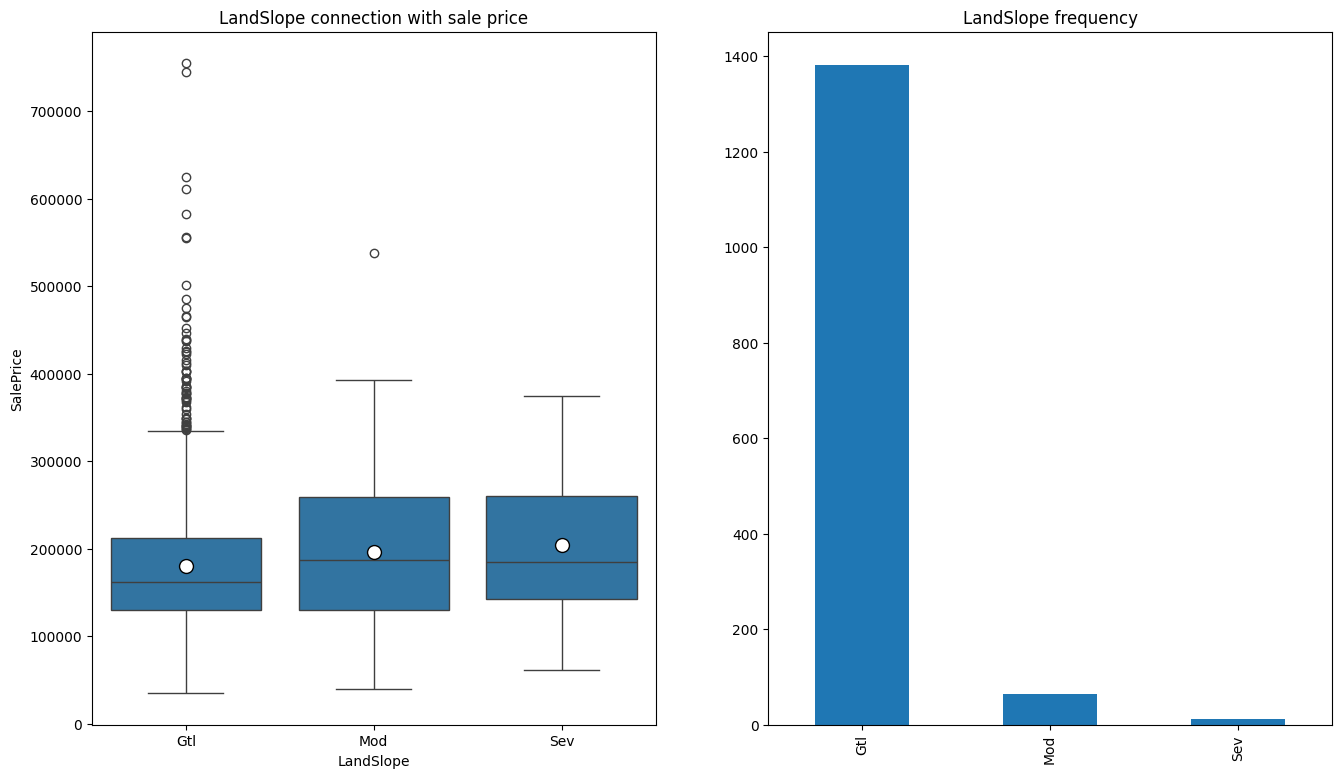

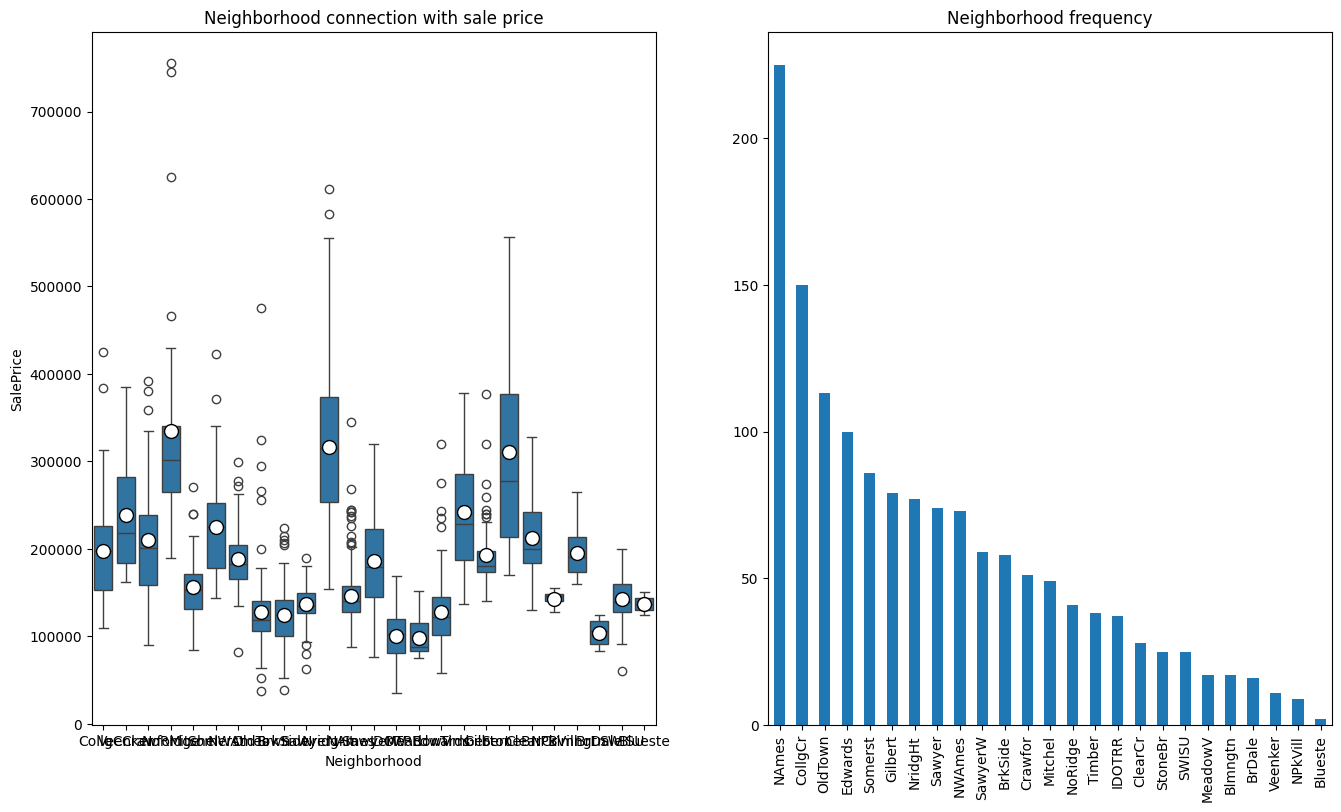

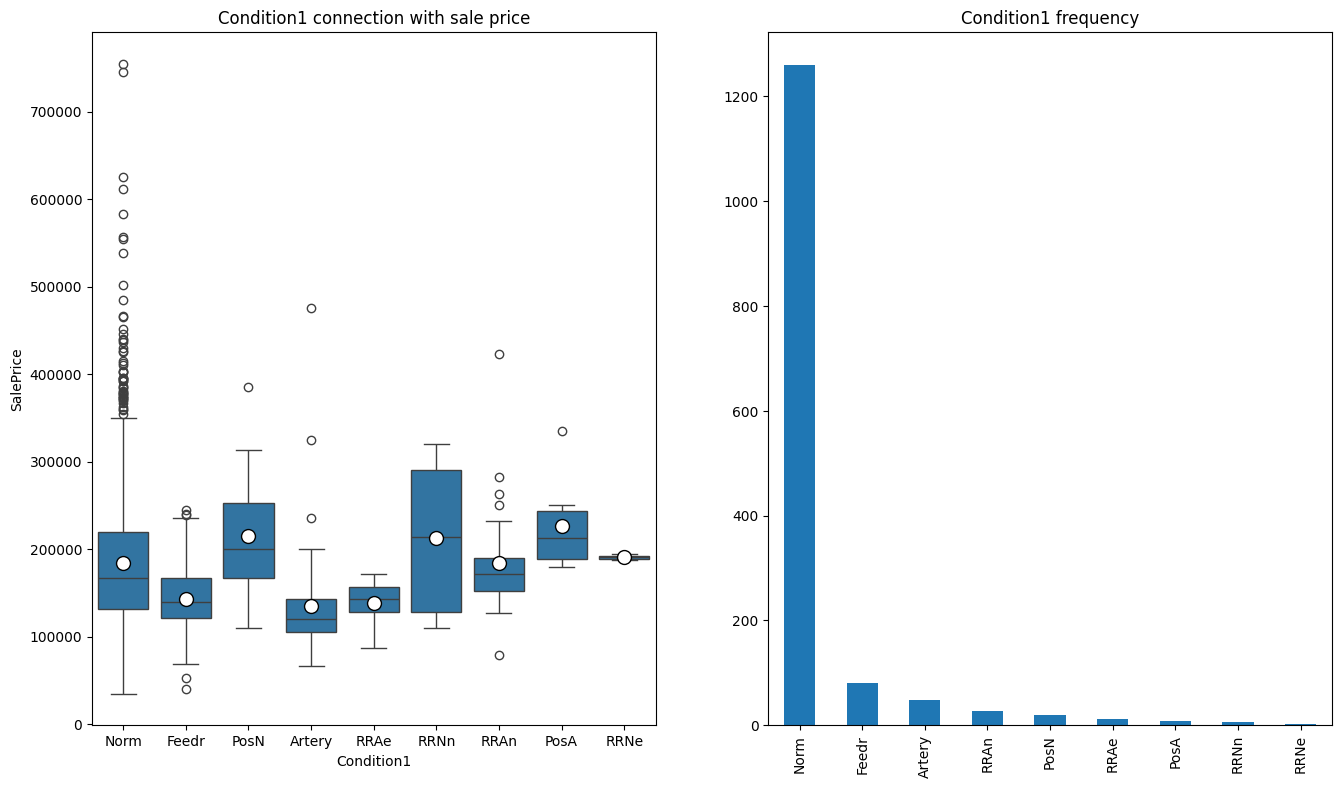

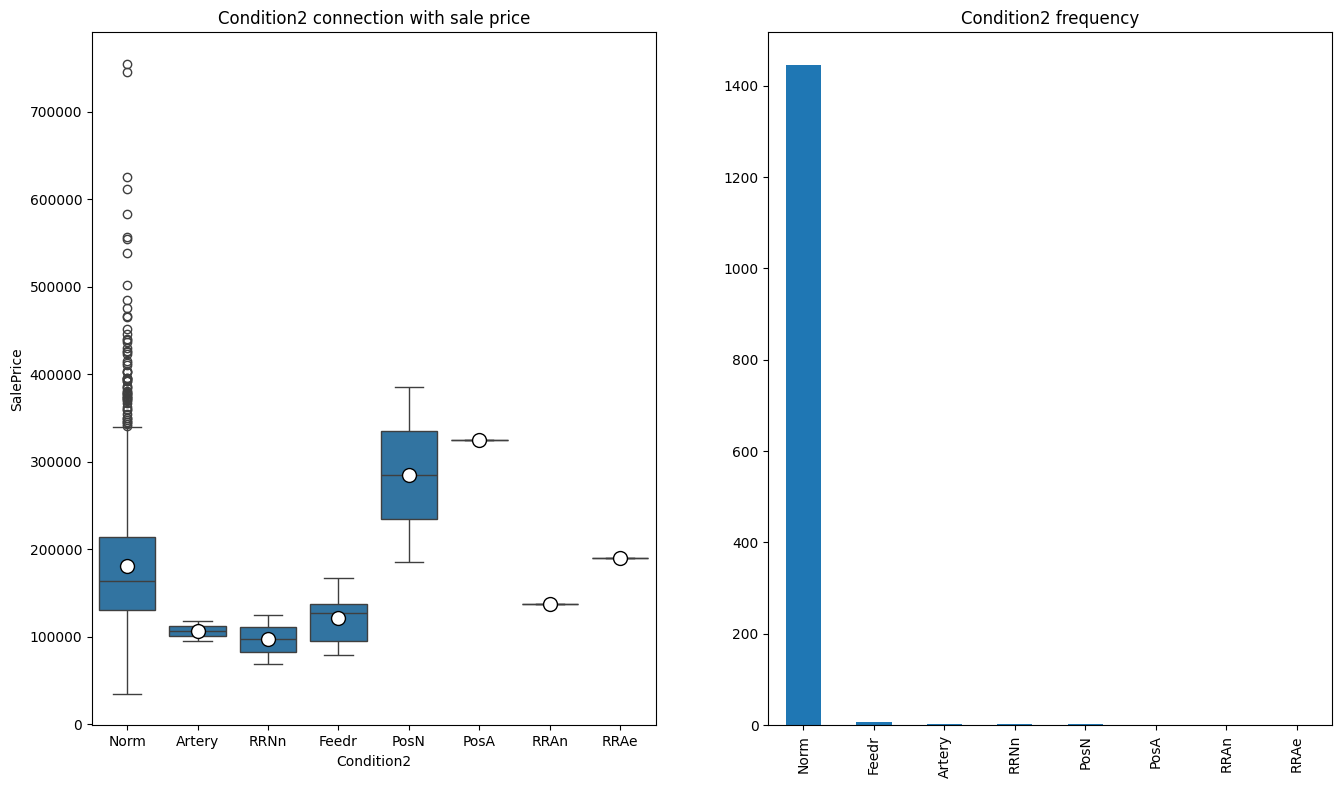

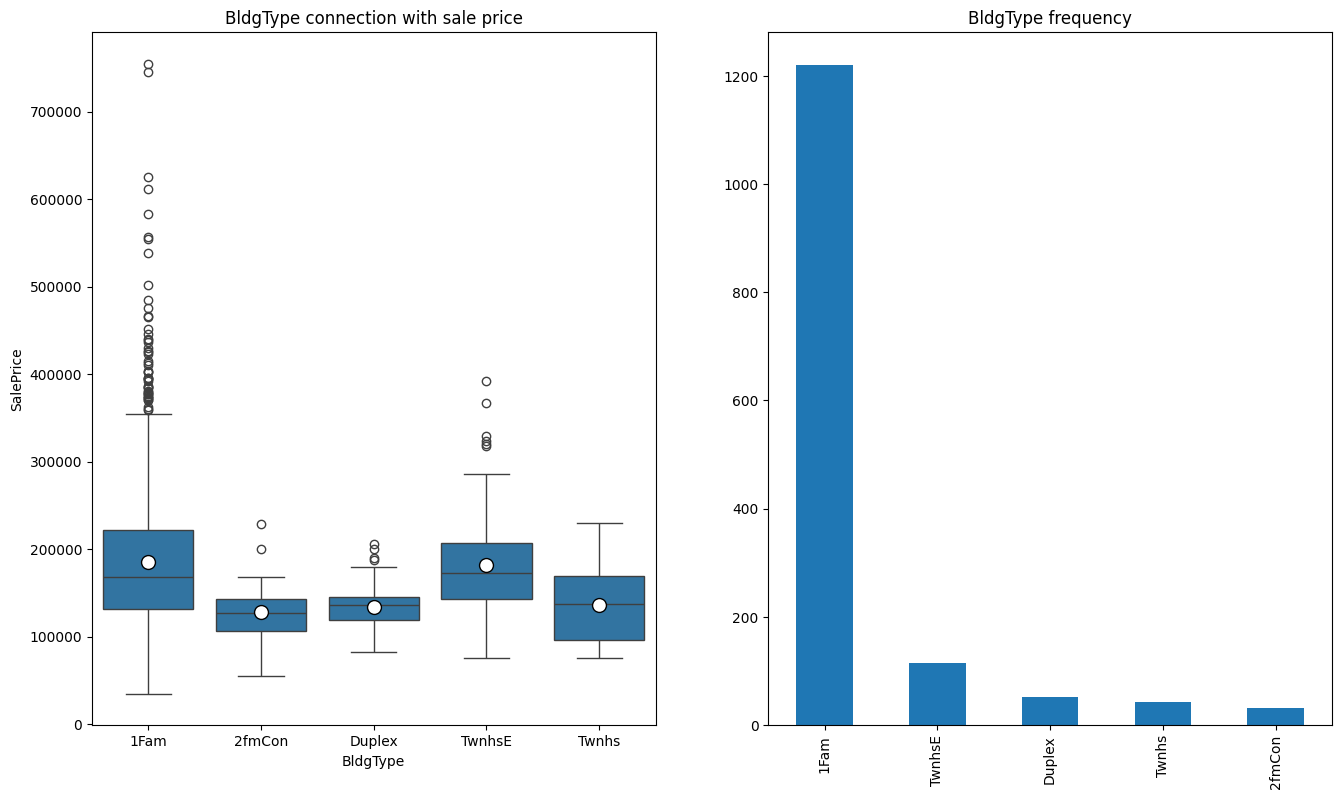

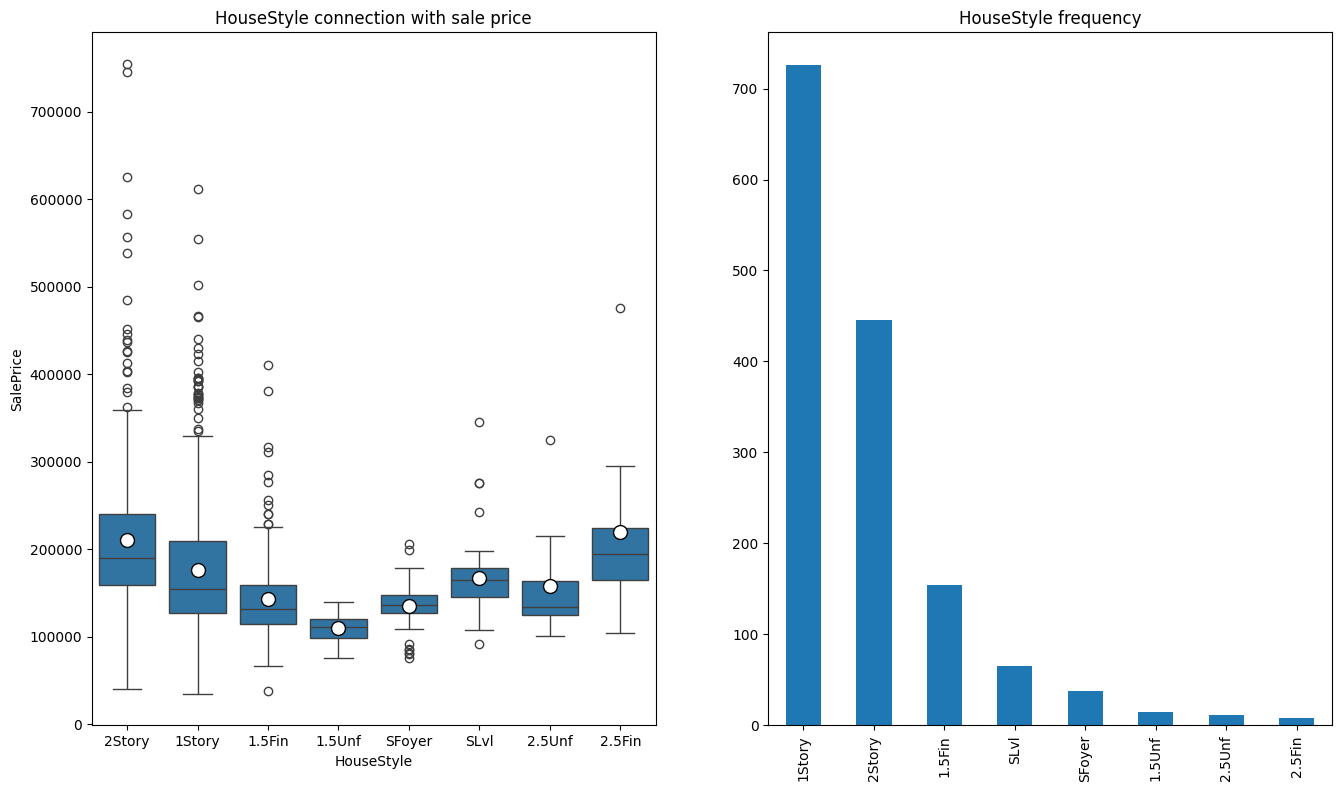

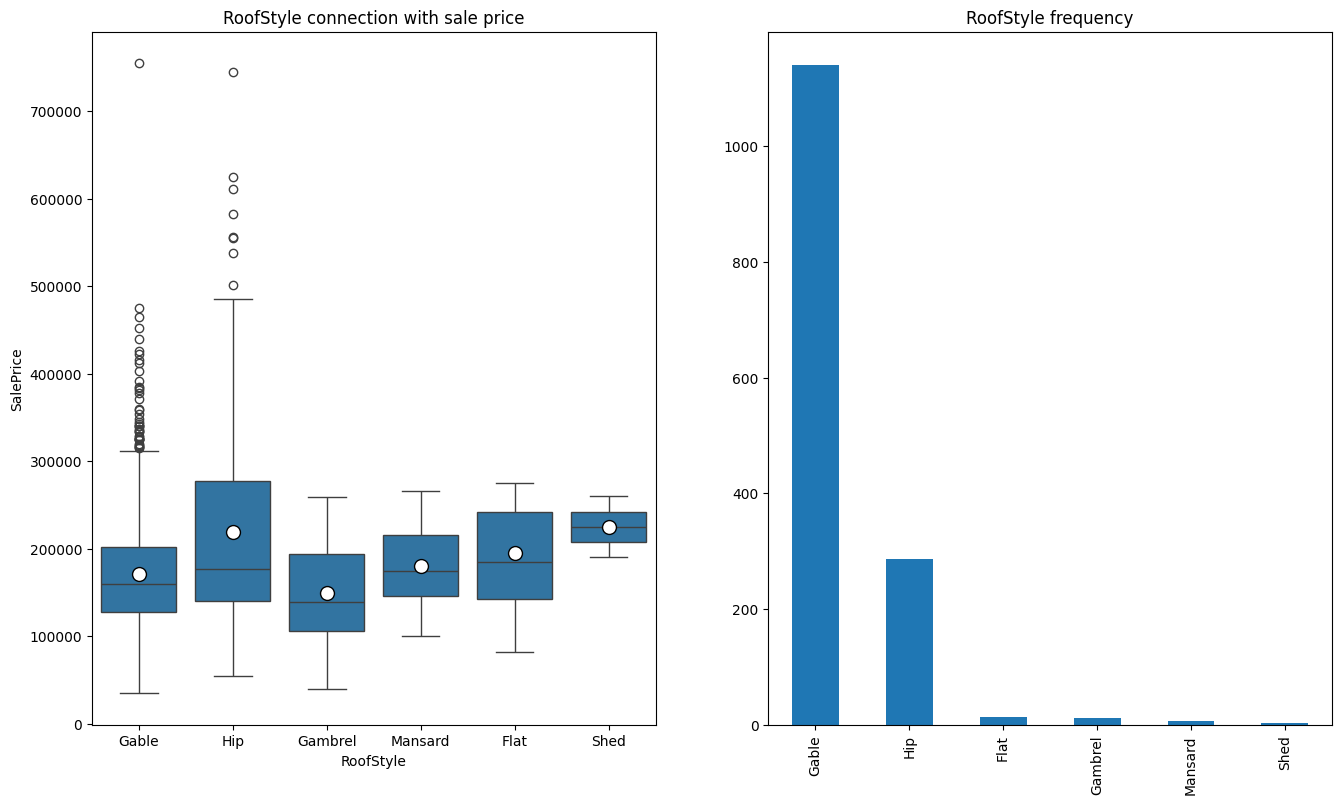

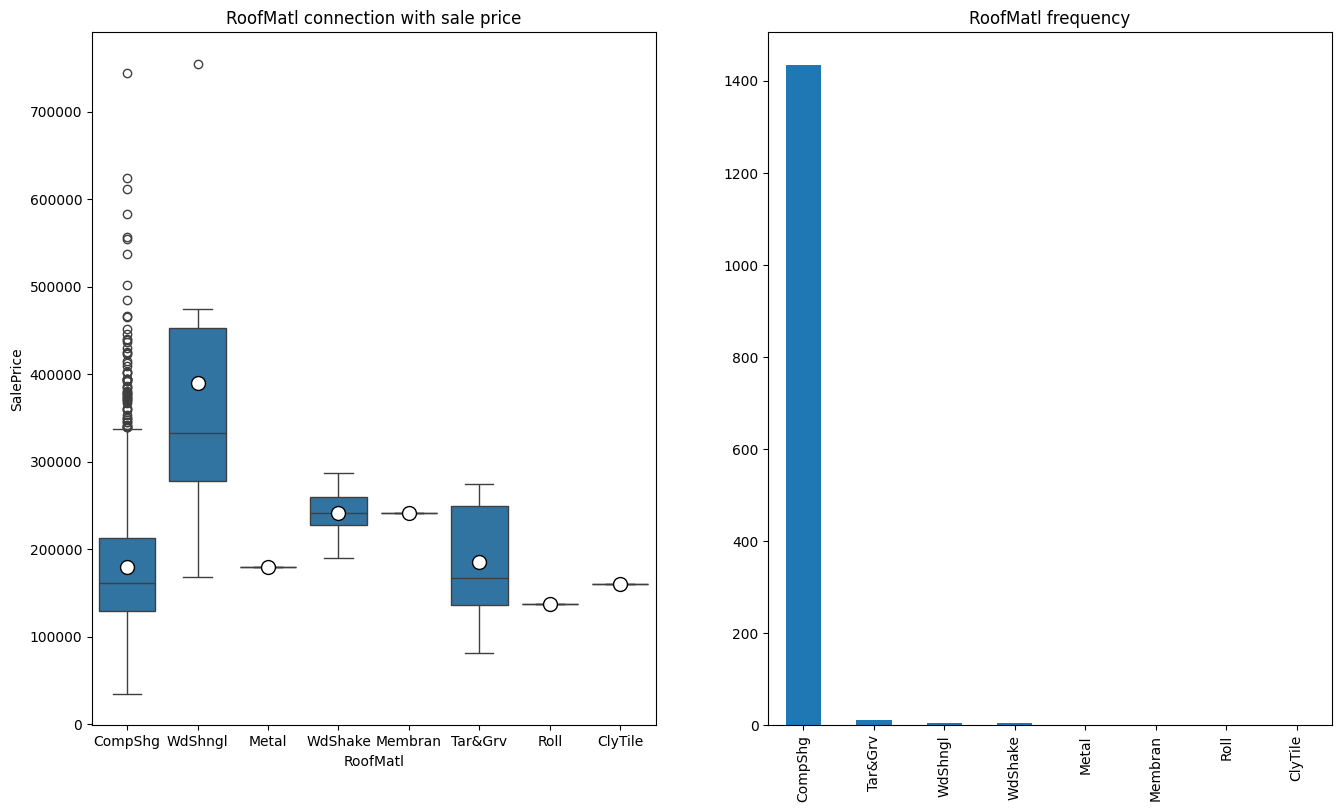

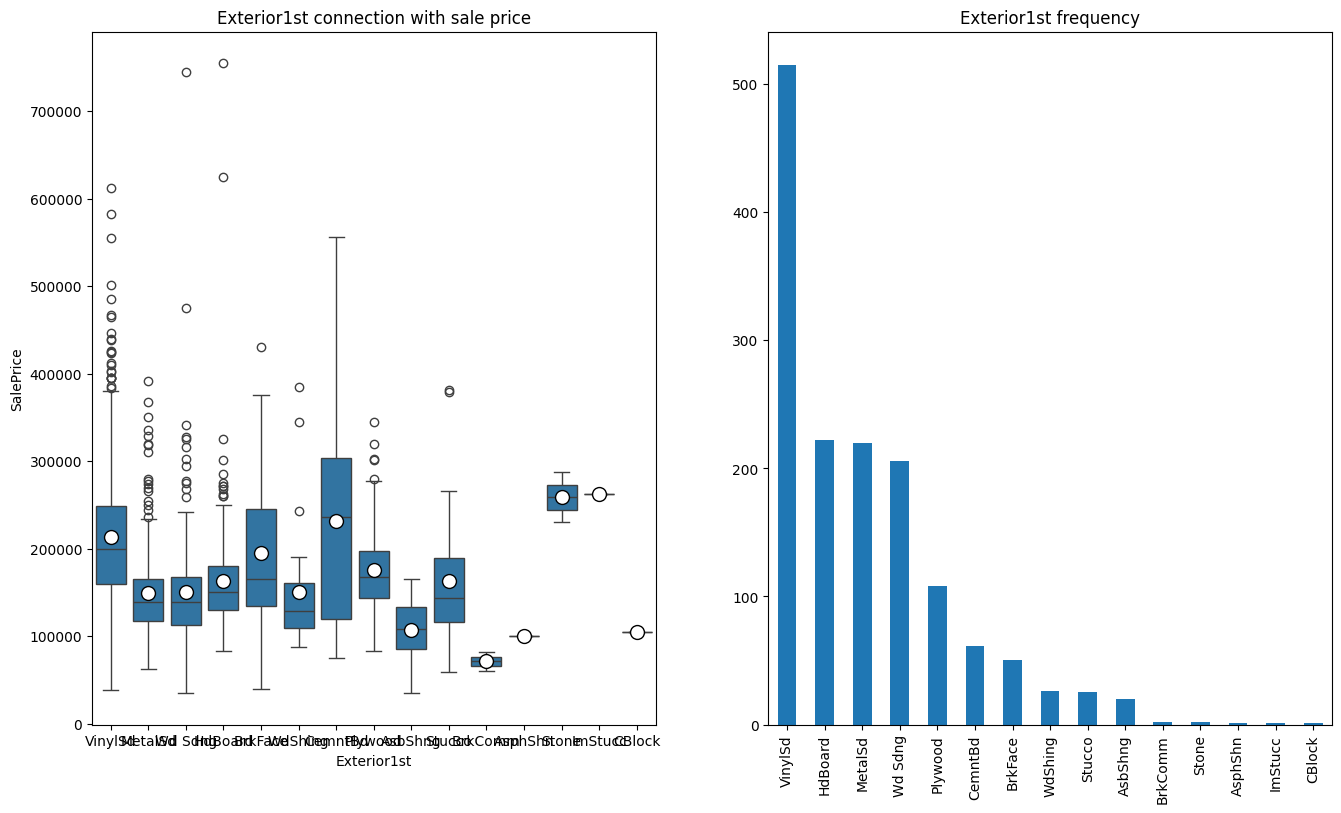

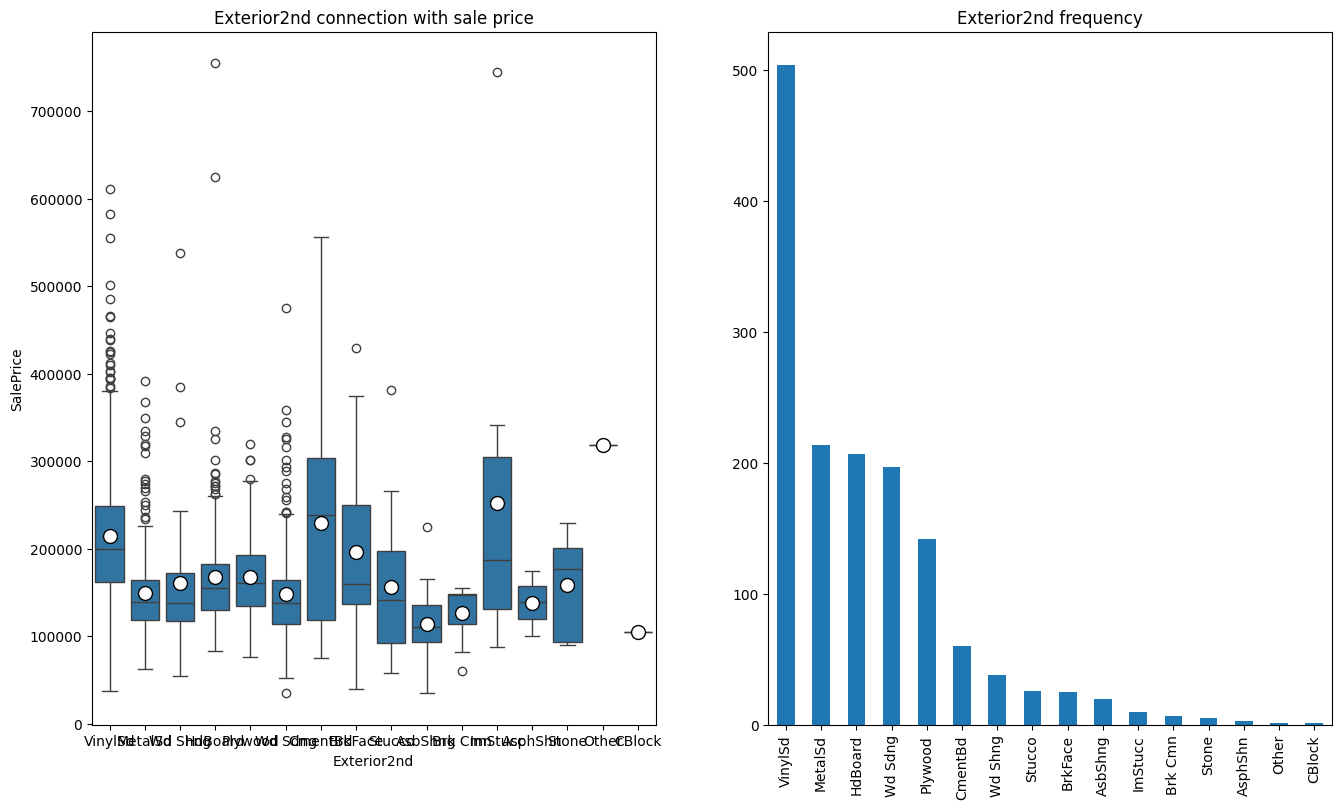

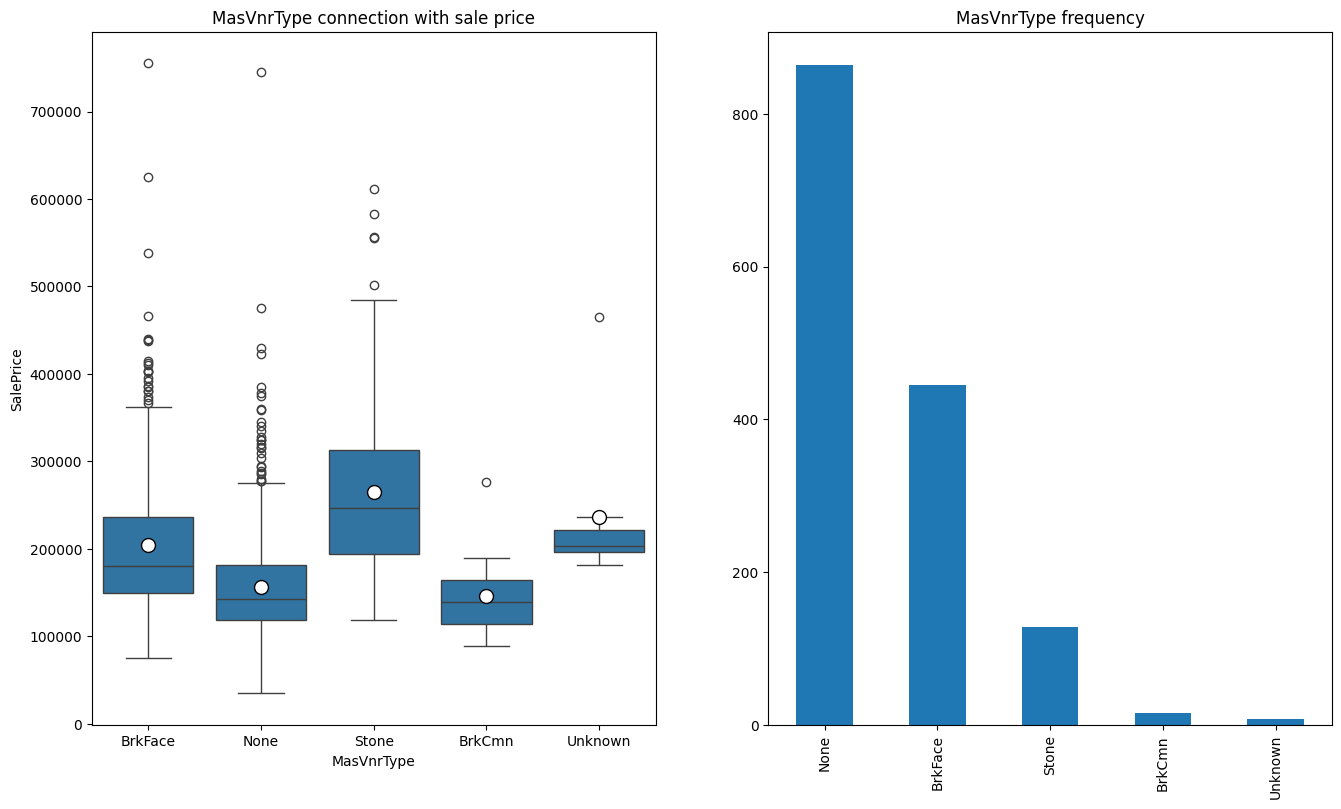

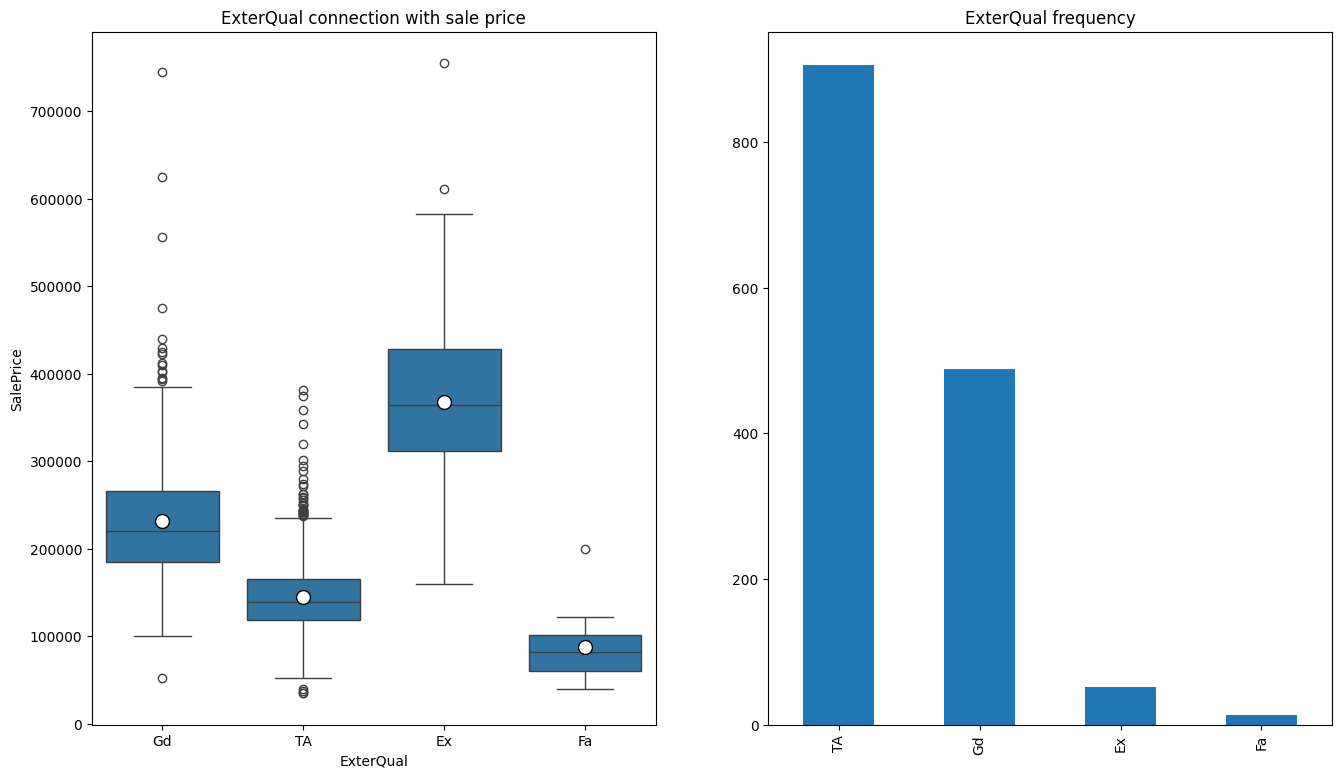

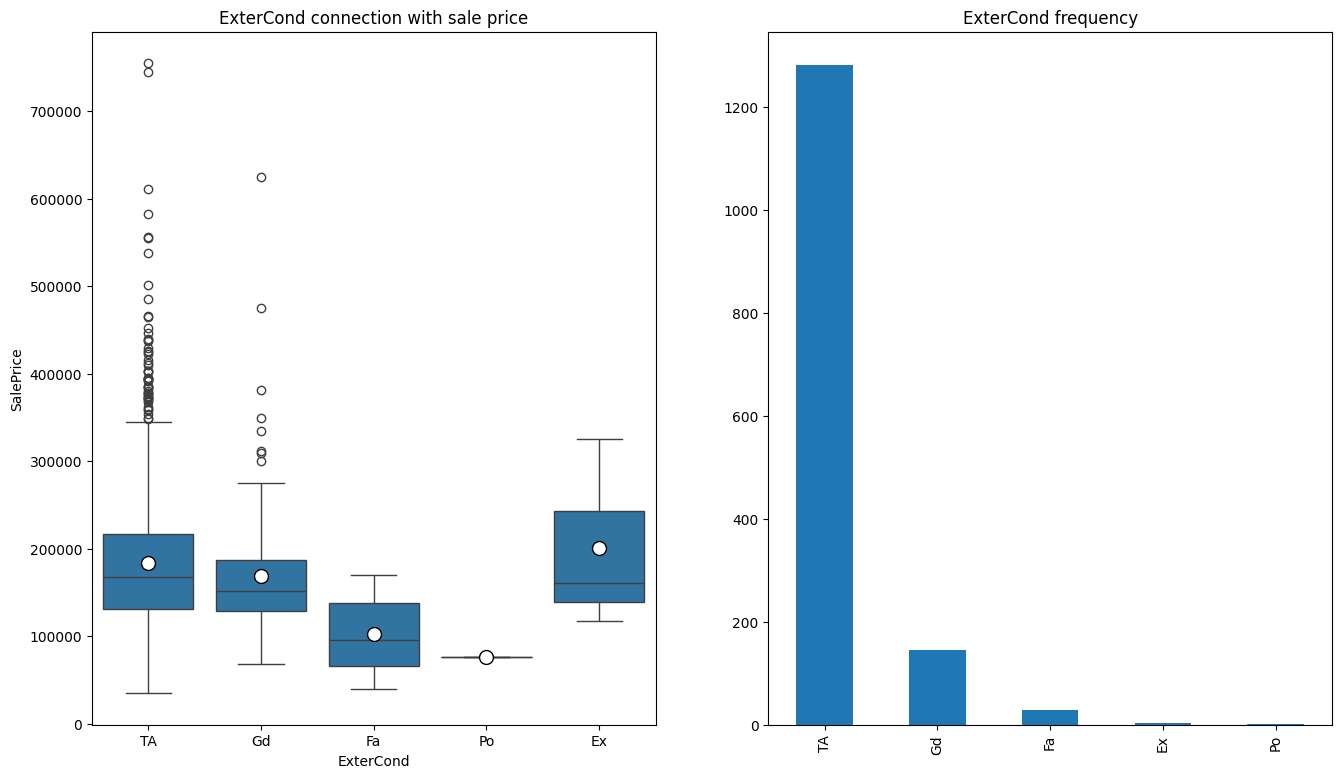

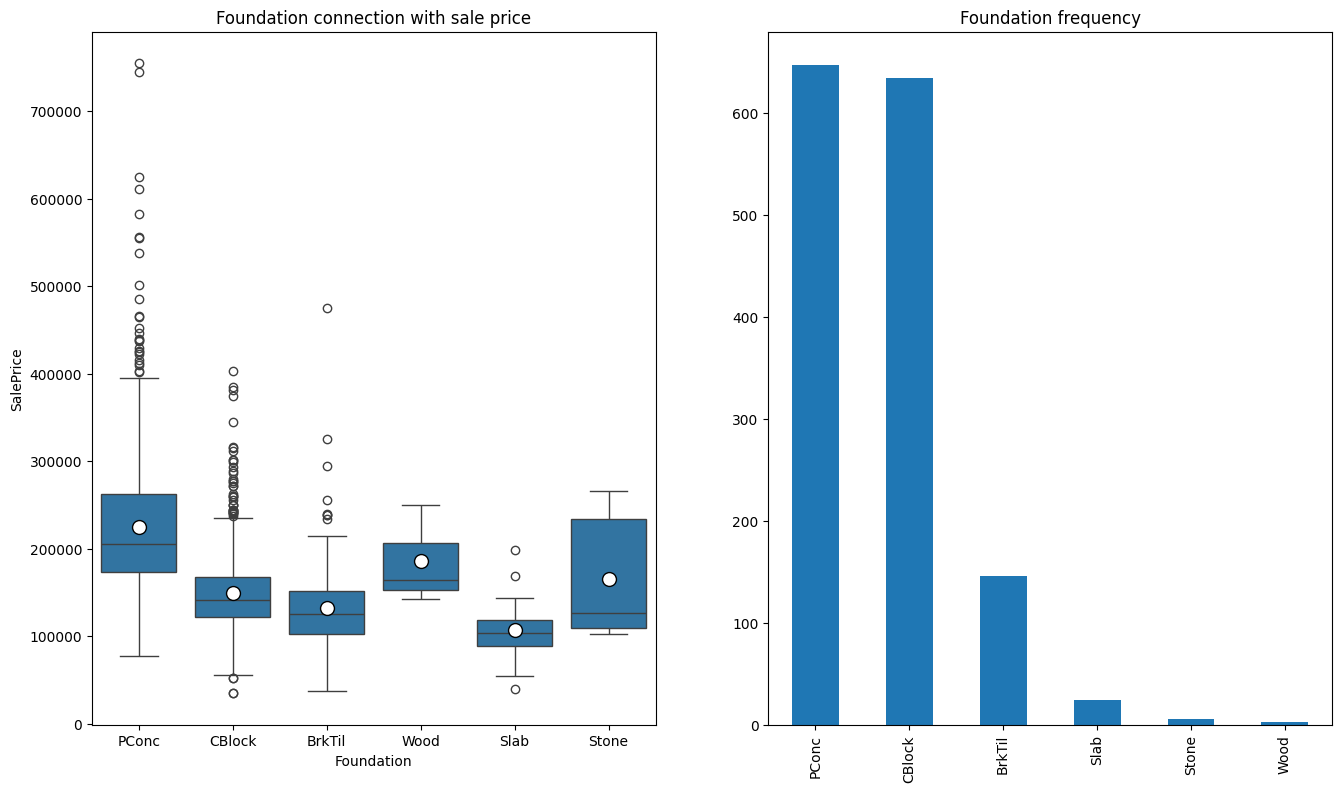

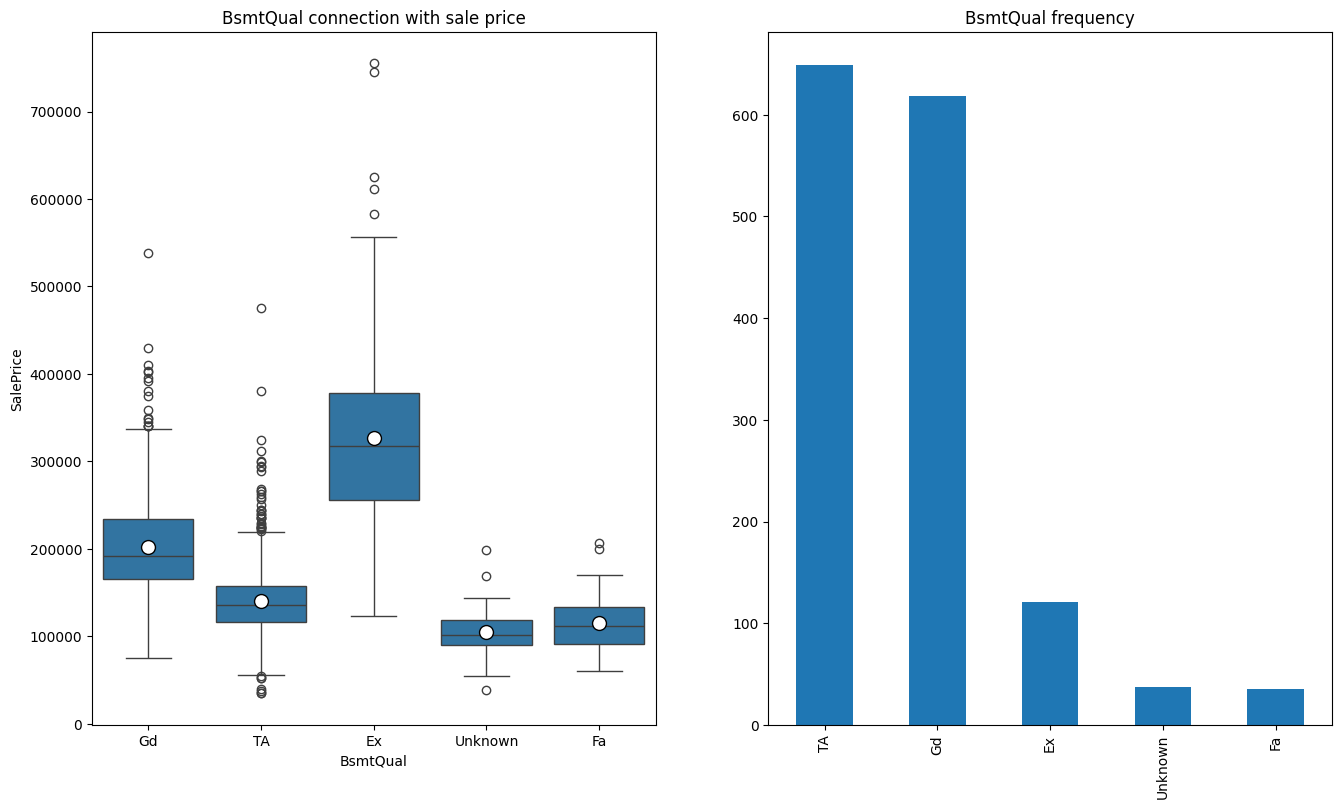

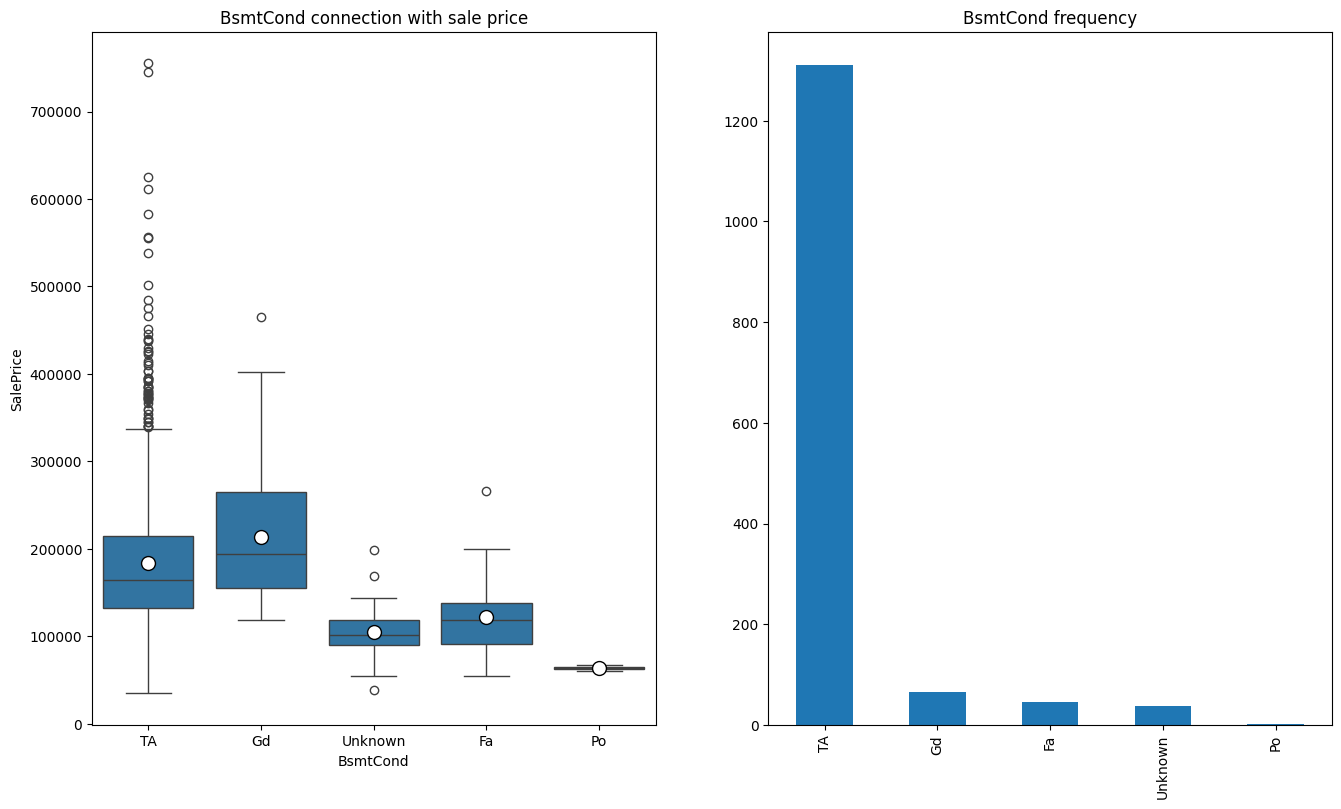

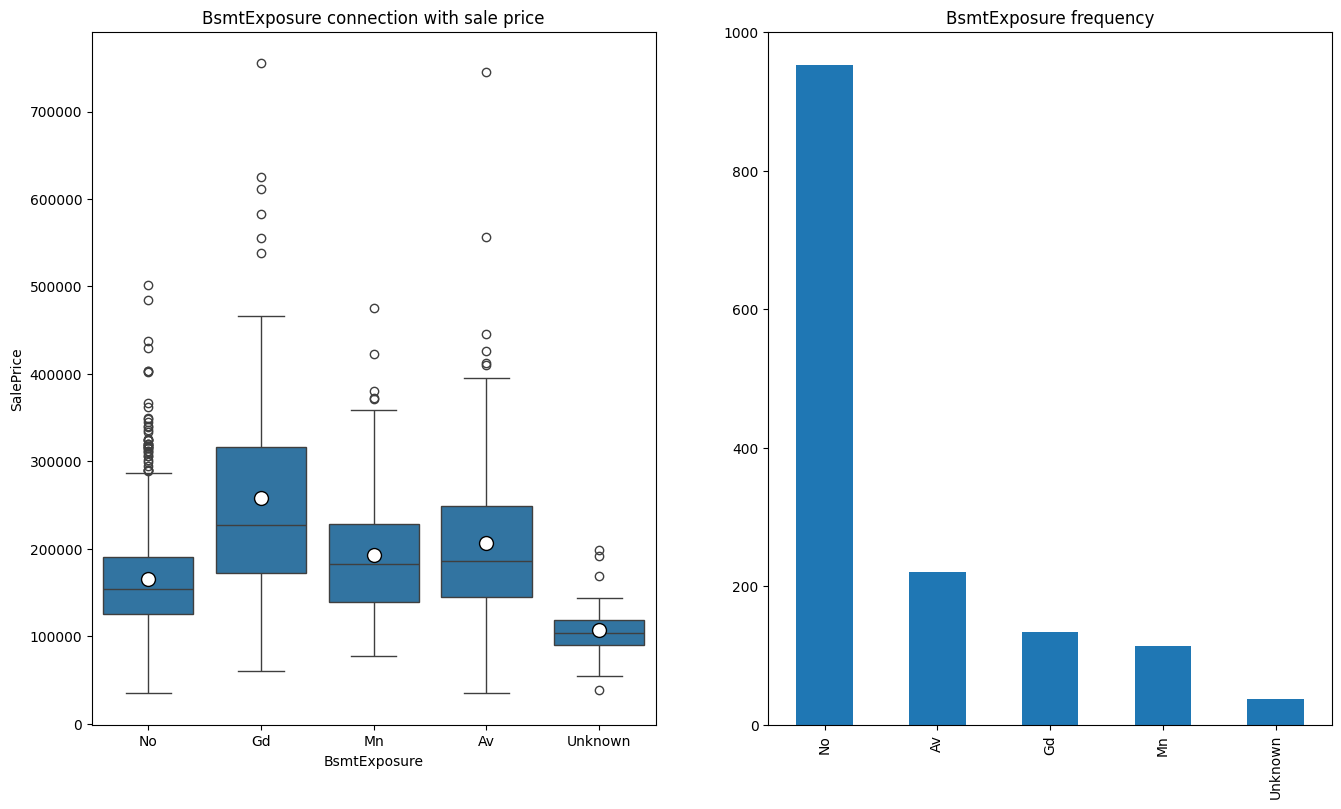

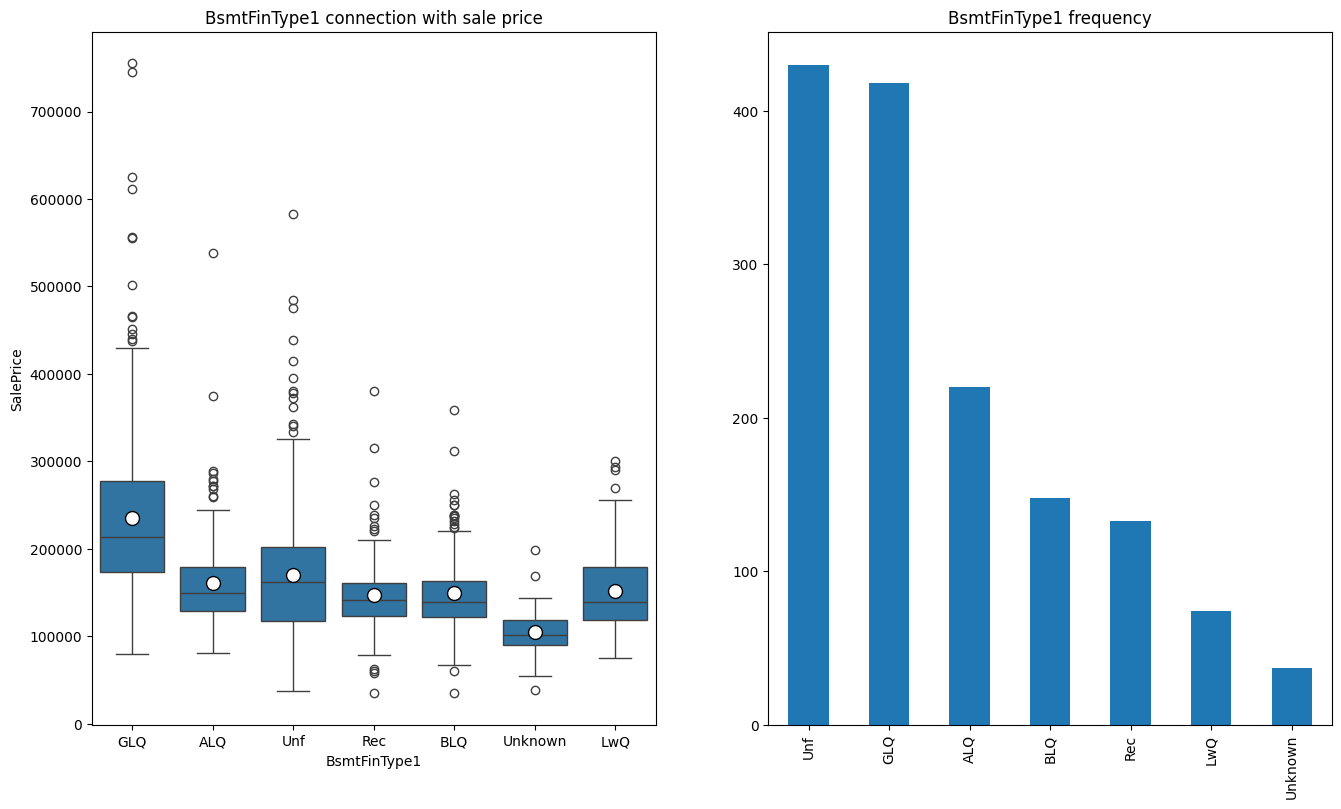

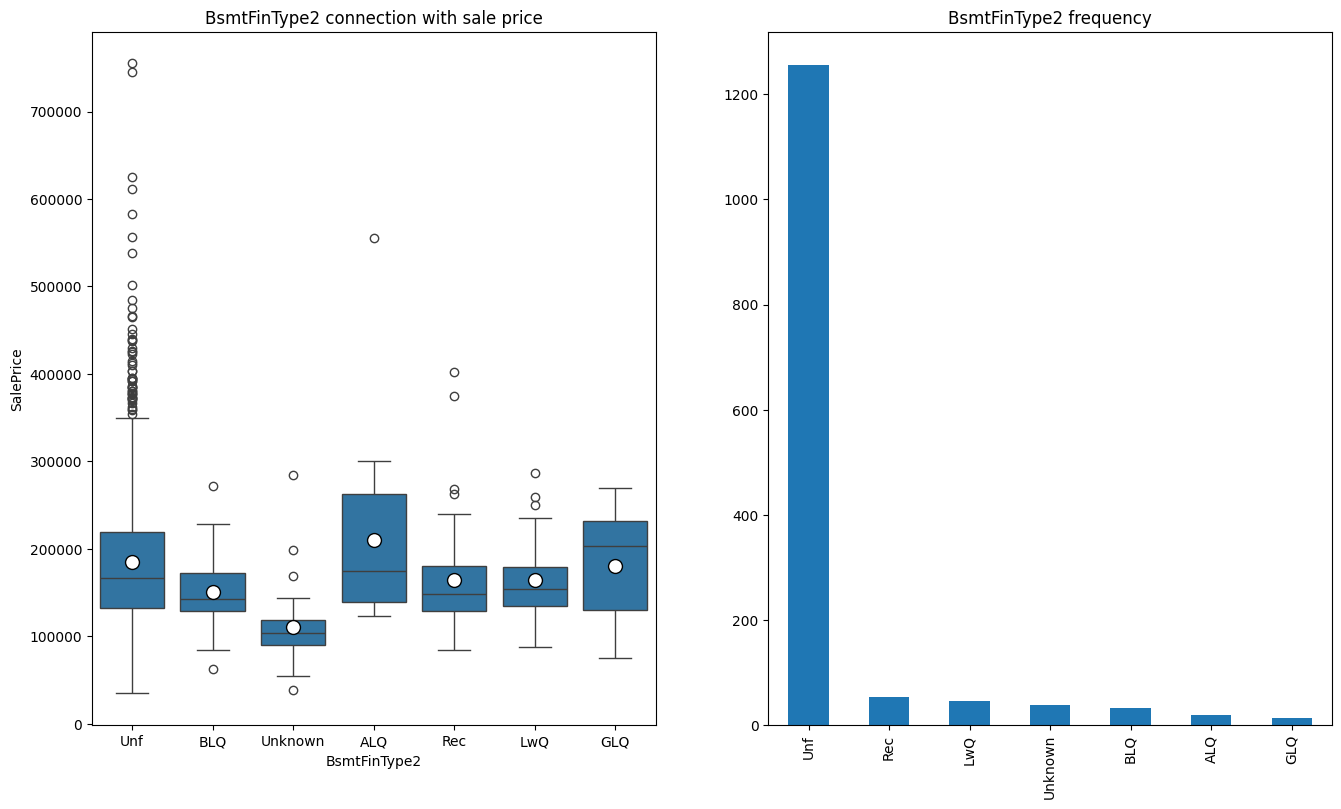

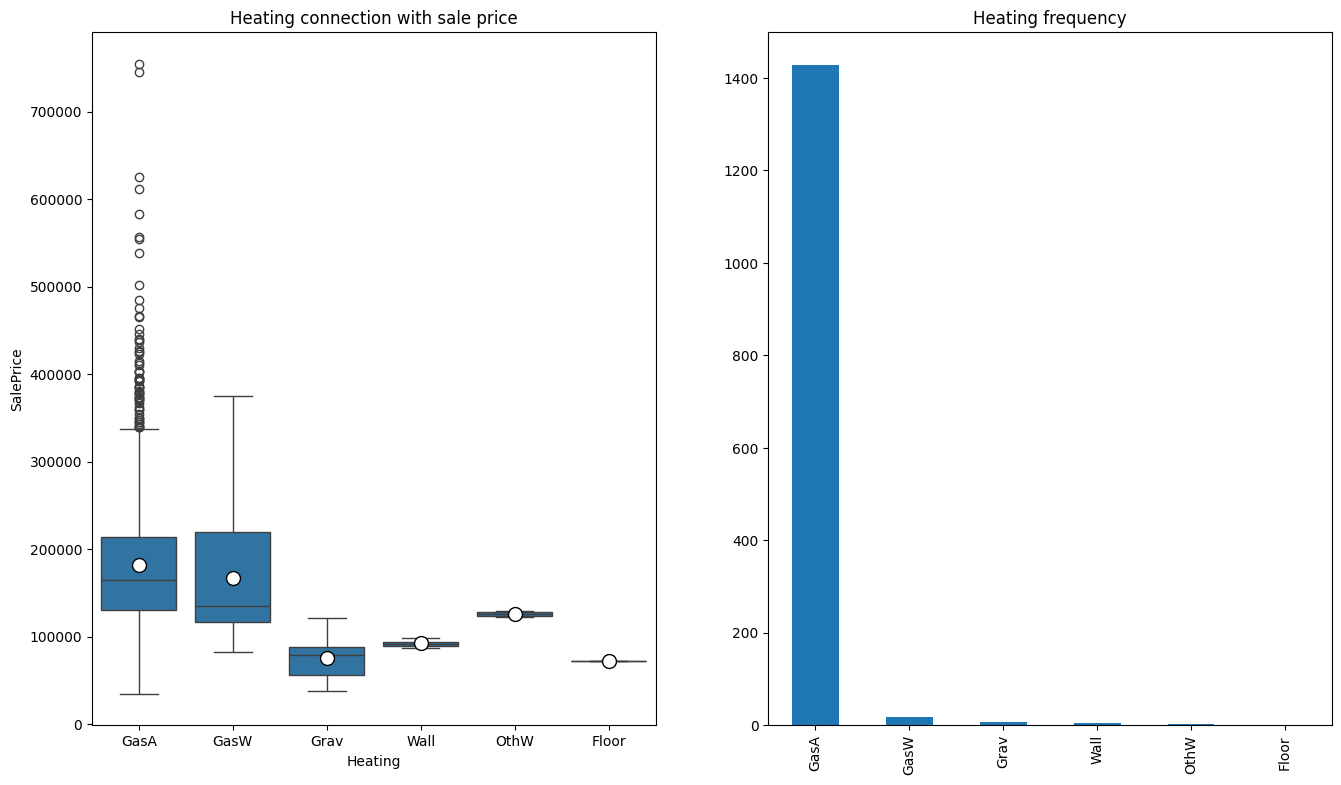

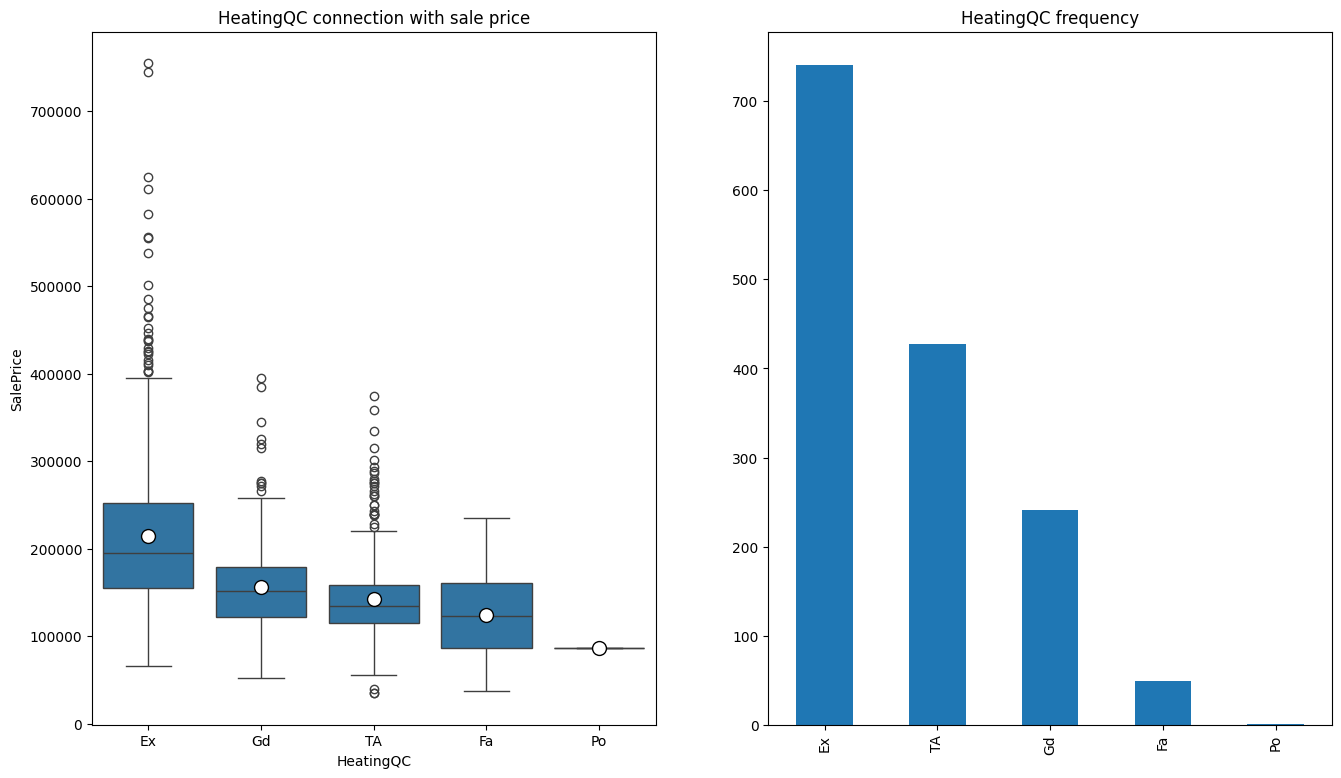

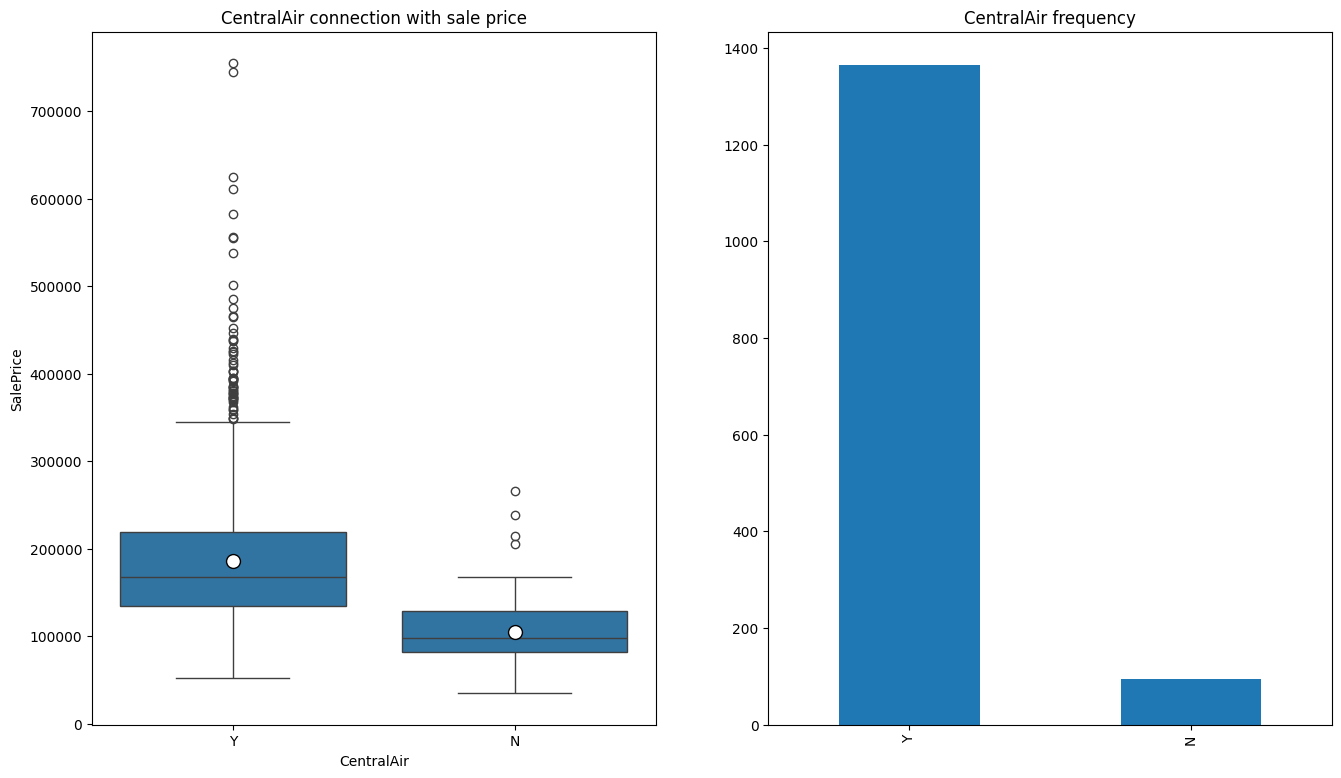

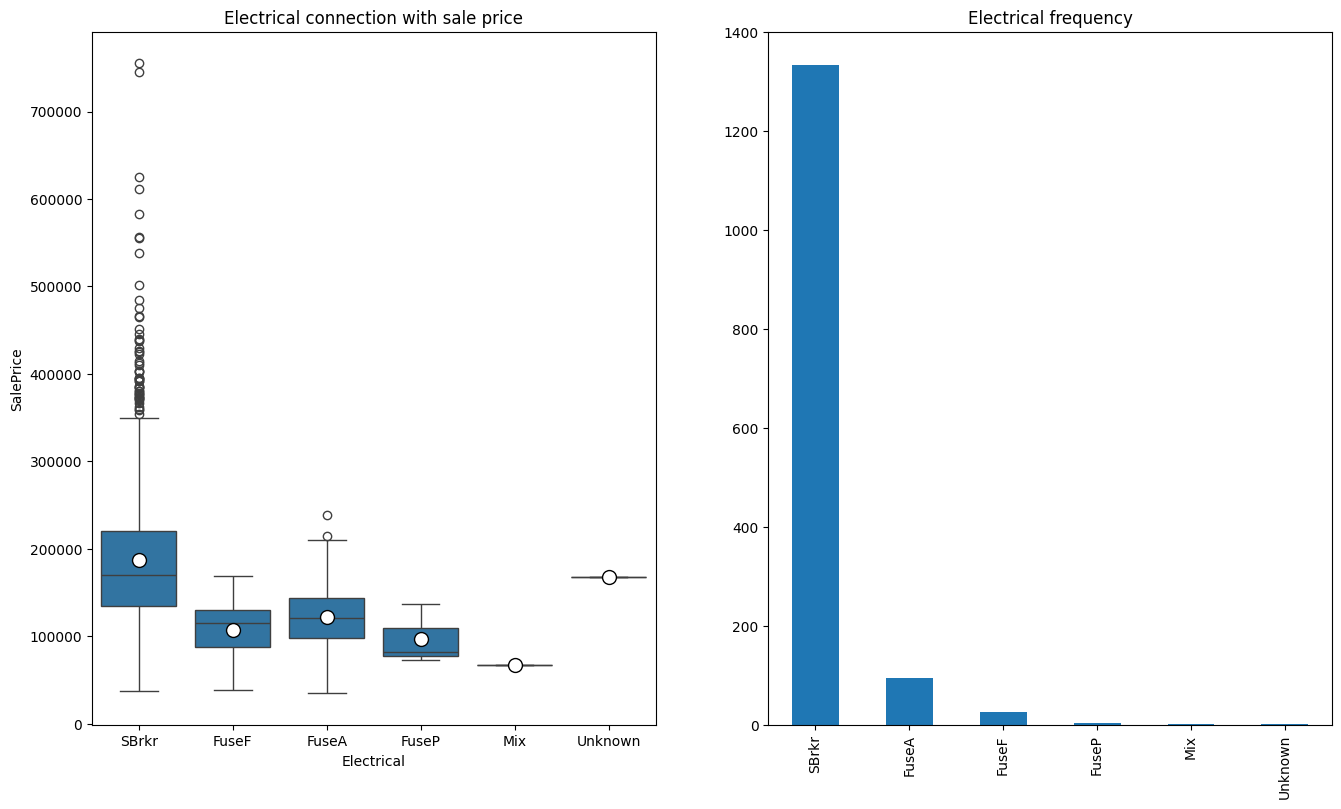

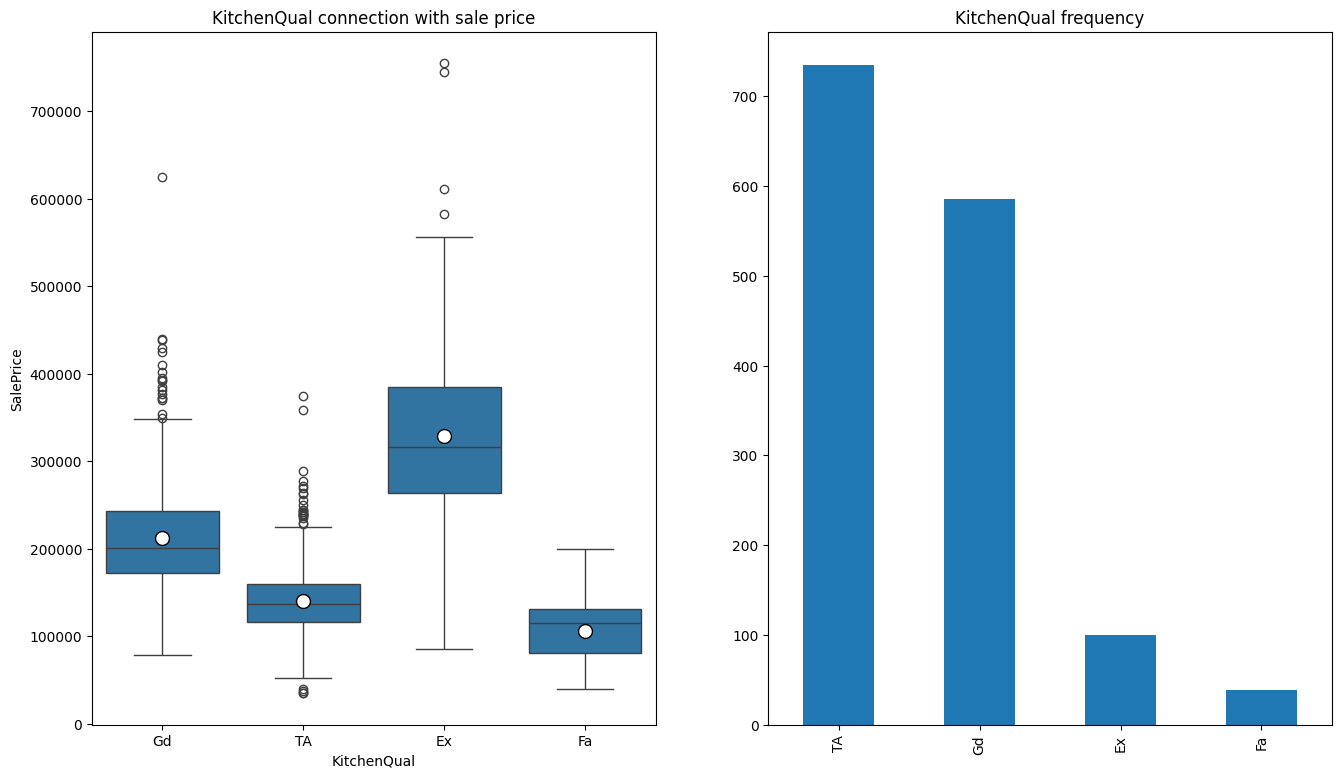

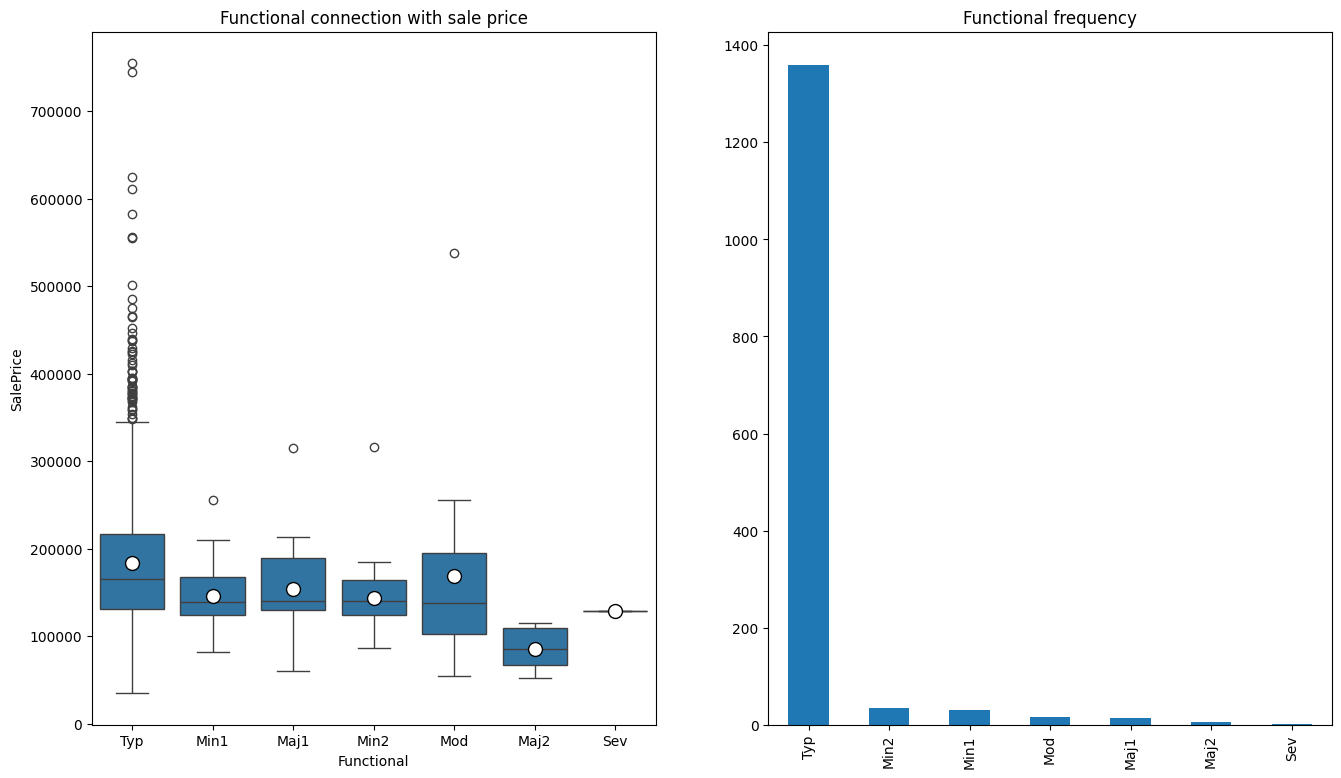

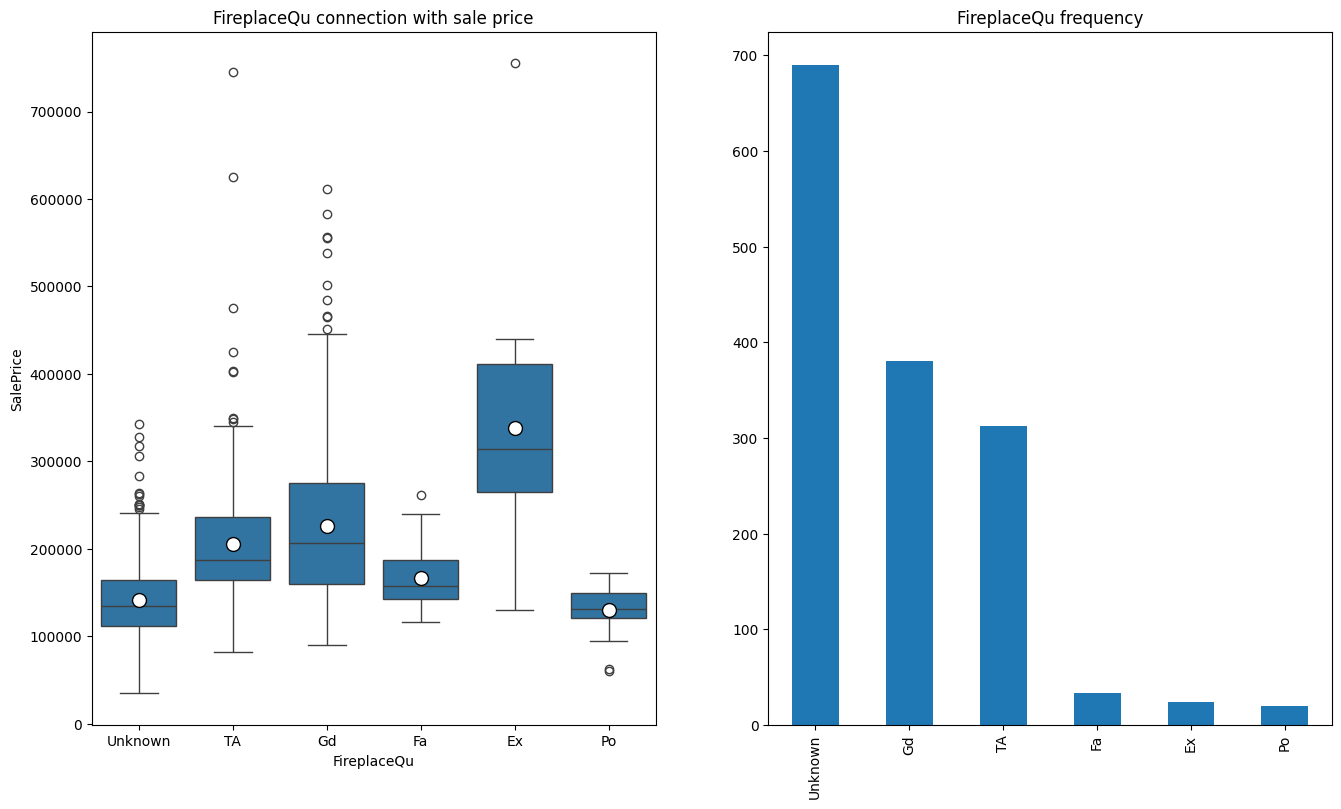

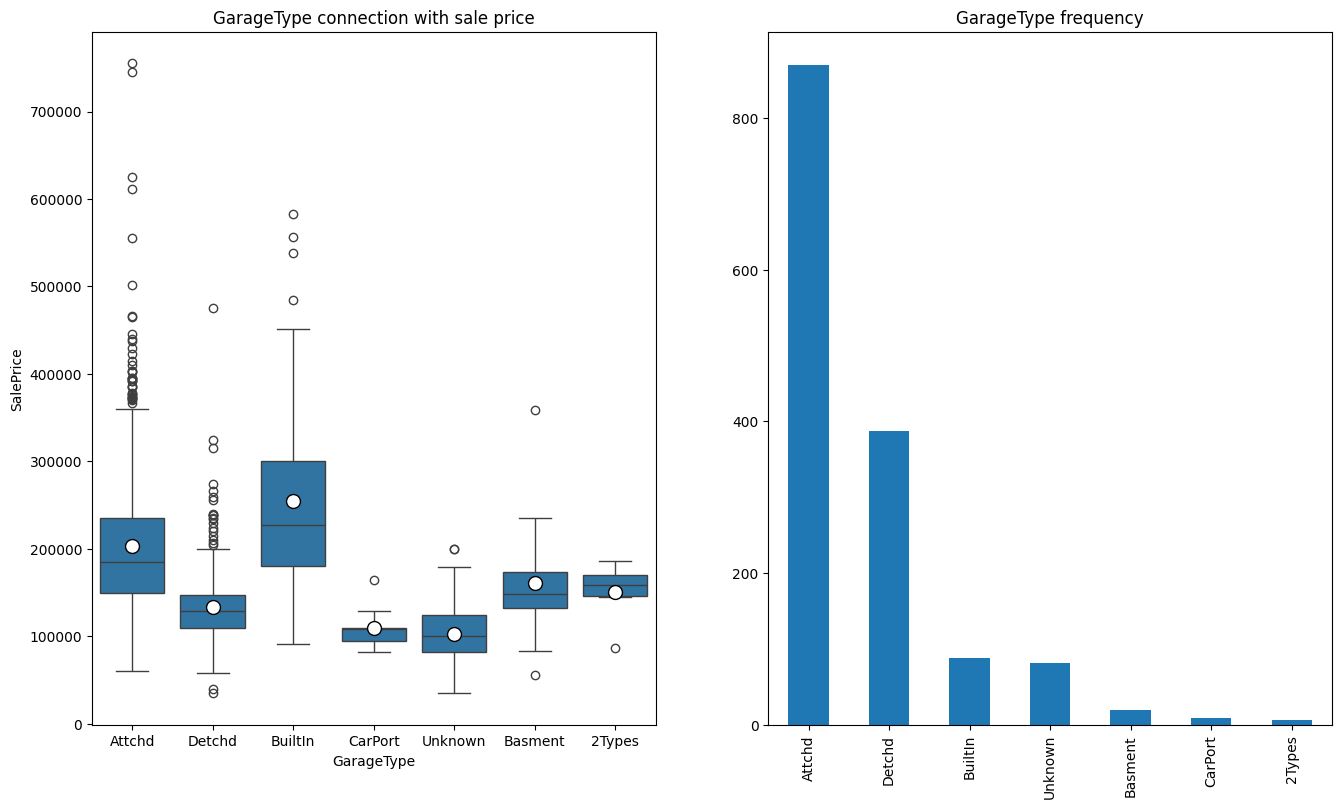

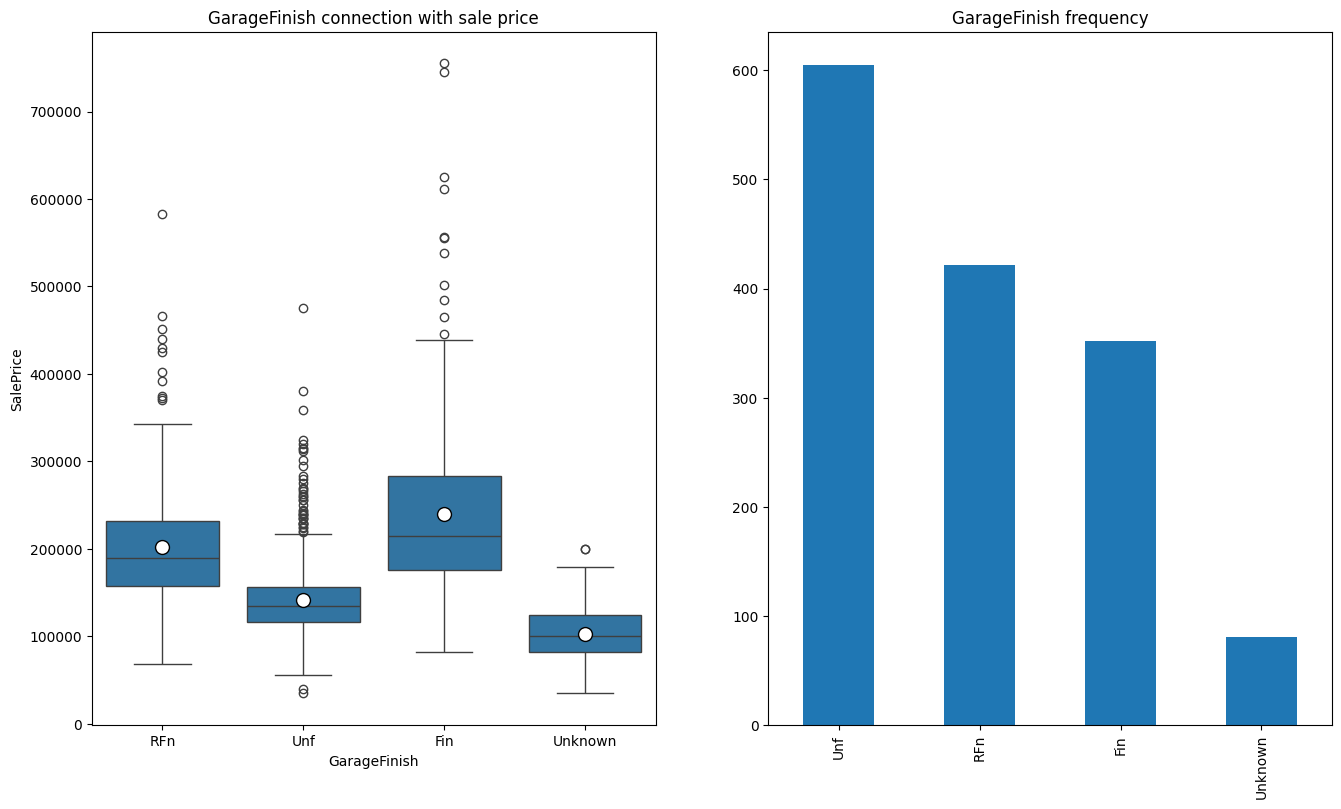

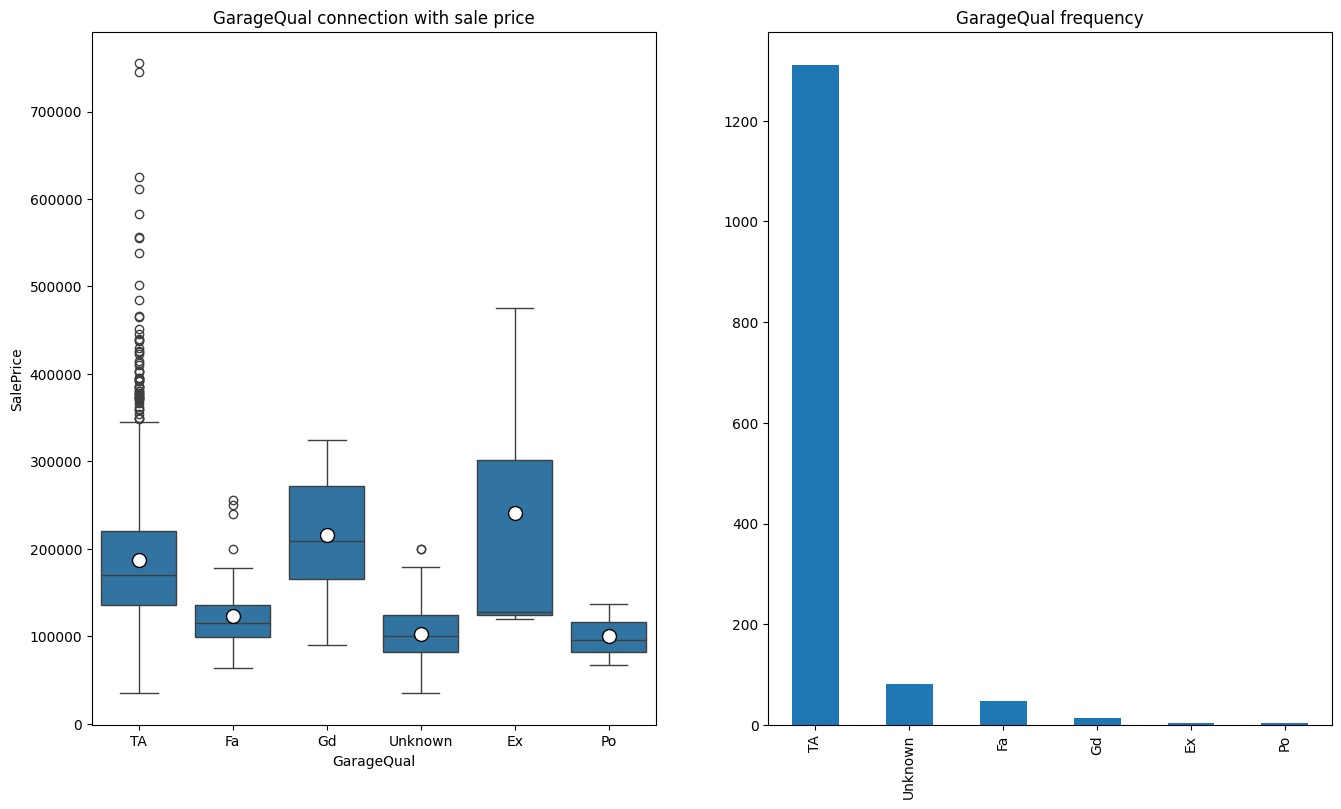

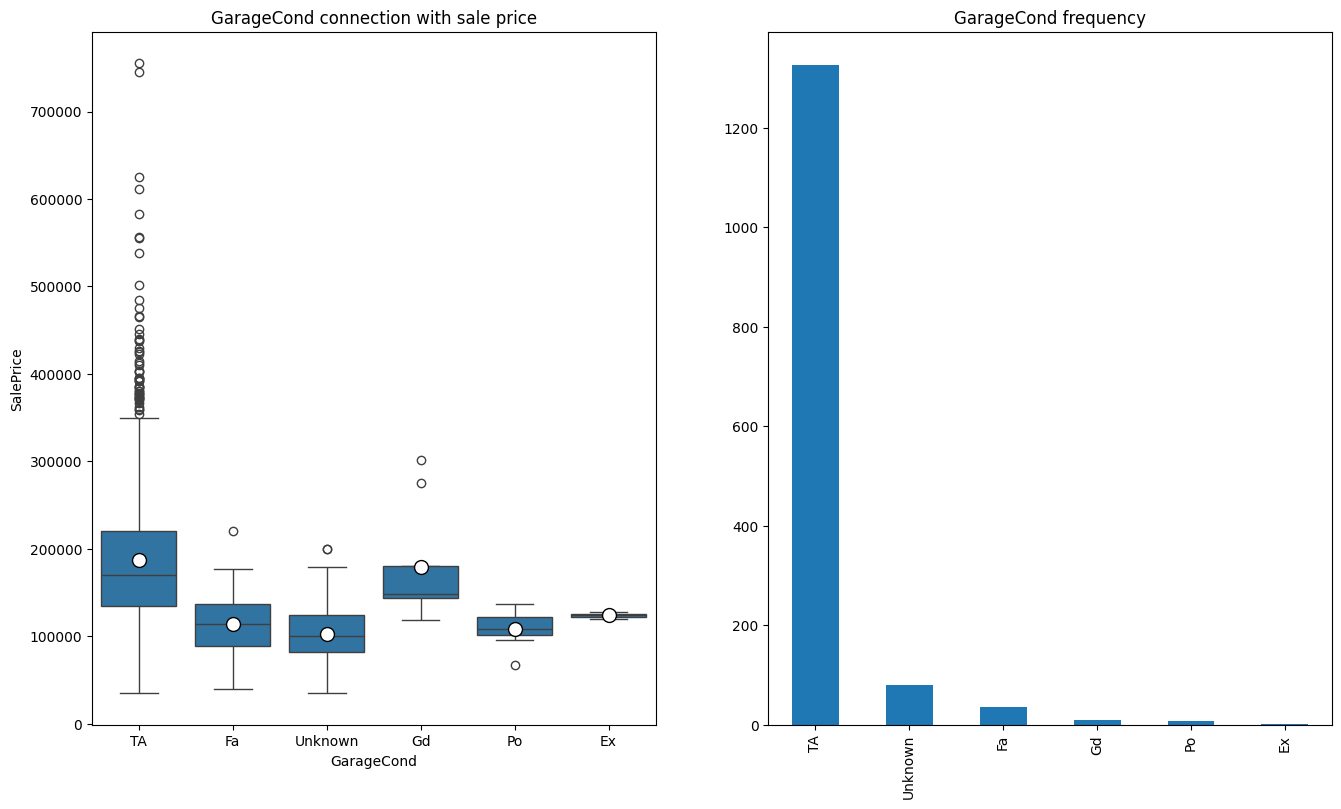

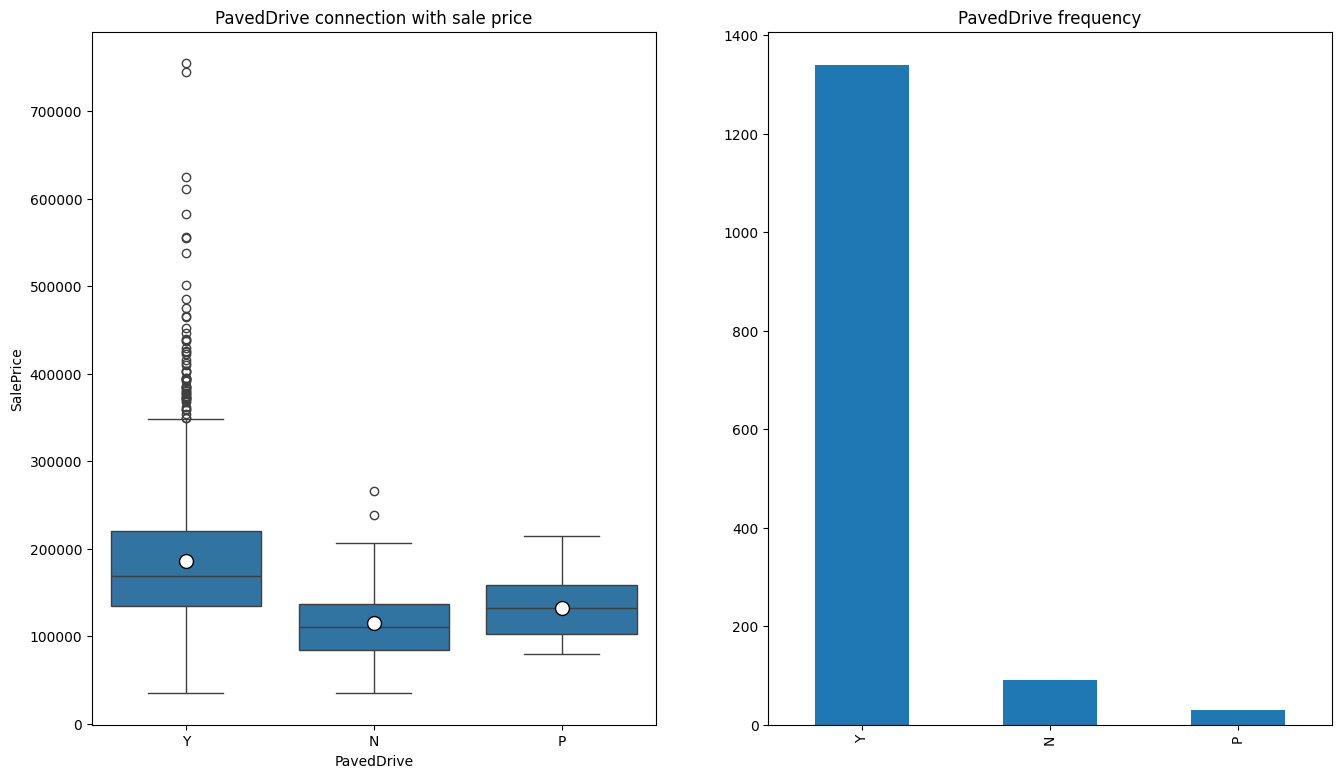

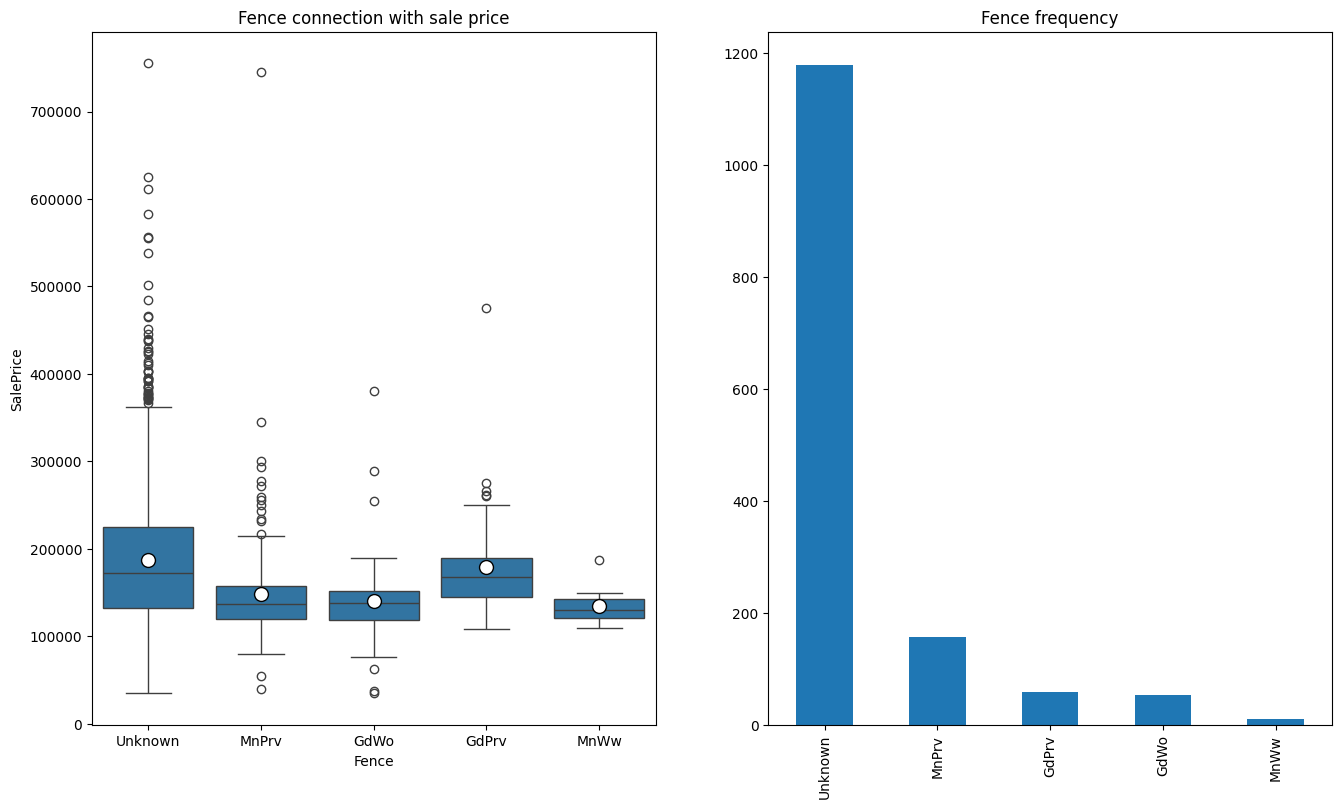

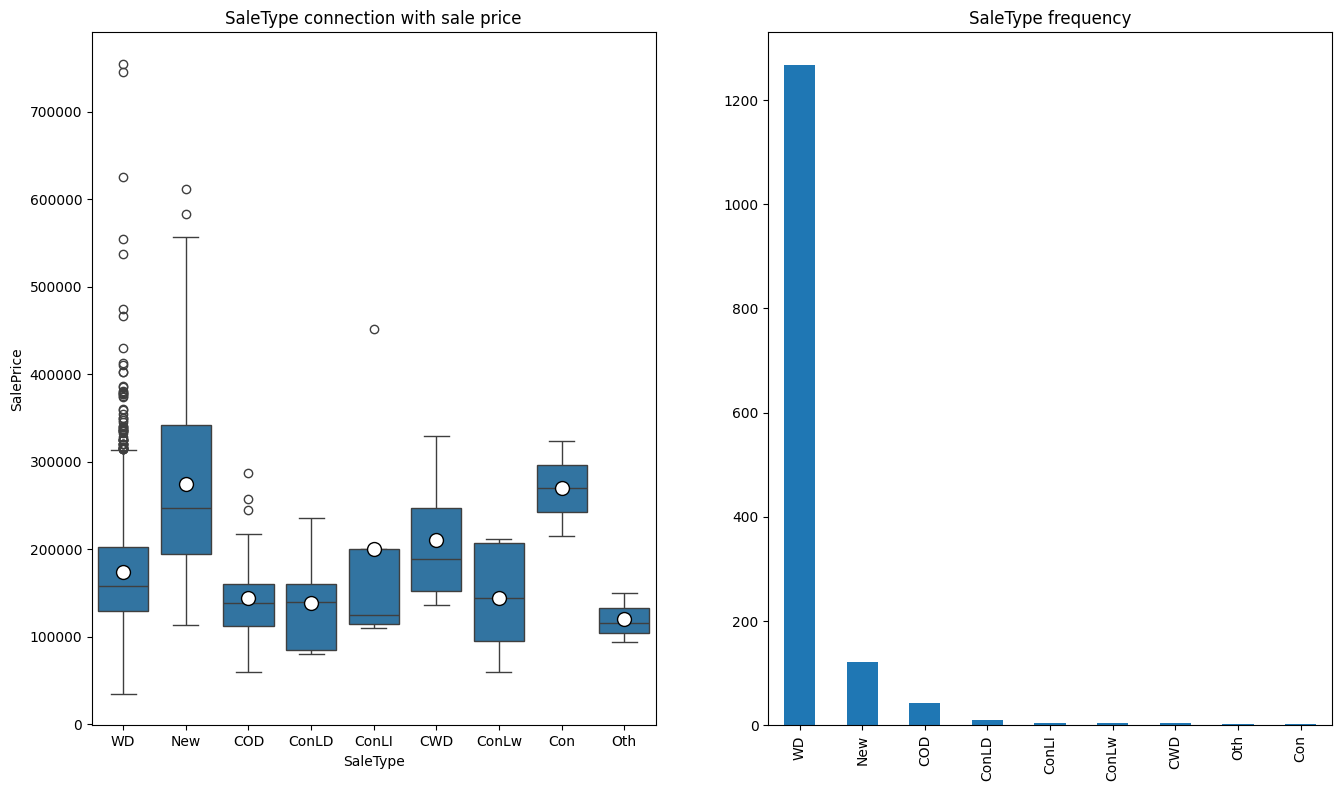

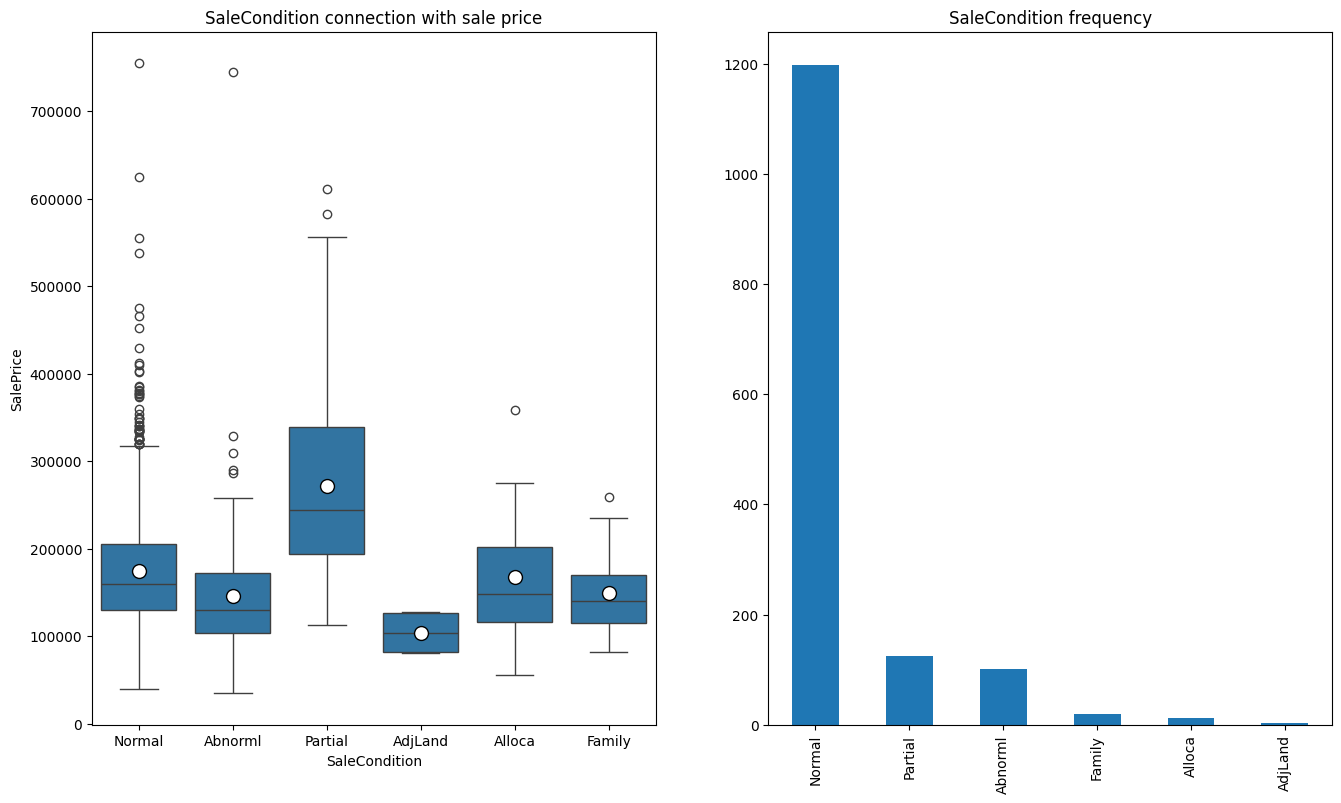

In [101]:
data_cpy = data_train.copy()
for col in categorical_features.columns:
    data_cpy[col] = data_cpy[col].fillna('Unknown')

    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    sns.boxplot(data = data_cpy, x=col, y='SalePrice', showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
    plt.title(f'{col} connection with sale price')
    plt.subplot(1, 2, 2)
    data_cpy[col].value_counts().plot(kind='bar', title=f'{col} frequency')
    plt.show()

### Conclusions by looking at the plots:
- some features has a value which is present in most of the observations and because of that they may be not representative so they are candidates to be removed,  
- I will consider converting some columns into ordinal as some of columns' specific values tend to have better SalePrice (for example Finished Garage imply higher SalePrice on average)

In [102]:
potencial_ordinal = ["ExterQual", "FireplaceQu", "GarageFinish", "MasVnrType", "BsmtQual", "HeatingQC", "KitchenQual", "GarageQual"]

In [103]:
for col in potencial_ordinal:
    print(col, data_train[col].unique())

ExterQual ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' nan]
MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']


In [104]:
def qual_mapper(value):
    if value == 'Po':
        return 1
    if value == 'Fa':
        return 2
    if value == 'TA':
        return 3
    if value == 'Gd':
        return 4
    if value == 'Ex':
        return 5
    # I treat nan as 1
    return 0

def MasVnrType_mapper(value):
    if value == 'None' or value == 'BrkCmn':
        return 1
    if value == 'BrkFace':
        return 2
    if value == 'Stone':
        return 3
    # I treat nan equally as None
    return 1

def garage_mapper(value):
    if value == 'Unf':
        return 1
    if value == 'Rfn':
        return 2
    if value == 'Fin':
        return 3
    # I treat nan equally as Unf
    return 1
    

In [105]:
data_cpy = data_train.copy()
for col in potencial_ordinal:
    fn = 0
    if col == 'GarageFinish':
        fn = garage_mapper
    elif col == 'MasVnrType':
        fn = MasVnrType_mapper
    else:
        fn = qual_mapper

    data_cpy[col] = data_cpy[col].apply(fn)

    print(f"{col}: {spearmanr(data_cpy[col], data_cpy['SalePrice'], alternative='greater')}")

ExterQual: SignificanceResult(statistic=0.6840137963904298, pvalue=2.802786101194326e-202)
FireplaceQu: SignificanceResult(statistic=0.5376018344871858, pvalue=1.9665307882729322e-110)
GarageFinish: SignificanceResult(statistic=0.4193922033558742, pvalue=1.4067663575581116e-63)
MasVnrType: SignificanceResult(statistic=0.4250535654001598, pvalue=1.9974462205366296e-65)
BsmtQual: SignificanceResult(statistic=0.6780262530716648, pvalue=1.848279295983479e-197)
HeatingQC: SignificanceResult(statistic=0.4913919065603799, pvalue=6.736121178532523e-90)
KitchenQual: SignificanceResult(statistic=0.6728485475386915, pvalue=2.2002546986044886e-193)
GarageQual: SignificanceResult(statistic=0.3510815694994845, pvalue=6.682083818456394e-44)


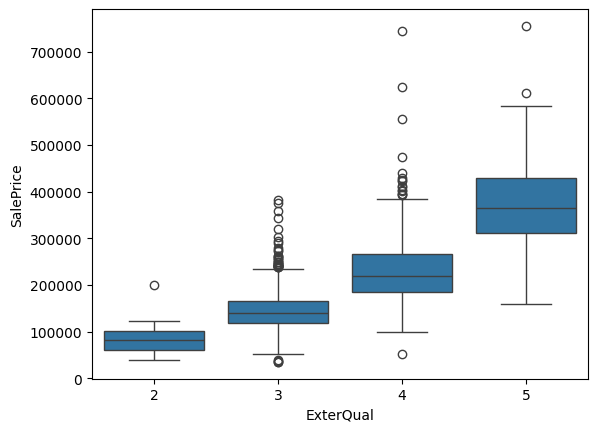

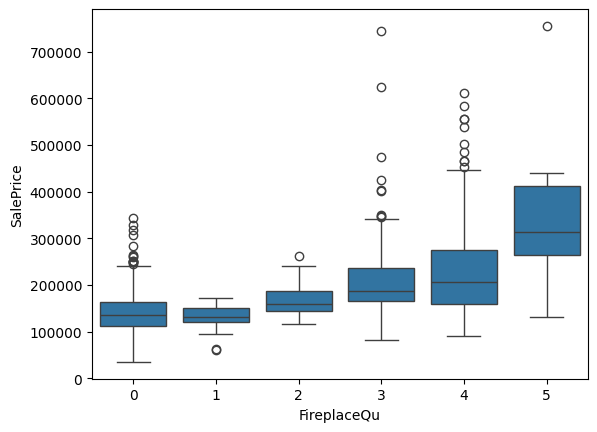

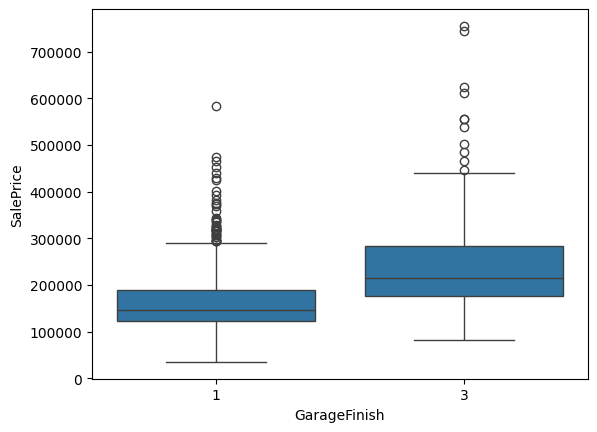

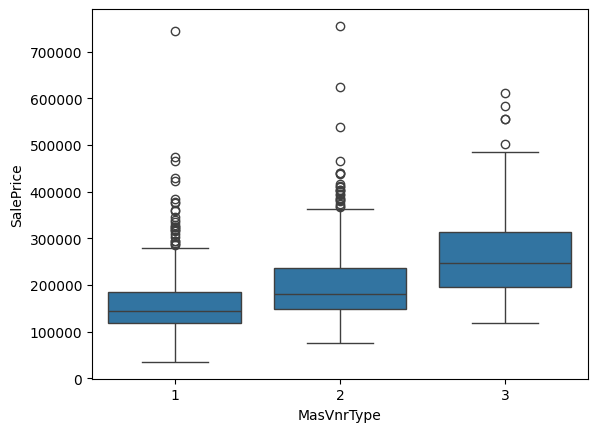

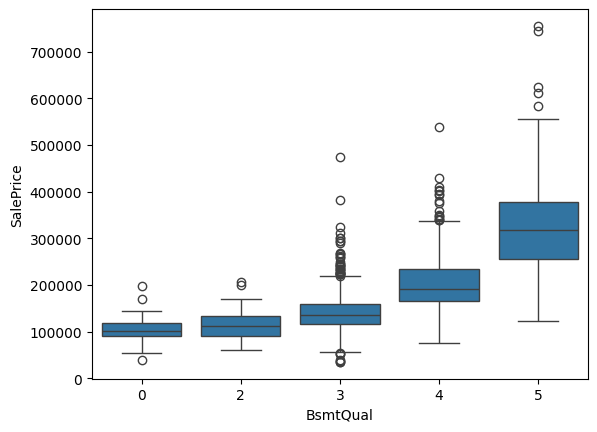

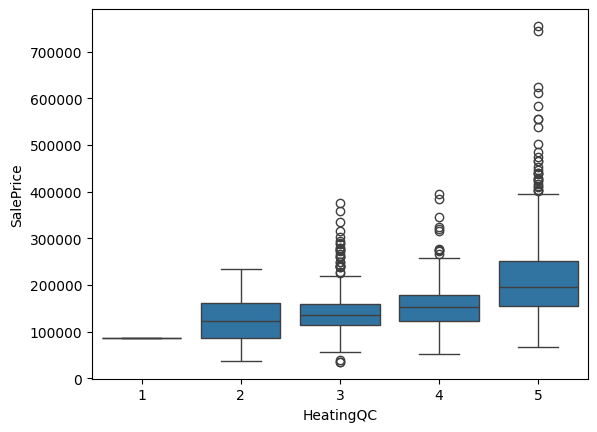

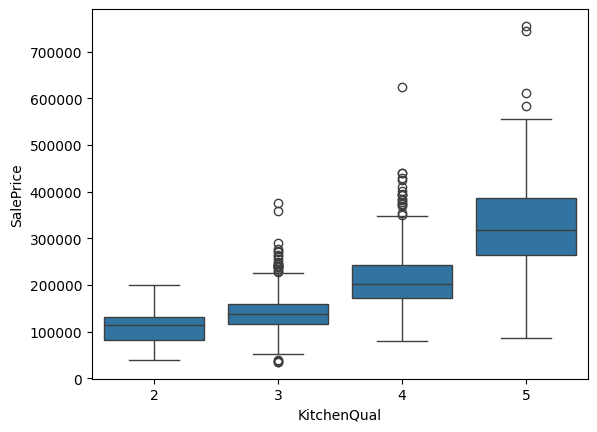

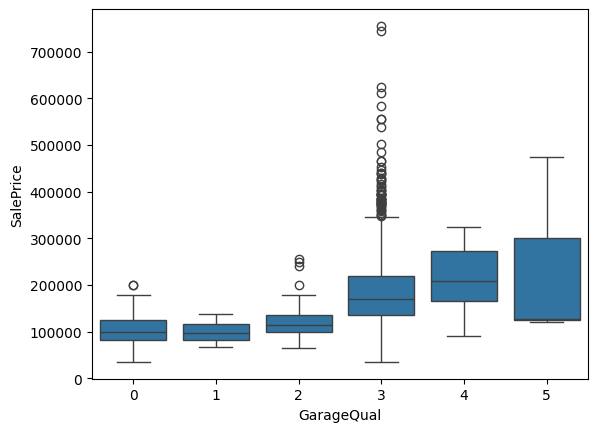

In [106]:
for col in potencial_ordinal:
    sns.boxplot(data = data_cpy, x=col, y='SalePrice')
    plt.show()


### The tests above (and plots) make us confident that for each column above: as quality increase the SalePrice increase

### Below I look for features where the most frequent feature is present in at least 90% of the data. I will remove them as they will not, in my opinion, bring a lot of general information about SalePrice. But I will also check how different models work with or without that features.

In [107]:
cat_desc = categorical_features.describe().T

cat_desc['freq_ratio'] = cat_desc['freq'] / len(data_train)
cat_desc.sort_values(by='freq_ratio', ascending=False, inplace=True)
print(scrollable_dataframe(cat_desc))
print('\n  *************************  \n')
print(cat_desc[cat_desc['freq_ratio'] >= 0.9].index)

None

  *************************  

Index(['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'LandSlope',
       'CentralAir', 'Functional', 'PavedDrive', 'Electrical', 'GarageCond'],
      dtype='object')


### But there are still values with freq_rate higher than 0.85, I will keep them at this moment

### Below is function how I would transform categorical at this moment:

In [108]:
def toOrdinalFn(col: str):
    fn = 0
    if col == 'GarageFinish':
        fn = garage_mapper
    elif col == 'MasVnrType':
        fn = MasVnrType_mapper
    else:
        fn = qual_mapper
    return fn

def adjustCategorical(df: pd.DataFrame) -> pd.DataFrame:
    # I assume here that only categorical variables come here
    cpy = df.copy()
    cat_desc = df.describe().T
    too_unique_cols = list(cat_desc[cat_desc['freq_ratio'] >= 0.9].index)
    cpy.drop(columns=too_unique_cols, inplace=True)
    # transform some columns from categorical to ordinal
    for i in potencial_ordinal:
        cpy[i] = cpy[i].apply(toOrdinalFn(i))

    # drop columns where most of the values are missing
    cpy.drop(columns=['Alley', 'PoolQC', 'MiscFeature', 'Fence'], inplace=True)

    return cpy
    

### When it comes to cleaning the data:
##### - I will fill numerical features with median
##### - I will fill categorical features with 'Unknown' label or with majority class depending on how numerous a particular feature is

In [109]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns='SalePrice'), data_train[['SalePrice']], test_size=0.25, random_state=17)

In [110]:
data_train_fixed = data_train.copy()
data_train_fixed = adjustCategorical(data_train_fixed)
data_train_fixed = adjustNumerical(data_train_fixed)
data_train_fixed.drop(columns=['Id', 'is_train'], inplace=True)


### Lets not forget that there are still missing values that have to be handled

In [111]:
def unknownOrMajoritySplit(data):
    unknownCols = []
    majorityCols = []
    desc = data_train[['BsmtFinType1', 'BsmtFinType2']].describe().T
    length = len(data)
    for index, row in desc.iterrows():
        freq = row['freq']
        if freq / length >= 0.75:
            majorityCols.append(index)
        else:
            unknownCols.append(index)

In [112]:
# I will compare two different LinearRegression models with different columns
# In first model I will use columns in which we can spot (by just looking at plots) corellation with SalePrice
# In second model I will also include categorical features
ordinal_cols = ['OverallQual'] + potencial_ordinal
good_linearity_cols = ['YearBuilt', 'TotalSqrFt']
good_count_cols = ['FullBath', 'TotRmsAbvGrd']

rest_cols_cat = ['OverallQuad', 'MSSubClass', 'MSZoning', 
             'LotShape', 'LandContour', 'LandSlope', 
             'Neighborhood', 'Condition1', 'BldgType', 
             'HouseStyle', 'RoofStyle', 'Exterior1st', 
             'Exterior2nd', 'ExterCond', 'Foundation', 
             'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
             'BsmtFinType1', 'Electrical', 'GarageType', 
             'GarageQual', 'GarageCond', 'PavedDrive', 
             'SaleType', 'SaleCondition']

### For numerical I will always fill missing with median
### For categorical I will fill missing values with majority class or with 'Unknown' label depending on how big is the majority class

In [113]:
numerical_to_exclude = ordinal_cols + ['isGarage', 'is2ndFlr', 'WasRemod']

numerical_cols = data_train_fixed.loc[:, ~data_train_fixed.columns.isin(ordinal_cols)].select_dtypes(include=np.number).columns

In [114]:
numerical_cols

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'SalePrice', 'TotalSqrFt', 'isGarage', 'is2ndFlr',
       'WasRemod'],
      dtype='object')

In [115]:
categorical_cols = data_train_fixed.select_dtypes(include=object)
cat_missing, cat_majority = unknownOrMajoritySplit(data_train_fixed[categorical_cols])


ValueError: Boolean array expected for the condition, not object

### Firstly I will check how linearRegression work. It looks promising as there are many almost linear and ordinal features 

In [ ]:
with_missing = X_train.isna().sum().to_frame()
with_missing = with_missing[with_missing[0] > 0]

scrollable_dataframe(with_missing)

In [ ]:
# first linear regression

cols_for_lr1 = ordinal_cols + good_linearity_cols + good_count_cols
X_train_lr1 = X_train[cols_for_lr1]
X_test_lr1 = X_test[cols_for_lr1]